In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set()
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import warnings
from keras.optimizers import Adam
warnings.filterwarnings("ignore")
np.random.seed(1)
from calendar import monthrange
import random
import tensorflow as tf
np.random.seed(28)
random.seed(28)
tf.random.set_seed(28)

# Importante

Para las redes neuronales estamos usandos Keras, el cual requiere de tensorflow en el back para poder usarse. Antes de correr ciertos algoritmos se deberá tener configurado el entorno.


pip install keras

pip install tensorflow

pip install pmdarima


Primero leemos los dataset por separado. Luego iremos formando diferentes dataset dependiendo del uso que necesitemos. En este caso los dataset inciales son oficiales por lo que se les ha realizado un pequeño preprocesado, es por ello que no se realiza la busqueda de null, ceros u otros valores que afecten al dataset.

Los dataset iniciales son de la demanda y la producción en bruto de la energía en Iraq por países. Para este proyecto se hará de la totalidad del país, es decir la suma de todos los piases y se analizarán como una serie de tiempo

In [3]:
datosDemandaBruto = pd.read_csv("Demand13.csv")
datosProduccionBruto = pd.read_csv("Supply13.csv")

In [4]:
print(datosDemandaBruto)
datosDemandaBruto.head()

       Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1     3294   1243     757          488    471    598    525    514   
1          2     2973   1151     753          477    436    570    500    469   
2          3     2758   1105     727          471    419    604    478    430   
3          4     2703   1220     717          470    463    564    497    465   
4          5     2954   1358     751          519    515    626    553    517   
...      ...      ...    ...     ...          ...    ...    ...    ...    ...   
26347     20     4894   1906    1206         1008    912   1112   1112    914   
26348     21     4550   1798    1158          928    862   1047   1027    869   
26349     22     4326   1683    1091          868    818   1001    972    807   
26350     23     4090   1567     988          819    782    935    892    780   
26351     24     3954   1465     942          780    750    879    838    728   

       Najaf  Dywan.  Wasit

Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0      1     3294   1243     757          488    471    598    525    514   
1      2     2973   1151     753          477    436    570    500    469   
2      3     2758   1105     727          471    419    604    478    430   
3      4     2703   1220     717          470    463    564    497    465   
4      5     2954   1358     751          519    515    626    553    517   

   Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesan  Basrah  
0    474     307    404      208      573    369    1254  
1    437     284    374      193      536    342    1100  
2    420     273    359      185      519    328    1056  
3    451     301    397      204      522    363    1100  
4    502     335    442      228      574    404    1298

In [5]:
print(datosProduccionBruto)
datosProduccionBruto.head()

       Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1   3294    740     668          488    394    598    525    514   
1          2   2973    751     753          477    387    570    500    469   
2          3   2758    760     727          471    374    604    478    430   
3          4   2703    759     717          470    365    546    490    433   
4          5   2794    727     751          470    374    578    539    472   
...      ...    ...    ...     ...          ...    ...    ...    ...    ...   
26347     20   3364    765     762          418    421    587    648    608   
26348     21   3437    748     751          412    418    617    678    638   
26349     22   3368    761     751          420    411    603    719    689   
26350     23   3373    801     782          424    406    614    663    681   
26351     24   3169    853     759          422    404    604    568    593   

       Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesa

Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0      1   3294    740     668          488    394    598    525    514   
1      2   2973    751     753          477    387    570    500    469   
2      3   2758    760     727          471    374    604    478    430   
3      4   2703    759     717          470    365    546    490    433   
4      5   2794    727     751          470    374    578    539    472   

   Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesan  Basrah  
0    474     246    397      185      573    294    1104  
1    437     223    362      177      536    269    1030  
2    420     210    347      169      519    229     956  
3    420     202    350      172      522    232     953  
4    449     246    389      191      574    275    1003

Para el total de horas sumaremos el valor de todas las columna, ya que cada columna representa el valor de cada provincia, creando una nueva columna con esto mismo.

In [6]:
datosDemandaTotalHoras = pd.DataFrame()
datosProduccionTotalHoras = pd.DataFrame()

In [7]:
datosDemandaTotalHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [8]:
datosDemandaTotalHoras["Hours"] = datosDemandaBruto["Hours"]
datosProduccionTotalHoras["Hours"] = datosProduccionBruto["Hours"]

In [9]:
datosDemandaTotalSinHoras = pd.DataFrame()
datosProduccionTotalSinHoras = pd.DataFrame()

In [10]:
datosDemandaTotalSinHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalSinHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [11]:
datosDemandaTotalHoras.head()


total  Hours
0  11479      1
1  10595      2
2  10132      3
3  10437      4
4  11576      5

In [12]:
datosDemandaTotalSinHoras.head()

total
0  11479
1  10595
2  10132
3  10437
4  11576

Ahora partimos de un nuevo dataset el cual tiene una columna con las demanda/produccion por horas, es decir cada fila es una hora y cada 24 filas es un día. Una vez tenemos estos dos dataset, vamos a pasar estas horas a dias para tener los otros dos dataset faltantes.

In [13]:
suma_24_demanda = []
suma_24_produccion = []

In [14]:
for i in range(0, len(datosDemandaTotalSinHoras), 24):
    end = i + 24
    if end > len(datosDemandaTotalSinHoras):
        end = len(datosDemandaTotalSinHoras)
    suma_24_demanda.append(datosDemandaTotalSinHoras[i:end].sum(axis=0).sum())

In [15]:
for i in range(0, len(datosProduccionTotalSinHoras), 24):
    end = i + 24
    if end > len(datosProduccionTotalSinHoras):
        end = len(datosProduccionTotalSinHoras)
    suma_24_produccion.append(datosProduccionTotalSinHoras[i:end].sum(axis=0).sum())

In [16]:
datosDemandaTotalDias = pd.DataFrame({'Total': suma_24_demanda})
datosProduccionTotalDias = pd.DataFrame({'Total': suma_24_produccion})

In [17]:
diasDemanda = pd.date_range(start='2019-01-01', periods=len(suma_24_demanda), freq='D')
diasProduccion = pd.date_range(start='2019-01-01', periods=len(suma_24_produccion), freq='D')

In [18]:
datosDemandaTotalDias["fecha"] = diasDemanda
datosProduccionTotalDias["fecha"] = diasProduccion

Despues de hacer todas estas transformaciones ya tenemos los 4 dataset que queremos: datosDemandaTotalHoras/datosProduccionTotalHoras los cuales tiene la produccion total por ahora y datosDemandaTotalDias/datosProduccionTotalDias los cuales tienen la produccion por dias

In [19]:
datosDemandaTotalHoras.head()


total  Hours
0  11479      1
1  10595      2
2  10132      3
3  10437      4
4  11576      5

In [20]:
datosProduccionTotalHoras.head()

total  Hours
0  10494      1
1   9914      2
2   9452      3
3   9334      4
4   9832      5

In [21]:
datosHorariosDemanda = datosDemandaTotalHoras.rename(columns={'total': 'Demanda'})
datosHorariosDemanda

Demanda  Hours
0        11479      1
1        10595      2
2        10132      3
3        10437      4
4        11576      5
...        ...    ...
26347    19725     20
26348    18376     21
26349    17323     22
26350    16220     23
26351    15341     24

[26352 rows x 2 columns]

In [22]:
datosHorariosProduccion = datosProduccionTotalHoras.rename(columns={'total': 'Produccion'})
datosHorariosProduccion

Produccion  Hours
0           10494      1
1            9914      2
2            9452      3
3            9334      4
4            9832      5
...           ...    ...
26347       12754     20
26348       12639     21
26349       12320     22
26350       11802     23
26351       11000     24

[26352 rows x 2 columns]

In [23]:
datosHorariosProduccion['Demanda'] = datosHorariosDemanda['Demanda']
datosHorariosProduccion

Produccion  Hours  Demanda
0           10494      1    11479
1            9914      2    10595
2            9452      3    10132
3            9334      4    10437
4            9832      5    11576
...           ...    ...      ...
26347       12754     20    19725
26348       12639     21    18376
26349       12320     22    17323
26350       11802     23    16220
26351       11000     24    15341

[26352 rows x 3 columns]

In [24]:
datosDemandaTotalDias.head()

Total      fecha
0  379726 2019-01-01
1  383590 2019-01-02
2  378901 2019-01-03
3  378180 2019-01-04
4  385805 2019-01-05

In [25]:
datosProduccionTotalDias.head()

Total      fecha
0  289005 2019-01-01
1  288843 2019-01-02
2  283581 2019-01-03
3  285621 2019-01-04
4  283991 2019-01-05

In [26]:
data = pd.merge(datosDemandaTotalDias, datosProduccionTotalDias, on='fecha')

In [27]:
data = data.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})

In [28]:
data = data.set_index('fecha')

In [29]:
data = data[data.index < pd.to_datetime("31-12-2021")]

In [30]:
data.info()
data


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Demanda     1095 non-null   int64
 1   Produccion  1095 non-null   int64
dtypes: int64(2)
memory usage: 25.7 KB


Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

# Estudio de estaciones

Después de informarme un poco sobre el país, he cogido las 4 estaciones según los meses para ver si hay alguna relación. De primera intuición podemos imaginar que a ser un país caluroso en verano y fresco en invierno, en estas estaciones deberíamos tener mayor demanda en estos periodos

In [31]:
estaciones = {
    1: 'Invierno',
    2: 'Invierno',
    3: 'Invierno',
    4: 'Primavera',
    5: 'Primavera',
    6: 'Verano',
    7: 'Verano',
    8: 'Verano',
    9: 'Verano',
    10: 'Otoño',
    11: 'Otoño',
    12: 'Invierno'
}

In [31]:
dataEstacion = data.copy()

In [32]:
dataEstacion['estacion'] = data.index.month.map(estaciones)

In [33]:
dataEstacion.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Demanda     1095 non-null   int64 
 1   Produccion  1095 non-null   int64 
 2   estacion    1095 non-null   object
dtypes: int64(2), object(1)
memory usage: 34.2+ KB


In [34]:
dataEstacion

Demanda  Produccion  estacion
fecha                                    
2019-01-01   379726      289005  Invierno
2019-01-02   383590      288843  Invierno
2019-01-03   378901      283581  Invierno
2019-01-04   378180      285621  Invierno
2019-01-05   385805      283991  Invierno
...             ...         ...       ...
2021-12-26   466243      299610  Invierno
2021-12-27   435243      291977  Invierno
2021-12-28   420410      279246  Invierno
2021-12-29   411592      261122  Invierno
2021-12-30   378184      248905  Invierno

[1095 rows x 3 columns]

In [35]:
dataEstacion2 = dataEstacion.copy()

In [36]:
dataEstacion2.groupby(['estacion'])['Demanda'].mean()

estacion
Invierno     367675.931129
Otoño        342338.863388
Primavera    365714.278689
Verano       540844.855191
Name: Demanda, dtype: float64

In [37]:
dataEstacion2.groupby(['estacion'])['Produccion'].mean()

estacion
Invierno     268132.415978
Otoño        283917.808743
Primavera    306742.420765
Verano       403776.814208
Name: Produccion, dtype: float64

<AxesSubplot:xlabel='fecha'>

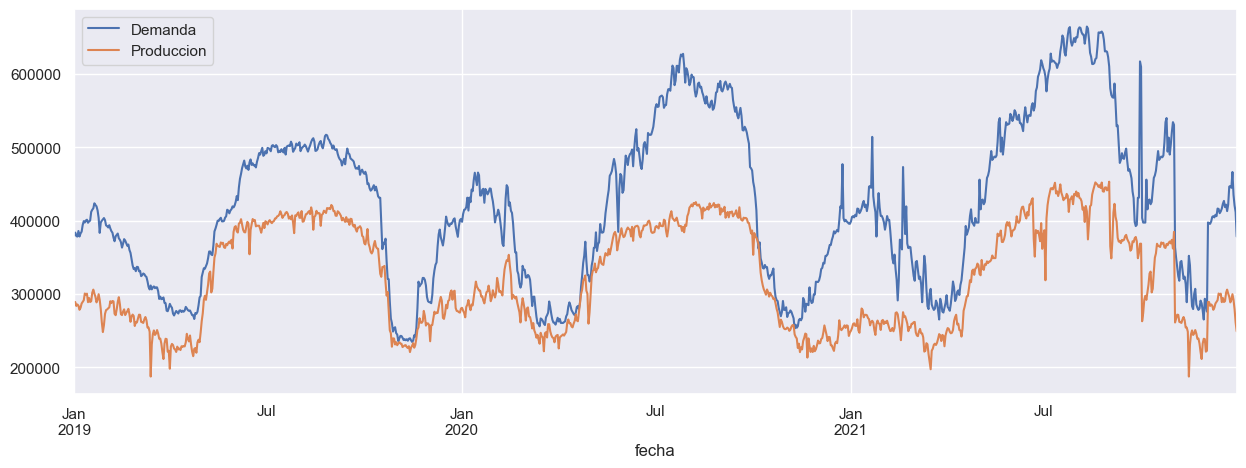

In [38]:
dataEstacion2.plot(figsize=(15,5))

Ahora vamos a entrenar una red LSTM con los años 2019 y 2020 para ver si es capaz de predecir las estaciones en 2021
Para ello con convertiremos las etiquetas de estaciones del año a una forma numérica (codificación one-hot) para que el modelo pueda entenderlas.
Se va a probar con ventanas de 7,30,60,100,180 dias  
Todo esto cogiendo una sola caracteristica luego, la realizaré con las dos para comparar resultados



In [39]:
dataLSTMEstacion = dataEstacion.copy()

In [40]:
#dataLSTMEstacion.to_csv("aa.csv", index=False)

In [54]:
dataLSTMEstacion

Demanda  Produccion  estacion
fecha                                    
2019-01-01   379726      289005  Invierno
2019-01-02   383590      288843  Invierno
2019-01-03   378901      283581  Invierno
2019-01-04   378180      285621  Invierno
2019-01-05   385805      283991  Invierno
...             ...         ...       ...
2021-12-26   466243      299610  Invierno
2021-12-27   435243      291977  Invierno
2021-12-28   420410      279246  Invierno
2021-12-29   411592      261122  Invierno
2021-12-30   378184      248905  Invierno

[1095 rows x 3 columns]

### Prediccion estaciones según solo demanda

In [42]:
def estaciones_LSTM_demanda(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))
    #reciclo la función, podría crearla arriba y llamarla, pero en todas tengo que hacer pequeños cambios, para futuras mejoras
    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]
    #solo cojo la demanda para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Demanda']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    #para mostrar resultados
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))



    Cogiendo 7 dias antes

In [43]:
estaciones_LSTM_demanda(dataLSTMEstacion, 7)


Epoch 1/20


23/23 [==============================] - 6s 50ms/step - loss: 1.4423 - accuracy: 0.3338 - val_loss: 1.4104 - val_accuracy: 0.3417
Epoch 2/20
23/23 [==============================] - 0s 11ms/step - loss: 1.4006 - accuracy: 0.3338 - val_loss: 1.3784 - val_accuracy: 0.3417
Epoch 3/20
23/23 [==============================] - 0s 11ms/step - loss: 1.3717 - accuracy: 0.3338 - val_loss: 1.3588 - val_accuracy: 0.3417
Epoch 4/20
23/23 [==============================] - 0s 11ms/step - loss: 1.3538 - accuracy: 0.3338 - val_loss: 1.3469 - val_accuracy: 0.3417
Epoch 5/20
23/23 [==============================] - 0s 11ms/step - loss: 1.3430 - accuracy: 0.3338 - val_loss: 1.3407 - val_accuracy: 0.3417
Epoch 6/20
23/23 [==============================] - 0s 11ms/step - loss: 1.3369 - accuracy: 0.3338 - val_loss: 1.3376 - val_accuracy: 0.3417
Epoch 7/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3336 - accuracy: 0.3338 - val_loss: 1.3362 - val_accuracy: 0.3417
Epoch 8/20
23/23 [=======

    Cogiendo 30 dias antes

In [44]:
estaciones_LSTM_demanda(dataLSTMEstacion, 30)

Epoch 1/20
23/23 [==============================] - 6s 46ms/step - loss: 1.3915 - accuracy: 0.2298 - val_loss: 1.3864 - val_accuracy: 0.2695
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 1.3597 - accuracy: 0.3324 - val_loss: 1.3663 - val_accuracy: 0.2695
Epoch 3/20
23/23 [==============================] - 0s 21ms/step - loss: 1.3431 - accuracy: 0.3324 - val_loss: 1.3569 - val_accuracy: 0.2695
Epoch 4/20
23/23 [==============================] - 1s 22ms/step - loss: 1.3363 - accuracy: 0.3324 - val_loss: 1.3528 - val_accuracy: 0.2695
Epoch 5/20
23/23 [==============================] - 1s 23ms/step - loss: 1.3328 - accuracy: 0.3324 - val_loss: 1.3526 - val_accuracy: 0.2695
Epoch 6/20
23/23 [==============================] - 0s 21ms/step - loss: 1.3311 - accuracy: 0.3324 - val_loss: 1.3510 - val_accuracy: 0.2695
Epoch 7/20
23/23 [==============================] - 0s 19ms/step - loss: 1.3307 - accuracy: 0.3187 - val_loss: 1.3506 - val_accuracy: 0.3653
Epoch 8/20
23

    Cogiendo 60 dias antes

In [45]:
estaciones_LSTM_demanda(dataLSTMEstacion, 60)

Epoch 1/20
23/23 [==============================] - 4s 76ms/step - loss: 1.5003 - accuracy: 0.2339 - val_loss: 1.3617 - val_accuracy: 0.4013
Epoch 2/20
23/23 [==============================] - 1s 31ms/step - loss: 1.4082 - accuracy: 0.3338 - val_loss: 1.3389 - val_accuracy: 0.4013
Epoch 3/20
23/23 [==============================] - 1s 28ms/step - loss: 1.3594 - accuracy: 0.3338 - val_loss: 1.3425 - val_accuracy: 0.4013
Epoch 4/20
23/23 [==============================] - 1s 31ms/step - loss: 1.3394 - accuracy: 0.3338 - val_loss: 1.3545 - val_accuracy: 0.4013
Epoch 5/20
23/23 [==============================] - 1s 28ms/step - loss: 1.3331 - accuracy: 0.3338 - val_loss: 1.3684 - val_accuracy: 0.4013
Epoch 6/20
23/23 [==============================] - 1s 42ms/step - loss: 1.3308 - accuracy: 0.3338 - val_loss: 1.3726 - val_accuracy: 0.4013
Epoch 7/20
23/23 [==============================] - 1s 36ms/step - loss: 1.3309 - accuracy: 0.3338 - val_loss: 1.3749 - val_accuracy: 0.4013
Epoch 8/20
23

    Cogiendo 100 dias antes

In [48]:
estaciones_LSTM_demanda(dataLSTMEstacion, 100)

Epoch 1/20
23/23 [==============================] - 7s 85ms/step - loss: 1.3578 - accuracy: 0.3324 - val_loss: 1.4388 - val_accuracy: 0.1136
Epoch 2/20
23/23 [==============================] - 1s 60ms/step - loss: 1.3359 - accuracy: 0.3324 - val_loss: 1.4076 - val_accuracy: 0.1136
Epoch 3/20
23/23 [==============================] - 1s 64ms/step - loss: 1.3313 - accuracy: 0.3105 - val_loss: 1.3891 - val_accuracy: 0.4621
Epoch 4/20
23/23 [==============================] - 2s 81ms/step - loss: 1.3310 - accuracy: 0.3092 - val_loss: 1.3863 - val_accuracy: 0.4621
Epoch 5/20
23/23 [==============================] - 1s 49ms/step - loss: 1.3302 - accuracy: 0.3242 - val_loss: 1.3942 - val_accuracy: 0.1136
Epoch 6/20
23/23 [==============================] - 1s 58ms/step - loss: 1.3307 - accuracy: 0.3324 - val_loss: 1.3969 - val_accuracy: 0.1136
Epoch 7/20
23/23 [==============================] - 1s 64ms/step - loss: 1.3308 - accuracy: 0.3379 - val_loss: 1.3878 - val_accuracy: 0.4621
Epoch 8/20
23

### Prediccion estaciones según solo produccion

In [55]:
def estaciones_LSTM_produccion(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))
    #reciclo la función, podría crearla arriba y llamarla, pero en todas tengo que hacer pequeños cambios, para futuras mejoras
    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]
    #solo cojo la produccion para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Produccion']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    #para mostrar resultados
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))


    Cogiendo 7 dias antes

In [56]:
estaciones_LSTM_produccion(dataLSTMEstacion, 7)

Epoch 1/20
23/23 [==============================] - 4s 42ms/step - loss: 1.9751 - accuracy: 0.1669 - val_loss: 1.7995 - val_accuracy: 0.1709
Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 1.7243 - accuracy: 0.1669 - val_loss: 1.6083 - val_accuracy: 0.1709
Epoch 3/20
23/23 [==============================] - 0s 13ms/step - loss: 1.5628 - accuracy: 0.1669 - val_loss: 1.4866 - val_accuracy: 0.1709
Epoch 4/20
23/23 [==============================] - 0s 15ms/step - loss: 1.4608 - accuracy: 0.2927 - val_loss: 1.4119 - val_accuracy: 0.3417
Epoch 5/20
23/23 [==============================] - 0s 16ms/step - loss: 1.3962 - accuracy: 0.3338 - val_loss: 1.3695 - val_accuracy: 0.3417
Epoch 6/20
23/23 [==============================] - 0s 12ms/step - loss: 1.3601 - accuracy: 0.3338 - val_loss: 1.3489 - val_accuracy: 0.3417
Epoch 7/20
23/23 [==============================] - 0s 12ms/step - loss: 1.3426 - accuracy: 0.3338 - val_loss: 1.3402 - val_accuracy: 0.3417
Epoch 8/20
23

    Cogiendo 30 dias antes

In [57]:
estaciones_LSTM_produccion(dataLSTMEstacion, 30)

Epoch 1/20
23/23 [==============================] - 3s 47ms/step - loss: 1.3760 - accuracy: 0.3324 - val_loss: 1.3878 - val_accuracy: 0.2695
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 1.3474 - accuracy: 0.3324 - val_loss: 1.3642 - val_accuracy: 0.2695
Epoch 3/20
23/23 [==============================] - 0s 22ms/step - loss: 1.3355 - accuracy: 0.3324 - val_loss: 1.3540 - val_accuracy: 0.2695
Epoch 4/20
23/23 [==============================] - 0s 19ms/step - loss: 1.3321 - accuracy: 0.3324 - val_loss: 1.3515 - val_accuracy: 0.2695
Epoch 5/20
23/23 [==============================] - 1s 22ms/step - loss: 1.3308 - accuracy: 0.3324 - val_loss: 1.3524 - val_accuracy: 0.2695
Epoch 6/20
23/23 [==============================] - 1s 22ms/step - loss: 1.3303 - accuracy: 0.3324 - val_loss: 1.3510 - val_accuracy: 0.3653
Epoch 7/20
23/23 [==============================] - 1s 23ms/step - loss: 1.3305 - accuracy: 0.3338 - val_loss: 1.3506 - val_accuracy: 0.3653
Epoch 8/20
23

    Cogiendo 60 dias antes

In [52]:
estaciones_LSTM_produccion(dataLSTMEstacion, 60)

Epoch 1/20
23/23 [==============================] - 5s 70ms/step - loss: 1.4019 - accuracy: 0.2517 - val_loss: 1.4120 - val_accuracy: 0.1974
Epoch 2/20
23/23 [==============================] - 1s 50ms/step - loss: 1.3606 - accuracy: 0.3324 - val_loss: 1.3925 - val_accuracy: 0.1974
Epoch 3/20
23/23 [==============================] - 1s 48ms/step - loss: 1.3414 - accuracy: 0.3324 - val_loss: 1.3797 - val_accuracy: 0.1974
Epoch 4/20
23/23 [==============================] - 1s 47ms/step - loss: 1.3344 - accuracy: 0.3324 - val_loss: 1.3750 - val_accuracy: 0.1974
Epoch 5/20
23/23 [==============================] - 1s 57ms/step - loss: 1.3319 - accuracy: 0.3324 - val_loss: 1.3778 - val_accuracy: 0.1974
Epoch 6/20
23/23 [==============================] - 1s 42ms/step - loss: 1.3308 - accuracy: 0.3324 - val_loss: 1.3757 - val_accuracy: 0.1974
Epoch 7/20
23/23 [==============================] - 1s 42ms/step - loss: 1.3307 - accuracy: 0.3242 - val_loss: 1.3758 - val_accuracy: 0.4013
Epoch 8/20
23

    Cogiendo 100 dias antes

In [53]:
estaciones_LSTM_produccion(dataLSTMEstacion, 100)

Epoch 1/20
23/23 [==============================] - 5s 85ms/step - loss: 1.7409 - accuracy: 0.1669 - val_loss: 1.3428 - val_accuracy: 0.2311
Epoch 2/20
23/23 [==============================] - 1s 52ms/step - loss: 1.5790 - accuracy: 0.2367 - val_loss: 1.2883 - val_accuracy: 0.4621
Epoch 3/20
23/23 [==============================] - 1s 56ms/step - loss: 1.4711 - accuracy: 0.3338 - val_loss: 1.2829 - val_accuracy: 0.4621
Epoch 4/20
23/23 [==============================] - 2s 70ms/step - loss: 1.4000 - accuracy: 0.3338 - val_loss: 1.3035 - val_accuracy: 0.4621
Epoch 5/20
23/23 [==============================] - 1s 62ms/step - loss: 1.3601 - accuracy: 0.3338 - val_loss: 1.3320 - val_accuracy: 0.4621
Epoch 6/20
23/23 [==============================] - 1s 58ms/step - loss: 1.3419 - accuracy: 0.3338 - val_loss: 1.3571 - val_accuracy: 0.4621
Epoch 7/20
23/23 [==============================] - 2s 82ms/step - loss: 1.3337 - accuracy: 0.3338 - val_loss: 1.3696 - val_accuracy: 0.4621
Epoch 8/20
23

### Prediccion estaciones con ambas características


In [58]:
def estaciones_LSTM(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))

    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]

    # Ahora cojo tanto la Demanda como la Producción para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Demanda', 'Produccion']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    # cambio la forma de entrada para que tenga 2 características en lugar de 1
    model.add(LSTM(50, input_shape=(look_back, 2)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))


    Cogiendo 7 dias antes

In [59]:
estaciones_LSTM(dataLSTMEstacion, 7)

Epoch 1/20
23/23 [==============================] - 3s 38ms/step - loss: 1.4556 - accuracy: 0.2818 - val_loss: 1.3933 - val_accuracy: 0.2129
Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 1.3556 - accuracy: 0.2982 - val_loss: 1.3290 - val_accuracy: 0.4006
Epoch 3/20
23/23 [==============================] - 0s 12ms/step - loss: 1.3269 - accuracy: 0.3475 - val_loss: 1.3006 - val_accuracy: 0.3557
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 1.2835 - accuracy: 0.4254 - val_loss: 1.2839 - val_accuracy: 0.3669
Epoch 5/20
23/23 [==============================] - 0s 11ms/step - loss: 1.2544 - accuracy: 0.4145 - val_loss: 1.2797 - val_accuracy: 0.3754
Epoch 6/20
23/23 [==============================] - 0s 11ms/step - loss: 1.2340 - accuracy: 0.3311 - val_loss: 1.2813 - val_accuracy: 0.3838
Epoch 7/20
23/23 [==============================] - 0s 12ms/step - loss: 1.2181 - accuracy: 0.3926 - val_loss: 1.2844 - val_accuracy: 0.3950
Epoch 8/20
23

    Cogiendo 30 dias antes

In [60]:
estaciones_LSTM(dataLSTMEstacion, 30)

Epoch 1/20
23/23 [==============================] - 5s 51ms/step - loss: 1.4578 - accuracy: 0.2271 - val_loss: 1.4447 - val_accuracy: 0.1617
Epoch 2/20
23/23 [==============================] - 1s 25ms/step - loss: 1.3824 - accuracy: 0.2668 - val_loss: 1.4021 - val_accuracy: 0.2665
Epoch 3/20
23/23 [==============================] - 1s 24ms/step - loss: 1.3377 - accuracy: 0.4172 - val_loss: 1.3725 - val_accuracy: 0.2275
Epoch 4/20
23/23 [==============================] - 1s 26ms/step - loss: 1.3083 - accuracy: 0.4282 - val_loss: 1.3576 - val_accuracy: 0.2395
Epoch 5/20
23/23 [==============================] - 1s 25ms/step - loss: 1.2896 - accuracy: 0.4432 - val_loss: 1.3491 - val_accuracy: 0.2425
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 1.2754 - accuracy: 0.4432 - val_loss: 1.3421 - val_accuracy: 0.2425
Epoch 7/20
23/23 [==============================] - 1s 25ms/step - loss: 1.2648 - accuracy: 0.4419 - val_loss: 1.3359 - val_accuracy: 0.2425
Epoch 8/20
23

    Cogiendo 60 dias antes

In [61]:
estaciones_LSTM(dataLSTMEstacion, 60)

Epoch 1/20
23/23 [==============================] - 5s 70ms/step - loss: 1.7459 - accuracy: 0.1669 - val_loss: 1.6941 - val_accuracy: 0.2007
Epoch 2/20
23/23 [==============================] - 1s 33ms/step - loss: 1.5955 - accuracy: 0.1669 - val_loss: 1.5767 - val_accuracy: 0.2007
Epoch 3/20
23/23 [==============================] - 1s 34ms/step - loss: 1.5015 - accuracy: 0.1669 - val_loss: 1.5004 - val_accuracy: 0.2007
Epoch 4/20
23/23 [==============================] - 1s 38ms/step - loss: 1.4400 - accuracy: 0.1669 - val_loss: 1.4464 - val_accuracy: 0.2007
Epoch 5/20
23/23 [==============================] - 1s 52ms/step - loss: 1.3976 - accuracy: 0.1450 - val_loss: 1.4199 - val_accuracy: 0.1743
Epoch 6/20
23/23 [==============================] - 1s 36ms/step - loss: 1.3605 - accuracy: 0.1587 - val_loss: 1.3998 - val_accuracy: 0.1809
Epoch 7/20
23/23 [==============================] - 1s 33ms/step - loss: 1.3295 - accuracy: 0.2804 - val_loss: 1.3883 - val_accuracy: 0.3158
Epoch 8/20
23

    Cogiendo 100 dias antes

In [62]:
estaciones_LSTM(dataLSTMEstacion, 100)

Epoch 1/20
23/23 [==============================] - 6s 90ms/step - loss: 1.4497 - accuracy: 0.1806 - val_loss: 1.3636 - val_accuracy: 0.4318
Epoch 2/20
23/23 [==============================] - 2s 78ms/step - loss: 1.3916 - accuracy: 0.2544 - val_loss: 1.3606 - val_accuracy: 0.3485
Epoch 3/20
23/23 [==============================] - 1s 53ms/step - loss: 1.3585 - accuracy: 0.1956 - val_loss: 1.3659 - val_accuracy: 0.3295
Epoch 4/20
23/23 [==============================] - 1s 64ms/step - loss: 1.3456 - accuracy: 0.2038 - val_loss: 1.3688 - val_accuracy: 0.3333
Epoch 5/20
23/23 [==============================] - 1s 54ms/step - loss: 1.3375 - accuracy: 0.2107 - val_loss: 1.3782 - val_accuracy: 0.2727
Epoch 6/20
23/23 [==============================] - 1s 52ms/step - loss: 1.3309 - accuracy: 0.2558 - val_loss: 1.3849 - val_accuracy: 0.2689
Epoch 7/20
23/23 [==============================] - 2s 68ms/step - loss: 1.3241 - accuracy: 0.2996 - val_loss: 1.3834 - val_accuracy: 0.3598
Epoch 8/20
23

# Estudio Covid


In [125]:
dataPreCovid = data[data.index <= pd.to_datetime("23-feb-2020")]
dataPreCovid = dataPreCovid[pd.to_datetime("15-12-2019") <= dataPreCovid.index ]
dataPreCovid

Demanda  Produccion
fecha                          
2019-12-15   375697      265910
2019-12-16   389443      272995
2019-12-17   405381      285184
2019-12-18   398381      280298
2019-12-19   394335      290496
...             ...         ...
2020-02-19   375118      296528
2020-02-20   356693      293828
2020-02-21   356625      296104
2020-02-22   331468      287810
2020-02-23   326824      281290

[71 rows x 2 columns]

<AxesSubplot:xlabel='fecha'>

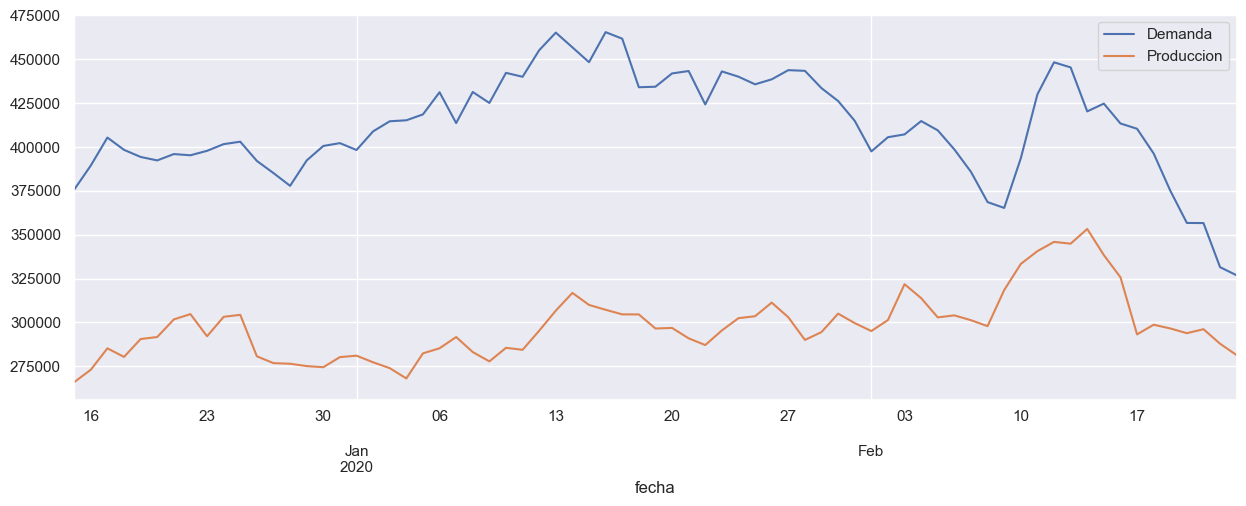

In [126]:
dataPreCovid.plot(figsize=(15,5))

In [127]:
dataCovid = data[data.index <= pd.to_datetime("30-04-2020")].copy()
dataCovid = dataCovid[pd.to_datetime("24-02-2020") <= dataCovid.index ]
dataCovid

Demanda  Produccion
fecha                          
2020-02-24   314394      274931
2020-02-25   308539      261047
2020-02-26   313477      282819
2020-02-27   338249      294075
2020-02-28   332861      286547
...             ...         ...
2020-04-26   371136      325099
2020-04-27   344921      304380
2020-04-28   325709      300122
2020-04-29   325771      259414
2020-04-30   316859      274876

[67 rows x 2 columns]

<AxesSubplot:xlabel='fecha'>

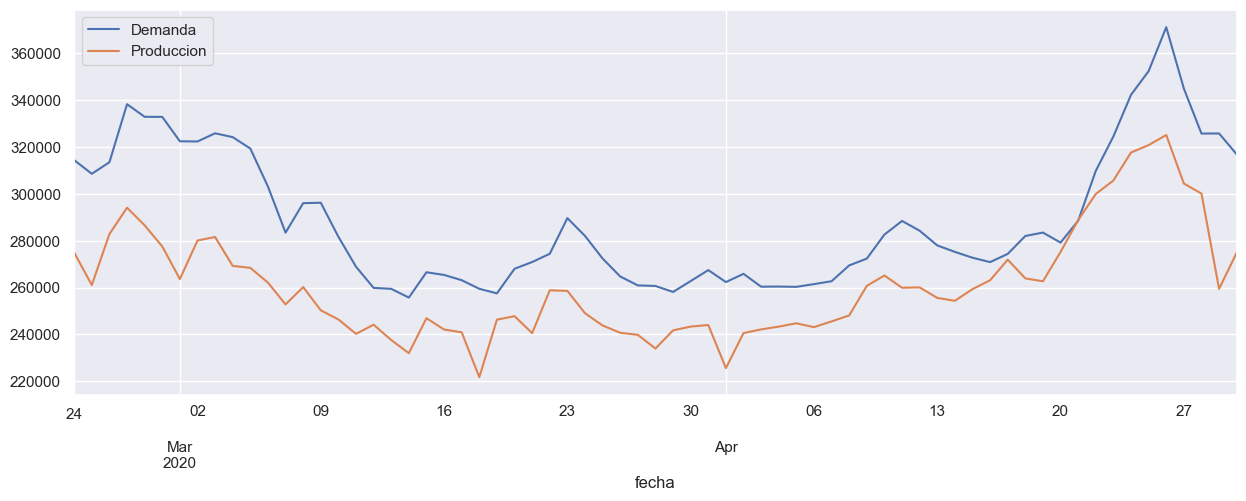

In [128]:
dataCovid.plot(figsize=(15,5))

In [129]:
media_Covid_precovid = pd.DataFrame() 
datosCovid = {'Periodo': ['Pre-Covid','Covid principio'],
        'Media demanda': [dataPreCovid['Demanda'].mean(), dataCovid['Demanda'].mean()],
        'Media produccion': [dataPreCovid['Produccion'].mean(), dataCovid['Produccion'].mean()]}

media_Covid_precovid = pd.DataFrame(datosCovid)
media_Covid_precovid = media_Covid_precovid.set_index('Periodo')
media_Covid_precovid

Media demanda  Media produccion
Periodo                                         
Pre-Covid        412271.957746     297922.295775
Covid principio  288816.000000     261000.223881

Text(0, 0.5, 'Cuantidad')

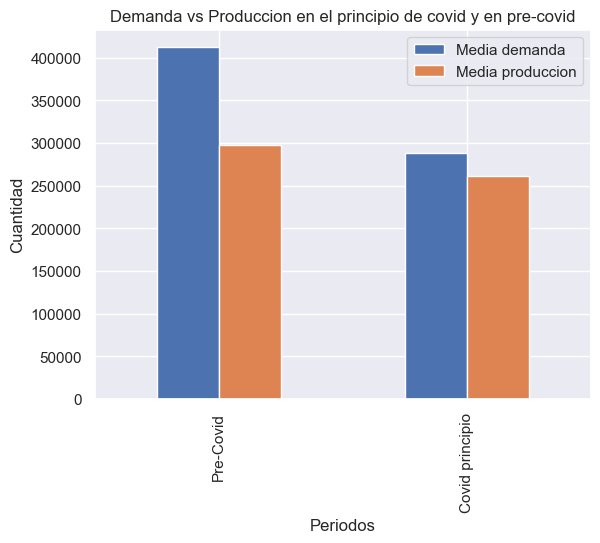

In [130]:
media_Covid_precovid.plot(kind="bar")
plt.title("Demanda vs Produccion en el principio de covid y en pre-covid")
plt.xlabel("Periodos")
plt.ylabel("Cuantidad")

# Festivo nacionales 

In [64]:
dataFestivos = data.copy()
dataFestivos

Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

In [65]:
# Lista de días festivos
festivos = ["01-jan-2019", "06-jan-2019", "01-may-2019", "14-jul-2019", "03-oct-2019",
            "01-jan-2020", "06-jan-2020", "01-may-2020", "14-jul-2020", "03-oct-2020",
            "01-jan-2021", "06-jan-2021", "01-may-2021", "14-jul-2021", "03-oct-2021"]


# Crear una columna 'Festivo_Nacional' en el DataFrame
dataFestivos['Festivo_Nacional'] = dataFestivos.index.isin(festivos).astype(int)



In [66]:
dataFestivos

Demanda  Produccion  Festivo_Nacional
fecha                                            
2019-01-01   379726      289005                 1
2019-01-02   383590      288843                 0
2019-01-03   378901      283581                 0
2019-01-04   378180      285621                 0
2019-01-05   385805      283991                 0
...             ...         ...               ...
2021-12-26   466243      299610                 0
2021-12-27   435243      291977                 0
2021-12-28   420410      279246                 0
2021-12-29   411592      261122                 0
2021-12-30   378184      248905                 0

[1095 rows x 3 columns]

### Prediccion festivo según solo demanda

In [67]:
def festivo_lstm_demanda(data, look_back):
    #aqui cojo la demanda, he probado otra manera
    features = data[['Demanda']].values

    labels = data['Festivo_Nacional'].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    def create_dataset(X, y, look_back=1):
        Xs, ys = [], []
        for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
            ys.append(y[i + look_back])
        return np.array(Xs), np.array(ys)

    X, y = create_dataset(scaled_features, labels, look_back)

    years_train = data.index[look_back:].year < 2021
    years_test = (data.index[look_back:].year == 2021) & (data['Festivo_Nacional'][look_back:] == 1)
    X_train, y_train = X[years_train], y[years_train]
    X_test, y_test = X[years_test], y[years_test]

    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))


In [68]:
festivo_lstm_demanda(dataFestivos, 7)

Epoch 1/20
23/23 [==============================] - 4s 44ms/step - loss: 0.5808 - accuracy: 0.9890 - val_loss: 1.1157 - val_accuracy: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 0s 15ms/step - loss: 0.2739 - accuracy: 0.9890 - val_loss: 3.5776 - val_accuracy: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 0.0747 - accuracy: 0.9890 - val_loss: 5.8672 - val_accuracy: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 0s 19ms/step - loss: 0.0678 - accuracy: 0.9890 - val_loss: 5.3092 - val_accuracy: 0.0000e+00
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0648 - accuracy: 0.9890 - val_loss: 4.8859 - val_accuracy: 0.0000e+00
Epoch 6/20
23/23 [==============================] - 0s 18ms/step - loss: 0.0639 - accuracy: 0.9890 - val_loss: 4.7601 - val_accuracy: 0.0000e+00
Epoch 7/20
23/23 [==============================] - 0s 14ms/step - loss: 0.0633 - accuracy: 0.9890 - val_loss: 4.7130 - val_accura

In [69]:
festivo_lstm_demanda(dataFestivos, 30)

Epoch 1/20
22/22 [==============================] - 6s 72ms/step - loss: 0.4328 - accuracy: 0.9886 - val_loss: 3.2491 - val_accuracy: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 1s 28ms/step - loss: 0.0653 - accuracy: 0.9886 - val_loss: 4.7878 - val_accuracy: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 0s 22ms/step - loss: 0.0629 - accuracy: 0.9886 - val_loss: 4.5155 - val_accuracy: 0.0000e+00
Epoch 4/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4074 - val_accuracy: 0.0000e+00
Epoch 5/20
22/22 [==============================] - 1s 25ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4263 - val_accuracy: 0.0000e+00
Epoch 6/20
22/22 [==============================] - 1s 25ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4355 - val_accuracy: 0.0000e+00
Epoch 7/20
22/22 [==============================] - 0s 22ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4319 - val_accura

In [70]:
festivo_lstm_demanda(dataFestivos, 100)

Epoch 1/20
20/20 [==============================] - 6s 94ms/step - loss: 0.5035 - accuracy: 0.9873 - val_loss: 2.2720 - val_accuracy: 0.0000e+00
Epoch 2/20
20/20 [==============================] - 1s 48ms/step - loss: 0.0785 - accuracy: 0.9873 - val_loss: 4.5635 - val_accuracy: 0.0000e+00
Epoch 3/20
20/20 [==============================] - 2s 98ms/step - loss: 0.0685 - accuracy: 0.9873 - val_loss: 4.6241 - val_accuracy: 0.0000e+00
Epoch 4/20
20/20 [==============================] - 2s 112ms/step - loss: 0.0684 - accuracy: 0.9873 - val_loss: 4.4310 - val_accuracy: 0.0000e+00
Epoch 5/20
20/20 [==============================] - 1s 70ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3611 - val_accuracy: 0.0000e+00
Epoch 6/20
20/20 [==============================] - 2s 83ms/step - loss: 0.0680 - accuracy: 0.9873 - val_loss: 4.3641 - val_accuracy: 0.0000e+00
Epoch 7/20
20/20 [==============================] - 1s 74ms/step - loss: 0.0680 - accuracy: 0.9873 - val_loss: 4.3733 - val_accur

### Prediccion estaciones según solo produccion

In [71]:
def festivo_lstm_produccion(data, look_back):
    #aqui cojo la produccion, he probado otra manera
    features = data[['Produccion']].values

    labels = data['Festivo_Nacional'].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    def create_dataset(X, y, look_back=1):
        Xs, ys = [], []
        for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
            ys.append(y[i + look_back])
        return np.array(Xs), np.array(ys)

    X, y = create_dataset(scaled_features, labels, look_back)

    years_train = data.index[look_back:].year < 2021
    years_test = (data.index[look_back:].year == 2021) & (data['Festivo_Nacional'][look_back:] == 1)
    X_train, y_train = X[years_train], y[years_train]
    X_test, y_test = X[years_test], y[years_test]

    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))


In [72]:
festivo_lstm_produccion(dataFestivos, 7)

Epoch 1/20
23/23 [==============================] - 4s 32ms/step - loss: 0.5953 - accuracy: 0.8964 - val_loss: 1.0462 - val_accuracy: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.2819 - accuracy: 0.9890 - val_loss: 2.9615 - val_accuracy: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0769 - accuracy: 0.9890 - val_loss: 5.4117 - val_accuracy: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.9890 - val_loss: 5.0574 - val_accuracy: 0.0000e+00
Epoch 5/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0648 - accuracy: 0.9890 - val_loss: 4.6889 - val_accuracy: 0.0000e+00
Epoch 6/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0640 - accuracy: 0.9890 - val_loss: 4.6001 - val_accuracy: 0.0000e+00
Epoch 7/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 0.9890 - val_loss: 4.5837 - val_accuracy: 0.

In [73]:
festivo_lstm_produccion(dataFestivos, 30)

Epoch 1/20
22/22 [==============================] - 4s 46ms/step - loss: 0.4742 - accuracy: 0.9886 - val_loss: 2.3199 - val_accuracy: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0724 - accuracy: 0.9886 - val_loss: 4.7566 - val_accuracy: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 0s 17ms/step - loss: 0.0631 - accuracy: 0.9886 - val_loss: 4.6321 - val_accuracy: 0.0000e+00
Epoch 4/20
22/22 [==============================] - 0s 16ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4535 - val_accuracy: 0.0000e+00
Epoch 5/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4301 - val_accuracy: 0.0000e+00
Epoch 6/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4434 - val_accuracy: 0.0000e+00
Epoch 7/20
22/22 [==============================] - 0s 17ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4465 - val_accura

In [74]:
festivo_lstm_produccion(dataFestivos, 100)

Epoch 1/20
20/20 [==============================] - 4s 78ms/step - loss: 0.4305 - accuracy: 0.9873 - val_loss: 3.0240 - val_accuracy: 0.0000e+00
Epoch 2/20
20/20 [==============================] - 1s 49ms/step - loss: 0.0691 - accuracy: 0.9873 - val_loss: 4.8170 - val_accuracy: 0.0000e+00
Epoch 3/20
20/20 [==============================] - 1s 44ms/step - loss: 0.0692 - accuracy: 0.9873 - val_loss: 4.6788 - val_accuracy: 0.0000e+00
Epoch 4/20
20/20 [==============================] - 1s 44ms/step - loss: 0.0685 - accuracy: 0.9873 - val_loss: 4.4588 - val_accuracy: 0.0000e+00
Epoch 5/20
20/20 [==============================] - 1s 44ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3729 - val_accuracy: 0.0000e+00
Epoch 6/20
20/20 [==============================] - 1s 46ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3655 - val_accuracy: 0.0000e+00
Epoch 7/20
20/20 [==============================] - 1s 48ms/step - loss: 0.0680 - accuracy: 0.9873 - val_loss: 4.3736 - val_accura

### Prediccion estaciones ambas características

In [75]:
def festivos_LSTM(data, look_back):
    features = data[['Produccion', 'Demanda']].values
    labels = data['Festivo_Nacional'].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    def create_dataset(X, y, look_back=1):
        Xs, ys = [], []
        for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
            ys.append(y[i + look_back])
        return np.array(Xs), np.array(ys)

    X, y = create_dataset(scaled_features, labels, look_back)

    years_train = data.index[look_back:].year < 2021
    years_test = (data.index[look_back:].year == 2021) & (data['Festivo_Nacional'][look_back:] == 1)

    X_train = X[years_train]
    y_train = y[years_train]
    X_test = X[years_test]
    y_test = y[years_test]

    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, shuffle=False, batch_size=32, verbose=1)
       
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))


In [202]:
festivos_LSTM(dataFestivos, 7)

Epoch 1/20
23/23 [==============================] - 5s 44ms/step - loss: 0.5587 - accuracy: 0.9144 - val_loss: 1.2127 - val_accuracy: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 0s 15ms/step - loss: 0.2397 - accuracy: 0.9890 - val_loss: 3.5203 - val_accuracy: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0776 - accuracy: 0.9890 - val_loss: 5.6134 - val_accuracy: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 0s 12ms/step - loss: 0.0684 - accuracy: 0.9890 - val_loss: 5.2524 - val_accuracy: 0.0000e+00
Epoch 5/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0656 - accuracy: 0.9890 - val_loss: 4.8809 - val_accuracy: 0.0000e+00
Epoch 6/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0643 - accuracy: 0.9890 - val_loss: 4.7328 - val_accuracy: 0.0000e+00
Epoch 7/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0635 - accuracy: 0.9890 - val_loss: 4.6688 - val_accura

In [76]:
festivos_LSTM(dataFestivos, 30)

Epoch 1/20
22/22 [==============================] - 5s 54ms/step - loss: 0.4173 - accuracy: 0.9886 - val_loss: 2.8232 - val_accuracy: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0680 - accuracy: 0.9886 - val_loss: 4.7167 - val_accuracy: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 0s 15ms/step - loss: 0.0631 - accuracy: 0.9886 - val_loss: 4.6382 - val_accuracy: 0.0000e+00
Epoch 4/20
22/22 [==============================] - 0s 17ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4538 - val_accuracy: 0.0000e+00
Epoch 5/20
22/22 [==============================] - 0s 15ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4206 - val_accuracy: 0.0000e+00
Epoch 6/20
22/22 [==============================] - 0s 17ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4326 - val_accuracy: 0.0000e+00
Epoch 7/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4359 - val_accura

In [77]:
festivos_LSTM(dataFestivos, 100)

Epoch 1/20
20/20 [==============================] - 4s 91ms/step - loss: 0.4808 - accuracy: 0.9873 - val_loss: 2.4353 - val_accuracy: 0.0000e+00
Epoch 2/20
20/20 [==============================] - 1s 51ms/step - loss: 0.0761 - accuracy: 0.9873 - val_loss: 4.5556 - val_accuracy: 0.0000e+00
Epoch 3/20
20/20 [==============================] - 1s 46ms/step - loss: 0.0684 - accuracy: 0.9873 - val_loss: 4.5638 - val_accuracy: 0.0000e+00
Epoch 4/20
20/20 [==============================] - 1s 46ms/step - loss: 0.0683 - accuracy: 0.9873 - val_loss: 4.4070 - val_accuracy: 0.0000e+00
Epoch 5/20
20/20 [==============================] - 1s 48ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3632 - val_accuracy: 0.0000e+00
Epoch 6/20
20/20 [==============================] - 1s 48ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3718 - val_accuracy: 0.0000e+00
Epoch 7/20
20/20 [==============================] - 1s 45ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3787 - val_accura

# Análisis de festivos 

In [69]:
Festivos_Nacionales = ["01-jan-2019" ,"06-jan-2019","01-may-2019","14-jul-2019","03-oct-2019","01-jan-2020" ,"06-jan-2020","01-may-2020","14-jul-2020","03-oct-2020","01-jan-2021" ,"06-jan-2021","01-may-2021","14-jul-2021","03-oct-2021"]
Festivos_Nacionales


['01-jan-2019',
 '06-jan-2019',
 '01-may-2019',
 '14-jul-2019',
 '03-oct-2019',
 '01-jan-2020',
 '06-jan-2020',
 '01-may-2020',
 '14-jul-2020',
 '03-oct-2020',
 '01-jan-2021',
 '06-jan-2021',
 '01-may-2021',
 '14-jul-2021',
 '03-oct-2021']

In [70]:
dataFestivo = data[data.index.isin(Festivos_Nacionales)]
dataFestivo


Demanda  Produccion  Festivo_Nacional
fecha                                            
2019-01-01   379726      289005                 1
2019-01-06   378280      278314                 1
2019-05-01   323099      262720                 1
2019-07-14   493512      412650                 1
2019-10-03   461922      375271                 1
2020-01-01   398283      281007                 1
2020-01-06   431218      285232                 1
2020-05-01   320559      299753                 1
2020-07-14   579399      400581                 1
2020-10-03   431841      378241                 1
2021-01-01   398854      249832                 1
2021-01-06   406022      256305                 1
2021-05-01   397250      339273                 1
2021-07-14   608133      439941                 1
2021-10-03   397250      273672                 1

<AxesSubplot:xlabel='fecha'>

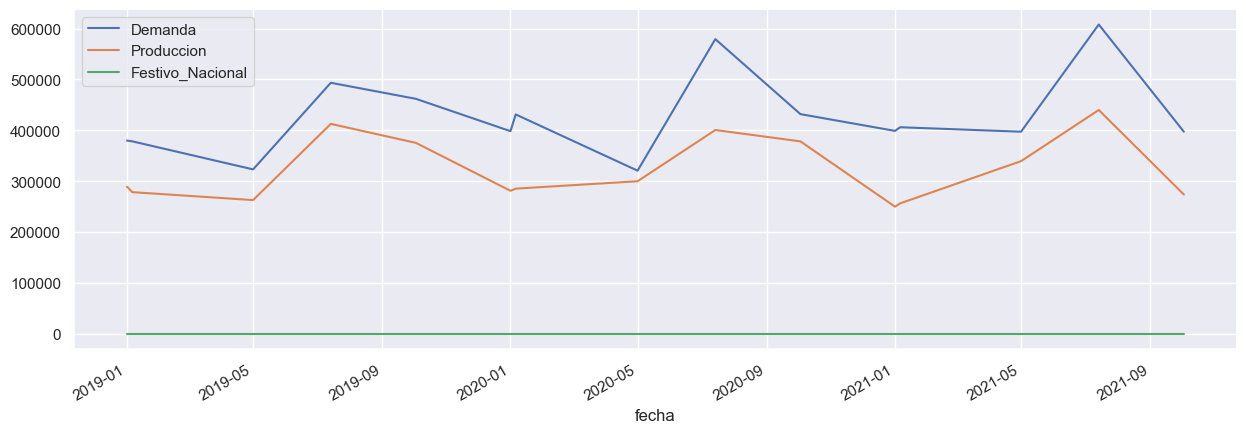

In [71]:
dataFestivo.plot(figsize=(15,5))

Text(0, 0.5, 'Cuantidad')

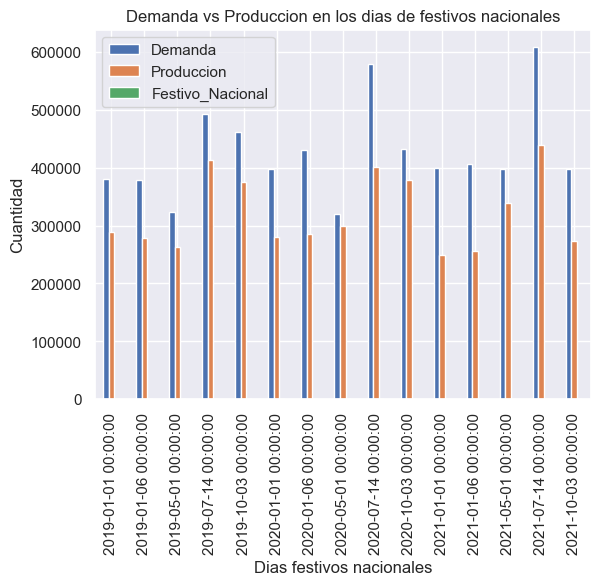

In [72]:
dataFestivo.plot(kind="bar")
plt.title("Demanda vs Produccion en los dias de festivos nacionales")
plt.xlabel("Dias festivos nacionales")
plt.ylabel("Cuantidad")

In [73]:
dataTemporadasProduccion = dataEstacion.groupby('estacion').agg(media_produccion=('Produccion','mean')).reset_index()
dataTemporadasProduccion

estacion  media_produccion
0   Invierno     268142.710383
1      Otoño     283917.808743
2  Primavera     306742.420765
3     Verano     403776.814208

In [74]:
dataTemporadasDemanda = dataEstacion.groupby('estacion').agg(media_Demanda=('Demanda','mean')).reset_index()
dataTemporadasDemanda

estacion  media_Demanda
0   Invierno  368132.762295
1      Otoño  342338.863388
2  Primavera  365714.278689
3     Verano  540844.855191

In [75]:
dataTemporadas = pd.merge(dataTemporadasDemanda, dataTemporadasProduccion, on='estacion')
dataTemporadas = dataTemporadas.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})
dataTemporadas = dataTemporadas.set_index('estacion')
dataTemporadas

media_Demanda  media_produccion
estacion                                  
Invierno   368132.762295     268142.710383
Otoño      342338.863388     283917.808743
Primavera  365714.278689     306742.420765
Verano     540844.855191     403776.814208

Text(0, 0.5, 'Capacidad media')

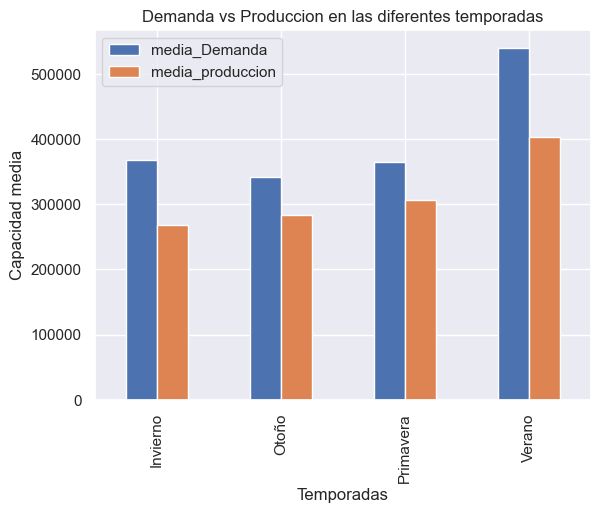

In [76]:
dataTemporadas.plot(kind="bar")
plt.title("Demanda vs Produccion en las diferentes temporadas")
plt.xlabel("Temporadas")
plt.ylabel("Capacidad media")

# Shaaban vs  Ramadan

In [78]:
data_shaaban_ramadan = data.copy()

In [79]:
data_shaaban_ramadan

Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

In [80]:
date_index = pd.date_range(start="01-01-2019", periods=len(data_shaaban_ramadan), freq='D')
data_shaaban_ramadan.index = date_index

In [81]:
data_shaaban_ramadan

Demanda  Produccion
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

In [82]:
periodos = pd.Series(0, index=data_shaaban_ramadan.index)
periodos[(pd.to_datetime("06-may-2019") <= periodos.index) & (periodos.index <= pd.to_datetime("04-jun-2019"))] = 1
periodos[(pd.to_datetime("06-apr-2019") <= periodos.index) & (periodos.index <= pd.to_datetime("05-may-2019"))] = 1
periodos[(pd.to_datetime("24-apr-2020") <= periodos.index) & (periodos.index <= pd.to_datetime("23-may-2020"))] = 1
periodos[(pd.to_datetime("25-mar-2020") <= periodos.index) & (periodos.index <= pd.to_datetime("23-apr-2020"))] = 1
periodos[(pd.to_datetime("13-apr-2021") <= periodos.index) & (periodos.index <= pd.to_datetime("12-may-2021"))] = 1
periodos[(pd.to_datetime("14-mar-2021") <= periodos.index) & (periodos.index <= pd.to_datetime("12-apr-2021"))] = 1
data_shaaban_ramadan['periodo'] = periodos

In [83]:
features = ['Demanda', 'Produccion', 'periodo']
train_data = data_shaaban_ramadan[features]['2019-01-01':'2020-12-31']
valid_data = data_shaaban_ramadan[features]['2021-01-01':]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)

In [84]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-1])
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [119]:
look_back = 100
X_train, y_train = create_dataset(train_scaled, look_back)
X_valid, y_valid = create_dataset(valid_scaled, look_back)

In [120]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

Epoch 1/50
20/20 - 9s - loss: 0.6206 - accuracy: 0.6418 - val_loss: 0.3510 - val_accuracy: 0.8788 - 9s/epoch - 440ms/step
Epoch 2/50
20/20 - 2s - loss: 0.4661 - accuracy: 0.8177 - val_loss: 0.2817 - val_accuracy: 0.8788 - 2s/epoch - 109ms/step
Epoch 3/50
20/20 - 2s - loss: 0.4097 - accuracy: 0.8177 - val_loss: 0.2814 - val_accuracy: 0.8788 - 2s/epoch - 105ms/step
Epoch 4/50
20/20 - 2s - loss: 0.3832 - accuracy: 0.8177 - val_loss: 0.2606 - val_accuracy: 0.8788 - 2s/epoch - 102ms/step
Epoch 5/50
20/20 - 2s - loss: 0.3736 - accuracy: 0.8177 - val_loss: 0.2355 - val_accuracy: 0.8788 - 2s/epoch - 99ms/step
Epoch 6/50
20/20 - 2s - loss: 0.3472 - accuracy: 0.8177 - val_loss: 0.1935 - val_accuracy: 0.8788 - 2s/epoch - 101ms/step
Epoch 7/50
20/20 - 2s - loss: 0.4115 - accuracy: 0.7861 - val_loss: 0.3253 - val_accuracy: 0.8788 - 2s/epoch - 105ms/step
Epoch 8/50
20/20 - 2s - loss: 0.4141 - accuracy: 0.8257 - val_loss: 0.2284 - val_accuracy: 0.8788 - 2s/epoch - 98ms/step
Epoch 9/50
20/20 - 2s - lo

In [121]:
y_pred_probs = model.predict(X_valid)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

9/9 [==============================] - 1s 35ms/step


In [122]:
real_days = y_valid[y_valid == 1]
predicted_days = y_pred[y_valid == 1]
accuracy = accuracy_score(real_days, predicted_days)
print(f"Accuracy: {accuracy * 100:.2f}%")
report = classification_report(real_days, predicted_days)
print(report)

Accuracy: 78.12%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.78      0.88        32

    accuracy                           0.78        32
   macro avg       0.50      0.39      0.44        32
weighted avg       1.00      0.78      0.88        32



# Análisis exploratorio del Ramadan y el Shaa'ban

In [50]:
#2019
dataRamadan2019 = data[pd.to_datetime("06-may-2019") <= data.index ]
dataRamadan2019  = dataRamadan2019[dataRamadan2019.index <= pd.to_datetime("04-jun-2019")]

dataShaaban2019 = data[pd.to_datetime("06-apr-2019") <= data.index ]
dataShaaban2019  = dataShaaban2019[dataShaaban2019.index <= pd.to_datetime("05-may-2019")]

#2020
dataRamadan2020 = data[pd.to_datetime("24-apr-2020") <= data.index ]
dataRamadan2020  = dataRamadan2020[dataRamadan2020.index <= pd.to_datetime("23-may-2020")]

dataShaaban2020 = data[pd.to_datetime("25-mar-2020") <= data.index ]
dataShaaban2020  = dataShaaban2020[dataShaaban2020.index <= pd.to_datetime("23-apr-2020")]

#2021
dataRamadan2021 = data[pd.to_datetime("13-apr-2021") <= data.index ]
dataRamadan2021  = dataRamadan2021[dataRamadan2021.index <= pd.to_datetime("12-may-2021")]

dataShaaban2021 = data[pd.to_datetime("14-mar-2021") <= data.index ]
dataShaaban2021  = dataShaaban2021[dataShaaban2021.index <= pd.to_datetime("12-apr-2021")]


In [51]:
media_Chaaban_Ramadan = pd.DataFrame() 
datos = {'Mes_hijri': ['Shaaban 2019','Ramadan 2019' ,'Shaaban 2020','Ramadan 2020', 'Shaaban 2021','Ramadan 2021'],
        'Media demanda': [dataShaaban2019['Demanda'].mean(), dataRamadan2019['Demanda'].mean(), dataShaaban2020['Demanda'].mean(), dataRamadan2020['Demanda'].mean(), dataShaaban2021['Demanda'].mean(),dataRamadan2021['Demanda'].mean()],
        'Media produccion': [dataShaaban2019['Produccion'].mean(), dataRamadan2019['Produccion'].mean(), dataShaaban2020['Produccion'].mean(), dataRamadan2020['Produccion'].mean(), dataShaaban2021['Produccion'].mean(),dataRamadan2021['Produccion'].mean()]}

media_Shaaban_Ramadan = pd.DataFrame(datos)
media_Shaaban_Ramadan = media_Shaaban_Ramadan.set_index('Mes_hijri')
media_Shaaban_Ramadan

Media demanda  Media produccion
Mes_hijri                                    
Shaaban 2019  286469.000000     238806.866667
Ramadan 2019  395727.033333     357752.066667
Shaaban 2020  273865.533333     255552.966667
Ramadan 2020  386320.000000     335347.600000
Shaaban 2021  288550.200000     240607.533333
Ramadan 2021  400432.066667     314738.500000

Text(0, 0.5, 'Media')

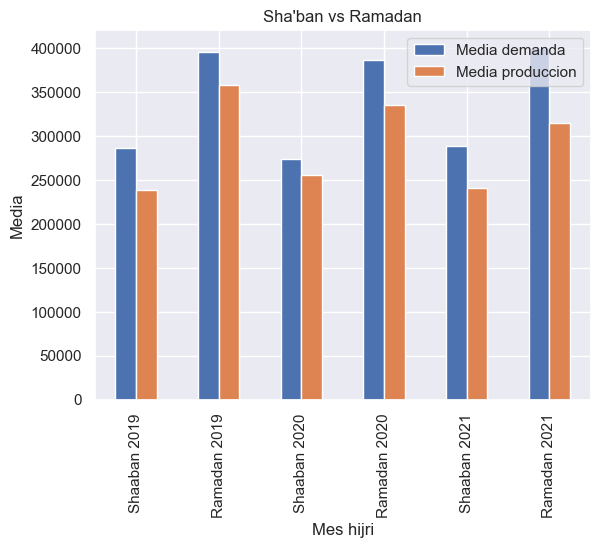

In [52]:
media_Shaaban_Ramadan.plot(kind="bar")
plt.title("Sha'ban vs Ramadan")
plt.xlabel("Mes hijri")
plt.ylabel("Media")

In [53]:
data.describe()

Demanda     Produccion
count    1095.000000    1095.000000
mean   420994.799087  322561.829224
std    108713.245473   69567.326734
min    234522.000000  187266.000000
25%    325740.000000  258997.500000
50%    411592.000000  303169.000000
75%    498163.500000  391964.000000
max    664606.000000  453020.000000

Ya de primera podemos observar que vamos a tener dias donde la demanda supera a la produccion, y ademas de media siempre vamos a tener mayor demanda que produccion

In [76]:
dataMes= data.resample('m').sum()
dataMes

Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12639971     8785986
2022-01-31    855232      550632

In [55]:
dataAno = data.resample('y').sum()
dataAno

Demanda  Produccion
fecha                            
2019-12-31  143314874   116508462
2020-12-31  152389040   117898414
2021-12-31  165285391   118798327

<AxesSubplot:xlabel='fecha'>

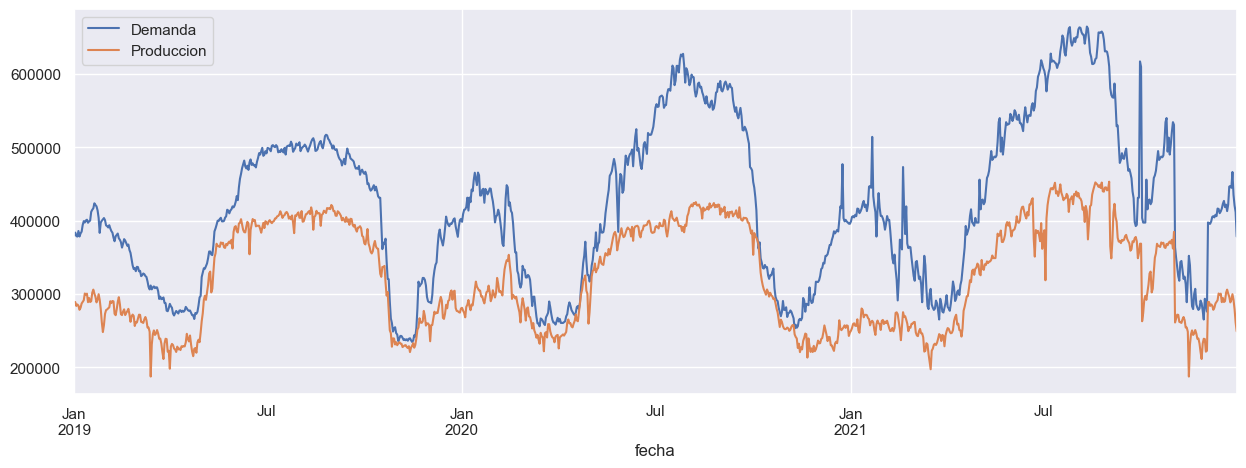

In [56]:
data.plot(figsize=(15,5))

<AxesSubplot:>

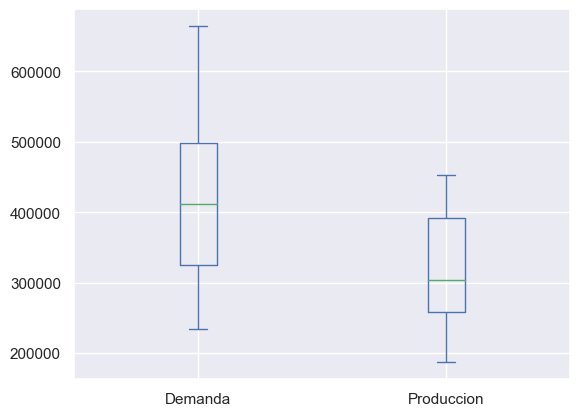

In [57]:
data.plot.box()

Vemos que la produccion nunca abaste la demanda, ademas nos fijamos que en los meses de verano siempre tenemos un pico de demanda que ademas aumenta con los años mientras que la produccion de mantiene

# Dickey-fuller

Vamos a pasar a comprobar si nuestra serie de tiempo es estacionario o no. Para ello vamos a seguir el modelo Dickey-Fuller

In [58]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviacion estandar')
    plt.legend(loc='best')
    plt.title('Media móvil & Desviacion estandar')
    plt.show(block=False)
    
    print ('Resultados del Dickey-Fuller Test:')
   
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba','p-value','#Lags Used','Numero de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valores criticos (%s)'%key] = value
    print(dfoutput)

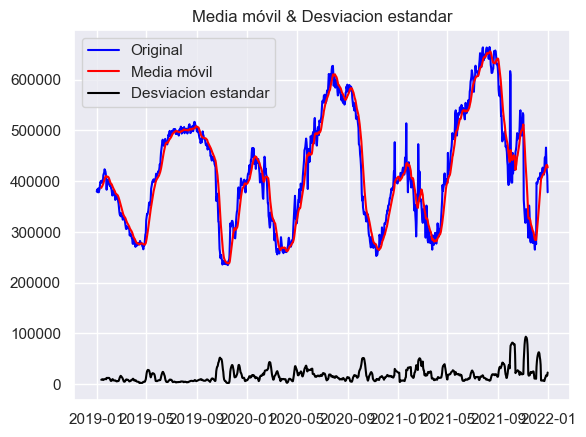

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -3.080073
p-value                       0.028063
#Lags Used                   16.000000
Numero de observaciones    1078.000000
Valores criticos (1%)        -3.436431
Valores criticos (5%)        -2.864225
Valores criticos (10%)       -2.568200
dtype: float64


In [59]:
adfullerDemanda = test_stationarity(data['Demanda'])

Según estos resultados vemos observamos que podemos afirmar que al demanda es estacionario por diversos motivos, el p-value nos indica que tenemos una probabilidad muy baja del 2.68% de que los resultados observados en la serie de tiempo se deban al azar que nos indica que podemos rechazar la hipotesis nula. Luego el estadístico de prueba es menor que los valores críticos para los niveles de significación de 1% y 5% y no difiere mucho del 10% por lo que volvemos a rechazar la hipotesis nula. 

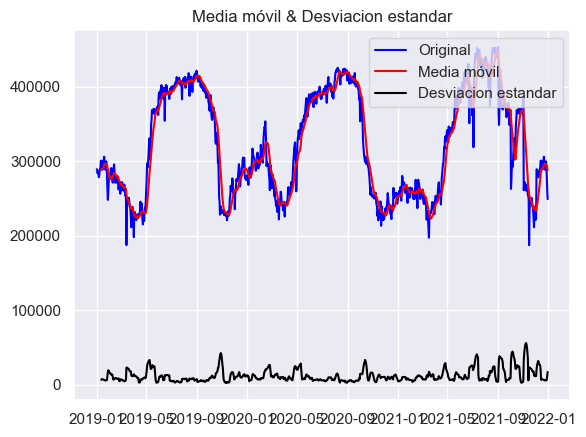

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -2.022303
p-value                       0.276880
#Lags Used                    4.000000
Numero de observaciones    1090.000000
Valores criticos (1%)        -3.436364
Valores criticos (5%)        -2.864195
Valores criticos (10%)       -2.568184
dtype: float64


In [60]:
adfullerProduccion = test_stationarity(data['Produccion'])

Con la produccion vemos que ocurre todo lo contrario, el p-value es mayor que el valor de significancia del 0,05 y ademas nuestro estadistico de prueba es mayor que todos los valores criticos. Por lo cual decidimos que la serie de tiempo no es estacionaria.

## ARIMA

Sabiendo que la demanda si es estacionaria, vamos a aplicarle un modelo de  regresion autorregresiva integrada de media movil (ARIMA)

In [61]:
dataArima= dataMes['Demanda'].copy()


In [62]:
train_data_arima = dataArima[:int(len(dataArima)*0.8)].copy()
test_data_arima = dataArima[int(len(dataArima)*0.8):].copy()


In [63]:
def modelo_arima(p,d,q):
    model = ARIMA(train_data_arima, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())

In [64]:
modelo_arima(1,1,1)
modelo_arima(2,1,1)
modelo_arima(2,1,2)


                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.052
Date:                Thu, 24 Aug 2023   AIC                            878.104
Time:                        18:38:49   BIC                            881.991
Sample:                    01-31-2019   HQIC                           879.260
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      1.231     -0.177      0.860      -2.631       2.196
ma.L1          0.3382      1.249      0.271      0.787      -2.109       2.786
sigma2      5.968e+12   4.28e-13   1.39e+25      0.0

Vamos a probar con una funcion que nos saca lo mejores valores

Vemos que el mejor AIC lo tiene el modelo para los valores (2,1,2)

In [65]:
modelfinal = ARIMA(train_data_arima, order=(2, 1, 2))
model_fit1 = modelfinal.fit()

In [66]:
forecast = model_fit1.forecast(steps=10)[0]

In [67]:
print(forecast)

11083109.210077316


In [68]:
predicciones = model_fit1.predict(start=len(train_data_arima), end=len(dataArima)-1, typ='levels')
predicciones

2021-05-31    1.108311e+07
2021-06-30    1.302891e+07
2021-07-31    1.414135e+07
2021-08-31    1.331579e+07
2021-09-30    1.140824e+07
2021-10-31    1.034849e+07
2021-11-30    1.118810e+07
2021-12-31    1.305750e+07
Freq: M, Name: predicted_mean, dtype: float64

In [69]:
errorARIMA = np.mean(np.abs((test_data_arima - predicciones) / test_data_arima)) * 100
accuracyARIMA = 100 - errorARIMA
mseARIMA = mean_squared_error(test_data_arima, predicciones)

In [70]:
print(f"Precision modelo ARIMA es: {accuracyARIMA}" )
print(f"El error es: {errorARIMA}")
print(f"El error cuadrático mse: {mseARIMA} kw")

Precision modelo ARIMA es: 76.83425210441922
El error es: 23.16574789558078
El error cuadrático mse: 16757269390052.26 kw


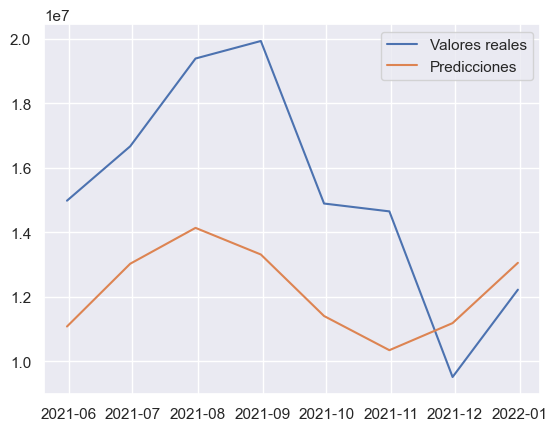

In [71]:
plt.plot(dataArima.index[int(len(dataArima)*0.8):], test_data_arima, label='Valores reales')
plt.plot(dataArima.index[int(len(dataArima)*0.8):], predicciones, label='Predicciones')
plt.legend()
plt.show()

# LSTM por días con ambas características

Estudiando un poco la relación que existe entre la demanda y la produccion encontramos que esta última siempre va a estar condicionada por la demanda ya que no se puede dar el caso de que la produccion sea mayor que la demanda. Vamos a aplicar un modelo de Deep learning conocido como Redes neuronales recurrentes(RNN), las cuales cuentan con "memoria". Usaremos de tipo LSTM, con dos capas LSTM de 50 unidades, una Dense con una única salida y el optimizador Adam, que para este tipo de series temporales es el mas adecuado

In [123]:
dataRNNdias = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdias), freq='D')
dataRNNdias.index = date_index

### LSTM para predececir la demanda

In [124]:
def LSTMDemandaDiarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]
    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el día anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 6s 31ms/step - loss: 0.2282 - val_loss: 0.3231
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1599 - val_loss: 0.2069
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0738 - val_loss: 0.0623
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.0186
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0172 - val_loss: 0.0181
Epoch 6/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0066
Epoch 9/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0067
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0072
Epoch 11/50
23/23

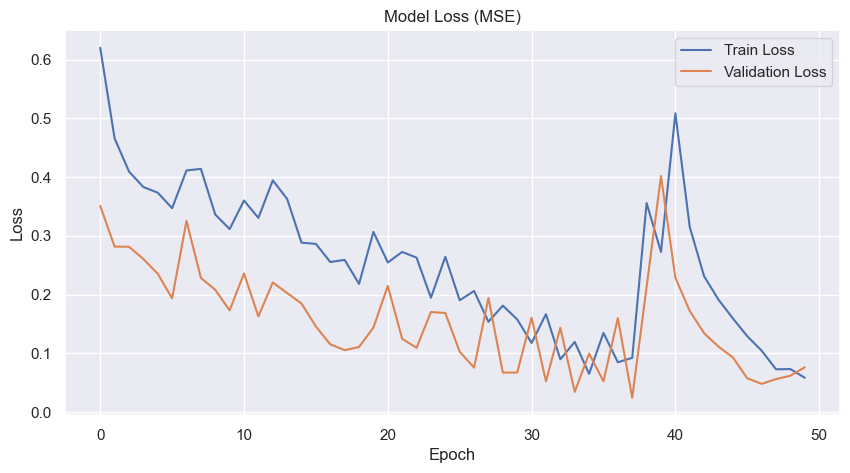

12/12 [==============================] - 1s 3ms/step
     Real Values   Predictions
0         405037  398319.43750
1         406001  403743.46875
2         404353  404779.12500
3         407859  403391.15625
4         406022  406297.78125
..           ...           ...
361       411592  418251.21875
362       378184  409724.46875
363       414996  380093.90625
364       437452  411940.53125
365       417780  430495.65625

[366 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 22.95%


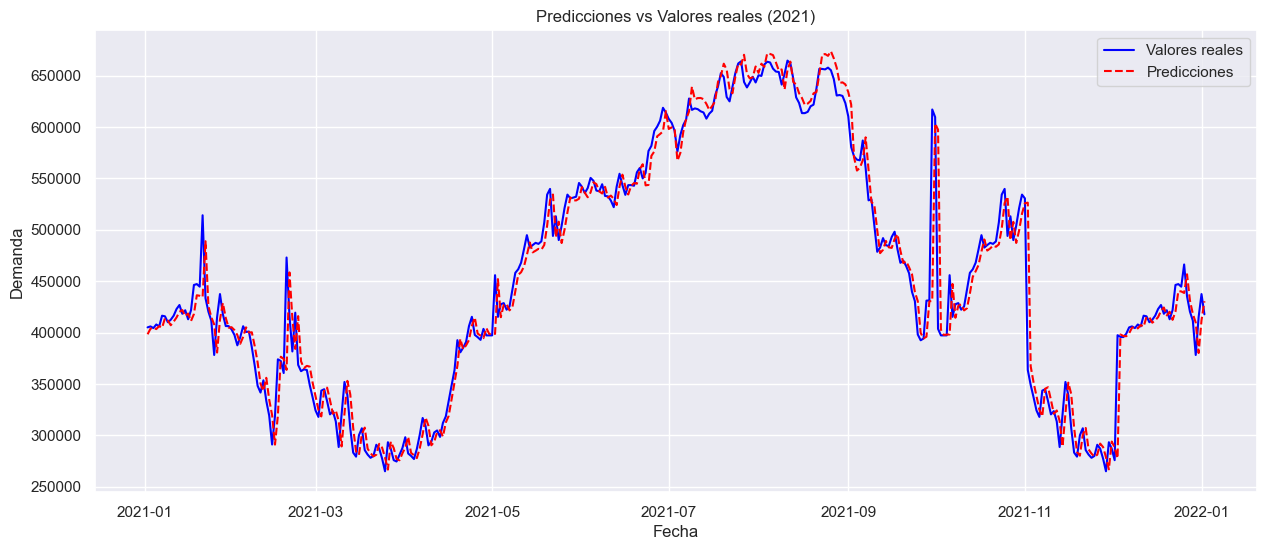

In [125]:
LSTMDemandaDiarioDosCaracteristicas(1, dataRNNdias)

    Cogiendo la semana anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 10s 57ms/step - loss: 0.1481 - val_loss: 0.0636
Epoch 2/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0184 - val_loss: 0.0293
Epoch 3/50
23/23 [==============================] - 0s 17ms/step - loss: 0.0091 - val_loss: 0.0119
Epoch 4/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 5/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0038 - val_loss: 0.0097
Epoch 6/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0092
Epoch 7/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 8/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0088
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0086
Epoch 10/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0085
Epoch 11

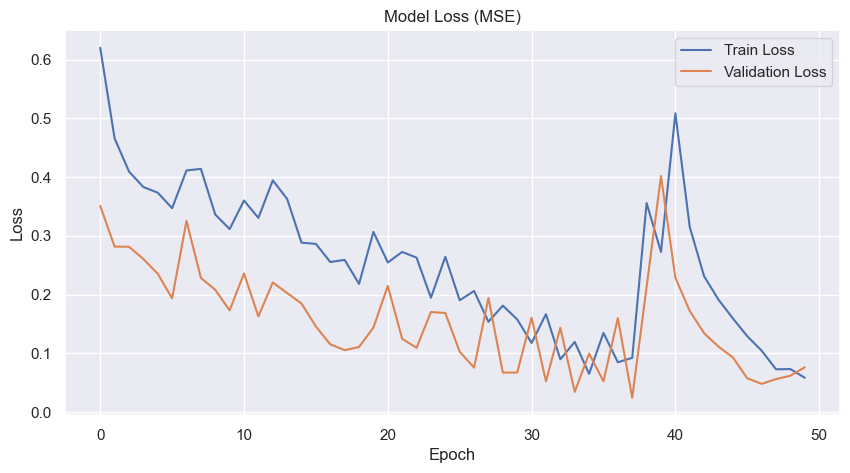

12/12 [==============================] - 0s 6ms/step
     Real Values   Predictions
0         415824  412868.68750
1         410048  414058.03125
2         412486  409748.03125
3         416401  412986.53125
4         422912  421932.06250
..           ...           ...
355       411592  432273.21875
356       378184  414575.31250
357       414996  391494.06250
358       437452  385115.90625
359       417780  402216.09375

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 21.67%


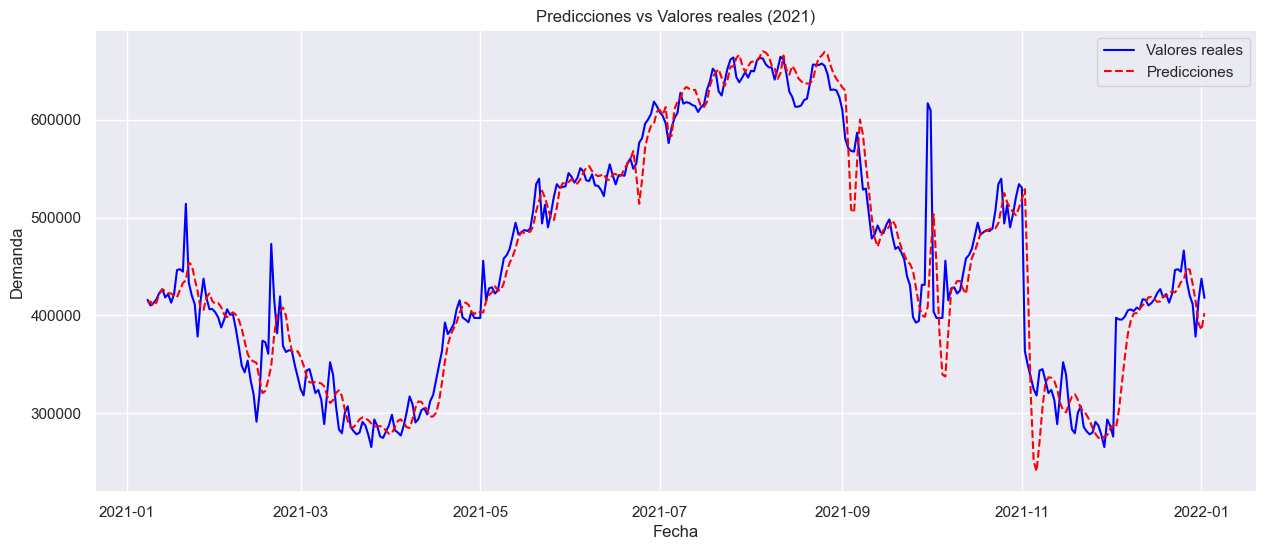

In [126]:
LSTMDemandaDiarioDosCaracteristicas(7, dataRNNdias)

    Cogiendo 30 dias anterior anterior para la prediccion

Epoch 1/50
22/22 [==============================] - 5s 54ms/step - loss: 0.1445 - val_loss: 0.0499
Epoch 2/50
22/22 [==============================] - 1s 34ms/step - loss: 0.0186 - val_loss: 0.0151
Epoch 3/50
22/22 [==============================] - 1s 29ms/step - loss: 0.0101 - val_loss: 0.0140
Epoch 4/50
22/22 [==============================] - 1s 28ms/step - loss: 0.0076 - val_loss: 0.0153
Epoch 5/50
22/22 [==============================] - 1s 32ms/step - loss: 0.0061 - val_loss: 0.0138
Epoch 6/50
22/22 [==============================] - 1s 36ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 7/50
22/22 [==============================] - 1s 36ms/step - loss: 0.0036 - val_loss: 0.0097
Epoch 8/50
22/22 [==============================] - 1s 36ms/step - loss: 0.0029 - val_loss: 0.0101
Epoch 9/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0027 - val_loss: 0.0098
Epoch 10/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 11/

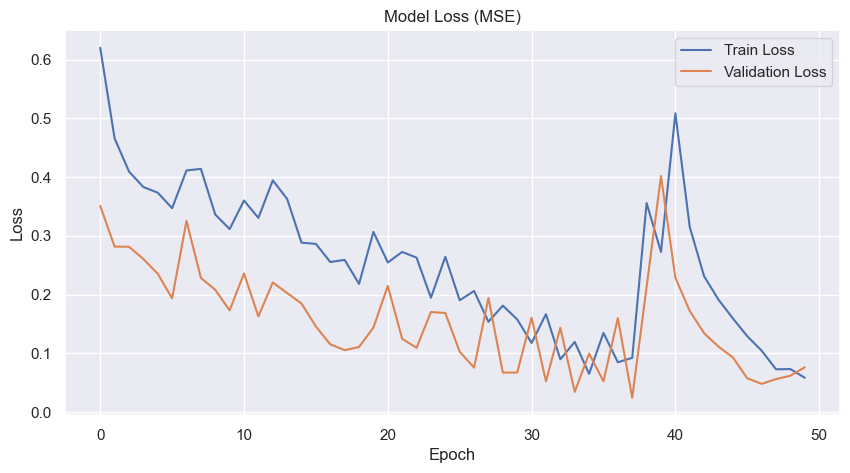

11/11 [==============================] - 0s 10ms/step
     Real Values   Predictions
0         403046  395565.03125
1         397671  390576.18750
2         387589  383930.37500
3         395473  375748.53125
4         406162  370930.53125
..           ...           ...
332       411592  438179.25000
333       378184  426026.90625
334       414996  406346.84375
335       437452  400329.68750
336       417780  408884.53125

[337 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 16.91%


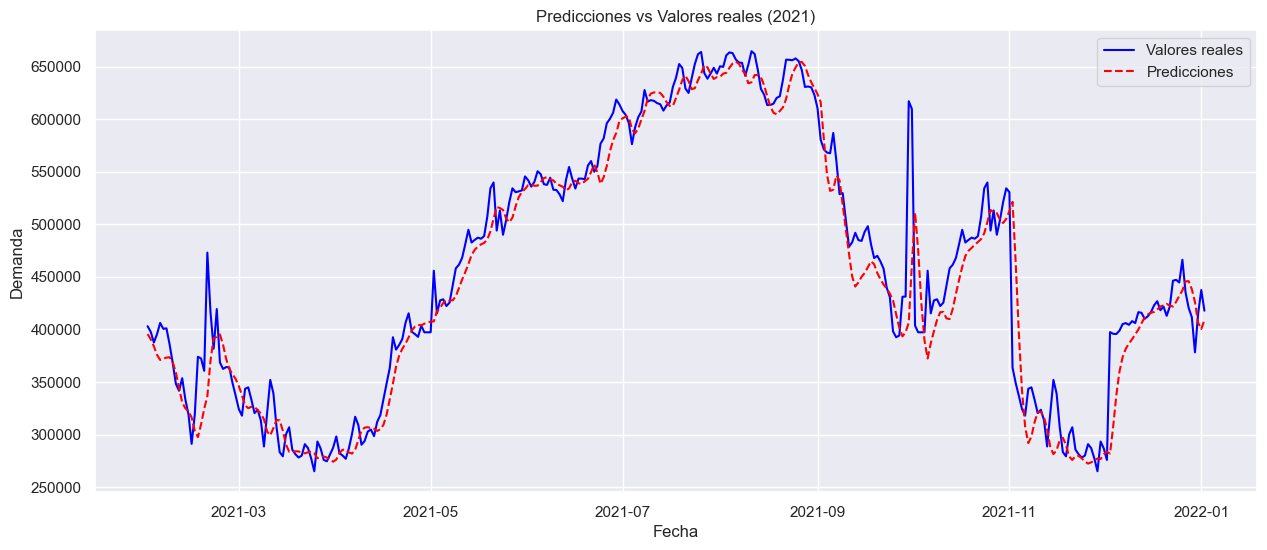

In [127]:
LSTMDemandaDiarioDosCaracteristicas(30, dataRNNdias)

### LSTM para predecir la produccion

In [129]:
def LSTMProduccionDiarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]
    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el dia anterior anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 6s 25ms/step - loss: 0.3600 - val_loss: 0.3498
Epoch 2/50
23/23 [==============================] - 0s 9ms/step - loss: 0.2686 - val_loss: 0.2194
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1328 - val_loss: 0.0501
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0257 - val_loss: 0.0281
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0155 - val_loss: 0.0162
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.0164
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0145
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0140
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0077 - val_loss: 0.0130
Epoch 10/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0128
Epoch 11/50
23/23

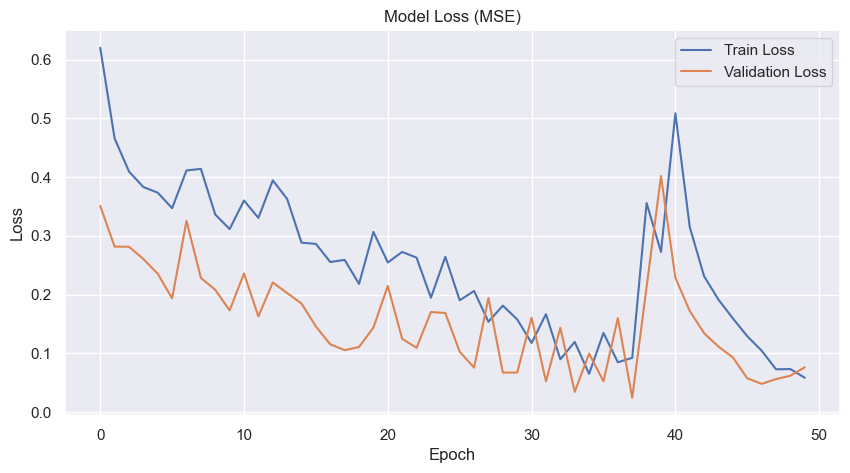

12/12 [==============================] - 1s 3ms/step
     Real Values    Predictions
0         253488  250484.125000
1         258897  253644.359375
2         259925  258650.593750
3         256563  259665.312500
4         256305  256410.156250
..           ...            ...
361       261122  278036.312500
362       248905  260582.656250
363       257533  250223.187500
364       272710  257092.468750
365       277922  270995.375000

[366 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 29.78%


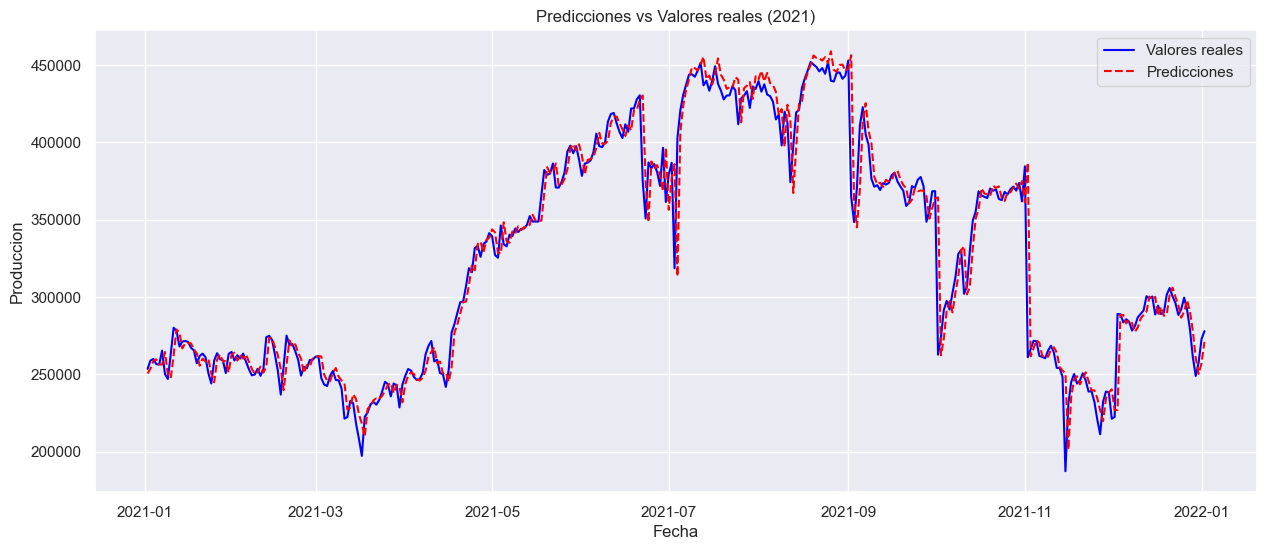

In [130]:
LSTMProduccionDiarioDosCaracteristicas(1, dataRNNdias)

    Cogiendo 7 dias anterior anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 4s 40ms/step - loss: 0.2096 - val_loss: 0.0357
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.0150
Epoch 3/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0090 - val_loss: 0.0151
Epoch 4/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0075 - val_loss: 0.0160
Epoch 5/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0065 - val_loss: 0.0144
Epoch 6/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0124
Epoch 7/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0106
Epoch 8/50
23/23 [==============================] - 0s 17ms/step - loss: 0.0045 - val_loss: 0.0101
Epoch 9/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 10/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0098
Epoch 11/

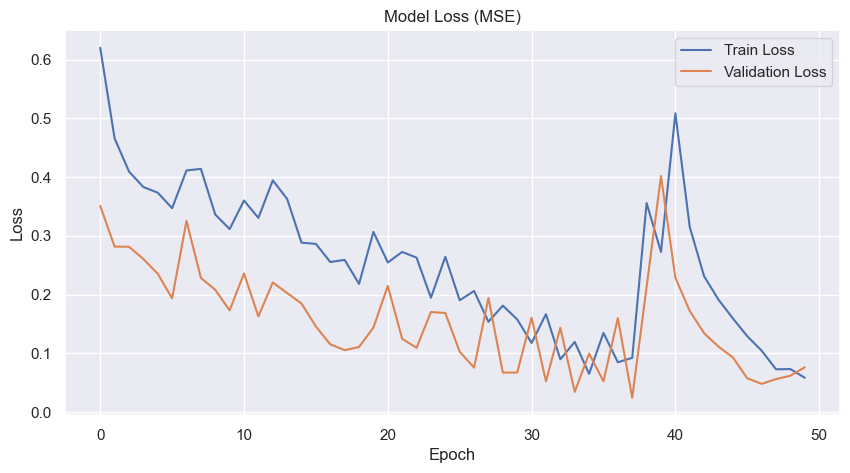

12/12 [==============================] - 1s 8ms/step
     Real Values    Predictions
0         250163  263154.750000
1         246979  262768.875000
2         263122  259539.562500
3         280107  259510.296875
4         278105  264792.000000
..           ...            ...
355       261122  291734.468750
356       248905  278830.281250
357       257533  264219.875000
358       272710  256784.906250
359       277922  258627.937500

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 20.56%


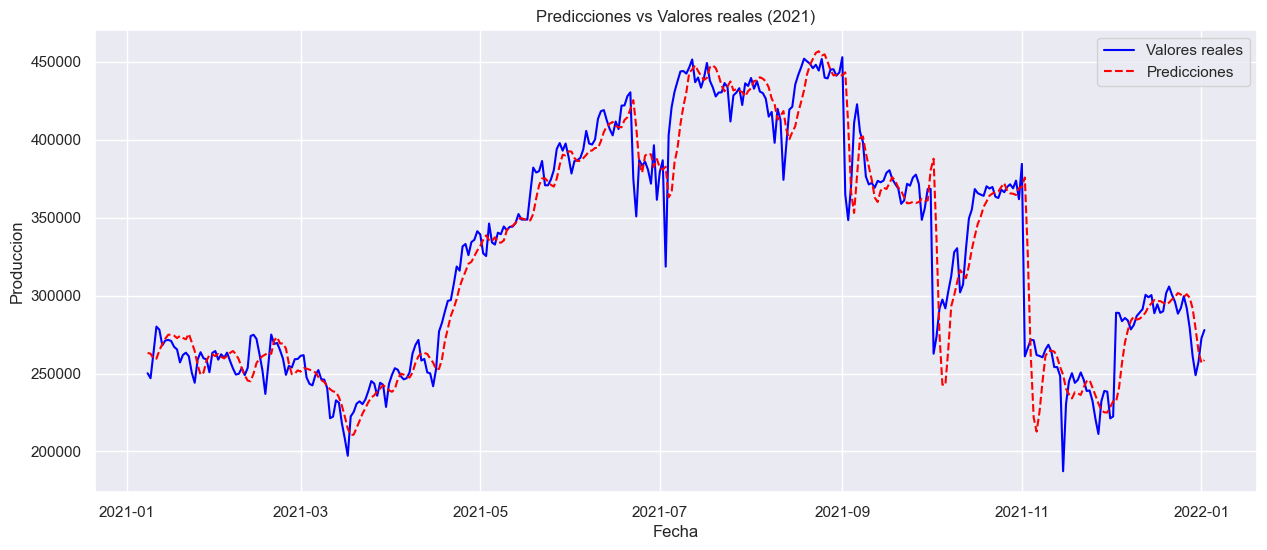

In [131]:
LSTMProduccionDiarioDosCaracteristicas(7, dataRNNdias)

    Cogiendo 30 dias anterior anterior para la prediccion

Epoch 1/50
22/22 [==============================] - 5s 50ms/step - loss: 0.1660 - val_loss: 0.0495
Epoch 2/50
22/22 [==============================] - 1s 31ms/step - loss: 0.0173 - val_loss: 0.0352
Epoch 3/50
22/22 [==============================] - 1s 31ms/step - loss: 0.0112 - val_loss: 0.0199
Epoch 4/50
22/22 [==============================] - 1s 31ms/step - loss: 0.0090 - val_loss: 0.0161
Epoch 5/50
22/22 [==============================] - 1s 36ms/step - loss: 0.0066 - val_loss: 0.0123
Epoch 6/50
22/22 [==============================] - 2s 75ms/step - loss: 0.0048 - val_loss: 0.0119
Epoch 7/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0039 - val_loss: 0.0117
Epoch 8/50
22/22 [==============================] - 1s 34ms/step - loss: 0.0037 - val_loss: 0.0115
Epoch 9/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0036 - val_loss: 0.0112
Epoch 10/50
22/22 [==============================] - 1s 33ms/step - loss: 0.0036 - val_loss: 0.0114
Epoch 11/

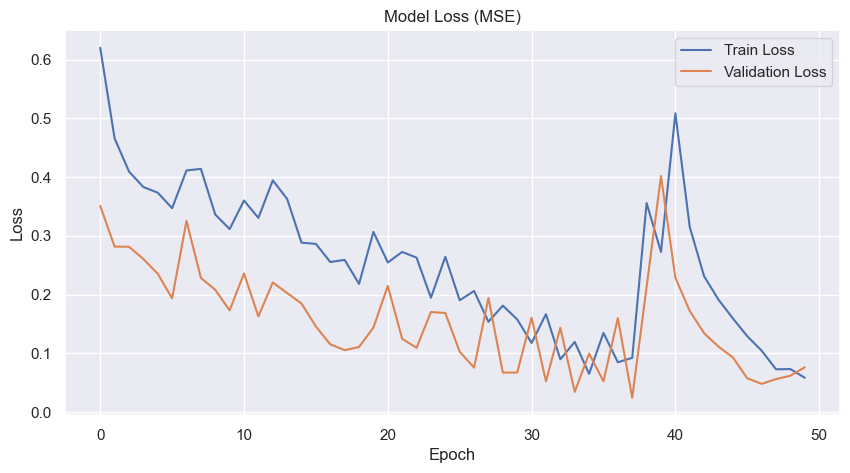

11/11 [==============================] - 1s 15ms/step
     Real Values    Predictions
0         264439  260116.875000
1         258896  260247.671875
2         262317  260003.953125
3         260137  259667.640625
4         263383  259395.234375
..           ...            ...
332       261122  301047.875000
333       248905  296562.218750
334       257533  289440.281250
335       272710  283634.937500
336       277922  280872.187500

[337 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 19.88%


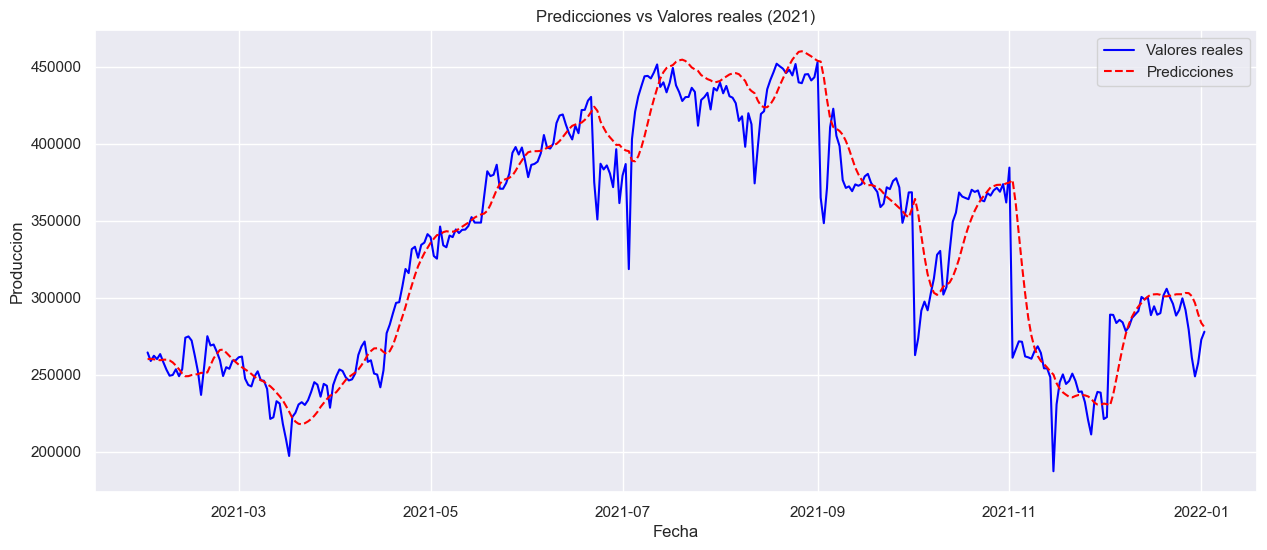

In [132]:
LSTMProduccionDiarioDosCaracteristicas(30, dataRNNdias)

# LSTM por meses con ambas características

Ahora repetimos el proceso pero con algunos cambios y la frecuencia por meses

In [133]:
dataMes= data.resample('m').sum()
dataMes

Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12224975     8528453

### LSTM para predecir la demanda

In [134]:
def LSTMDemandaMensualDosCaracteristicas(time_steps, data):
    
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]
    

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

   
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()


    Cogiendo 1 mes anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2696 - val_loss: 0.4517
Epoch 2/50
1/1 [==============================] - 0s 87ms/step - loss: 0.2671 - val_loss: 0.4482
Epoch 3/50
1/1 [==============================] - 0s 39ms/step - loss: 0.2646 - val_loss: 0.4448
Epoch 4/50
1/1 [==============================] - 0s 43ms/step - loss: 0.2622 - val_loss: 0.4414
Epoch 5/50
1/1 [==============================] - 0s 41ms/step - loss: 0.2598 - val_loss: 0.4380
Epoch 6/50
1/1 [==============================] - 0s 48ms/step - loss: 0.2574 - val_loss: 0.4346
Epoch 7/50
1/1 [==============================] - 0s 84ms/step - loss: 0.2550 - val_loss: 0.4312
Epoch 8/50
1/1 [==============================] - 0s 52ms/step - loss: 0.2526 - val_loss: 0.4277
Epoch 9/50
1/1 [==============================] - 0s 118ms/step - loss: 0.2502 - val_loss: 0.4243
Epoch 10/50
1/1 [==============================] - 0s 78ms/step - loss: 0.2478 - val_loss: 0.4207
Epoch 11/50
1/1 [=============

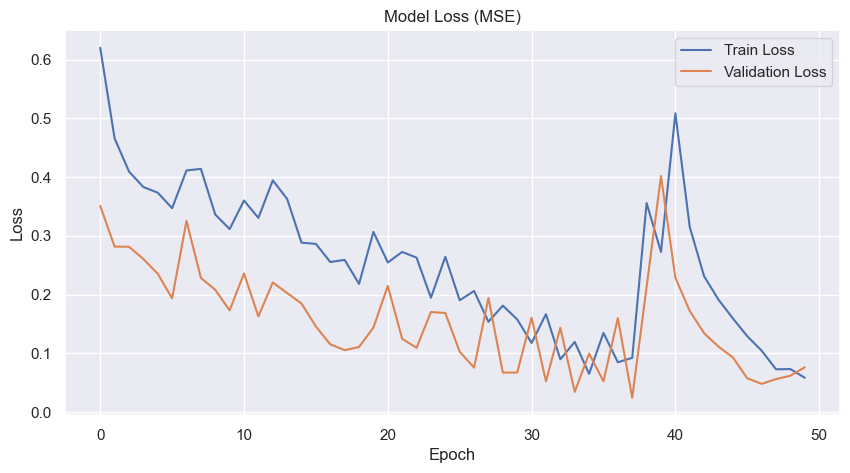

1/1 [==============================] - 0s 446ms/step
    Real Values  Predictions
0      10390139   10002846.0
1       9342708    9732250.0
2      10272893    9675353.0
3      14984538    9867921.0
4      16670675   10556593.0
5      19392643   10799067.0
6      19935514   11232495.0
7      14896197   11306938.0
8      14652679   10571501.0
9       9516929   10449290.0
10     12224975    9712210.0
Accuracy basado en un umbral del 1.0%: 0.00%


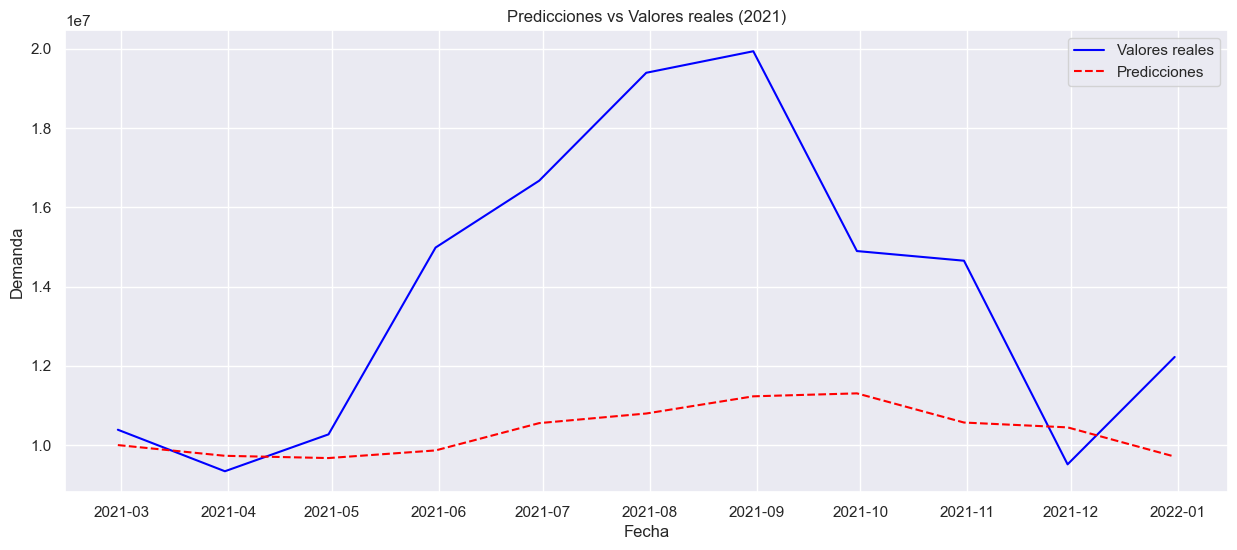

In [135]:
LSTMDemandaMensualDosCaracteristicas(1, dataMes)

    Cogiendo 6 meses anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.3077 - val_loss: 0.5900
Epoch 2/50
1/1 [==============================] - 0s 51ms/step - loss: 0.2991 - val_loss: 0.5762
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2910 - val_loss: 0.5629
Epoch 4/50
1/1 [==============================] - 0s 48ms/step - loss: 0.2829 - val_loss: 0.5498
Epoch 5/50
1/1 [==============================] - 0s 48ms/step - loss: 0.2751 - val_loss: 0.5364
Epoch 6/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2671 - val_loss: 0.5222
Epoch 7/50
1/1 [==============================] - 0s 48ms/step - loss: 0.2589 - val_loss: 0.5076
Epoch 8/50
1/1 [==============================] - 0s 44ms/step - loss: 0.2506 - val_loss: 0.4927
Epoch 9/50
1/1 [==============================] - 0s 46ms/step - loss: 0.2422 - val_loss: 0.4773
Epoch 10/50
1/1 [==============================] - 0s 45ms/step - loss: 0.2338 - val_loss: 0.4618
Epoch 11/50
1/1 [==============

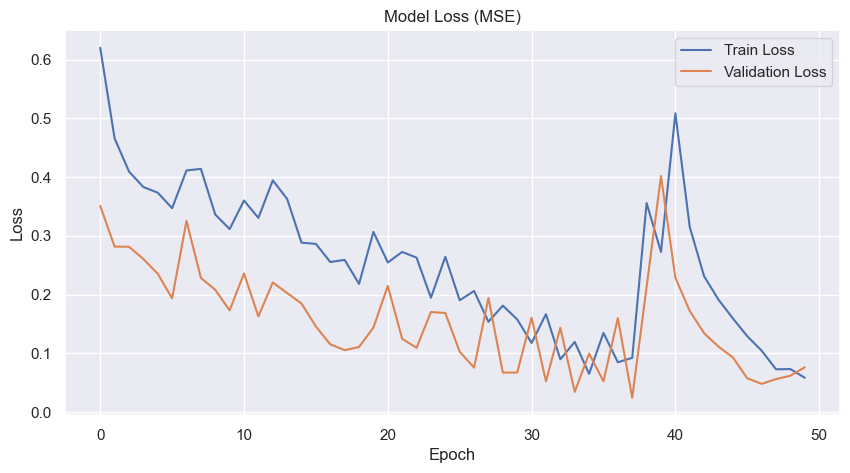

1/1 [==============================] - 0s 324ms/step
   Real Values  Predictions
0     19392643   12614182.0
1     19935514   12710025.0
2     14896197   12911771.0
3     14652679   13085748.0
4      9516929   13282825.0
5     12224975   13266281.0
Accuracy basado en un umbral del 1.0%: 0.00%


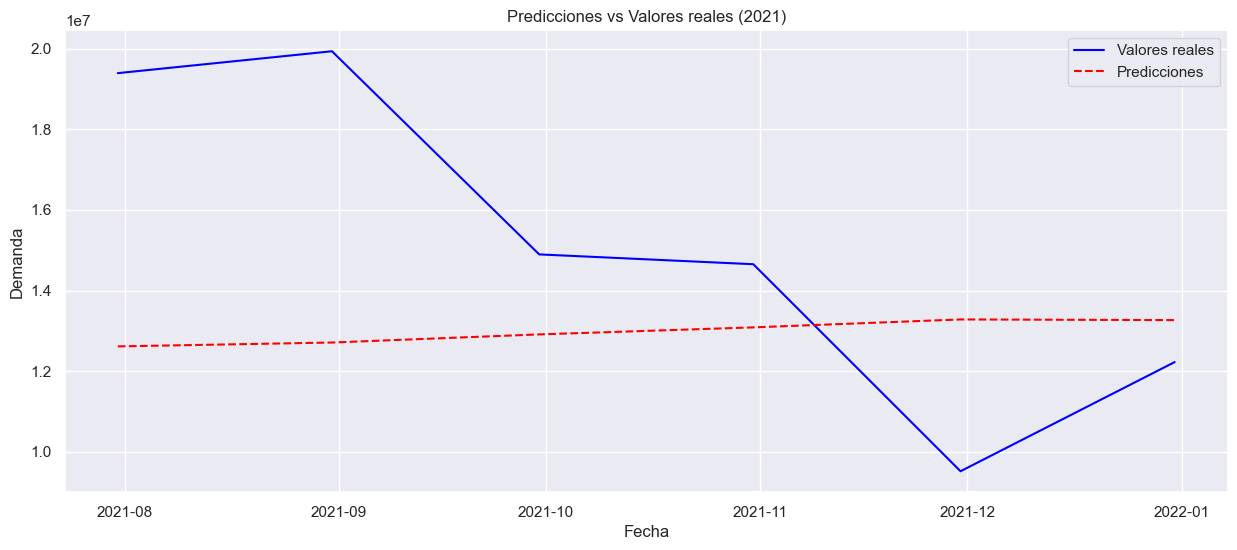

In [136]:
LSTMDemandaMensualDosCaracteristicas(6, dataMes)

### LSTM para predecir la produccion

In [137]:
def LSTMProduccionMensualDosCaracteristicas(time_steps, data):
    
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]
    

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

   
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()


    Cogiendo el mes anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.3448 - val_loss: 0.4025
Epoch 2/50
1/1 [==============================] - 0s 43ms/step - loss: 0.3414 - val_loss: 0.3987
Epoch 3/50
1/1 [==============================] - 0s 49ms/step - loss: 0.3382 - val_loss: 0.3950
Epoch 4/50
1/1 [==============================] - 0s 43ms/step - loss: 0.3351 - val_loss: 0.3915
Epoch 5/50
1/1 [==============================] - 0s 41ms/step - loss: 0.3320 - val_loss: 0.3879
Epoch 6/50
1/1 [==============================] - 0s 40ms/step - loss: 0.3290 - val_loss: 0.3844
Epoch 7/50
1/1 [==============================] - 0s 42ms/step - loss: 0.3260 - val_loss: 0.3810
Epoch 8/50
1/1 [==============================] - 0s 43ms/step - loss: 0.3231 - val_loss: 0.3775
Epoch 9/50
1/1 [==============================] - 0s 41ms/step - loss: 0.3202 - val_loss: 0.3741
Epoch 10/50
1/1 [==============================] - 0s 40ms/step - loss: 0.3173 - val_loss: 0.3707
Epoch 11/50
1/1 [==============

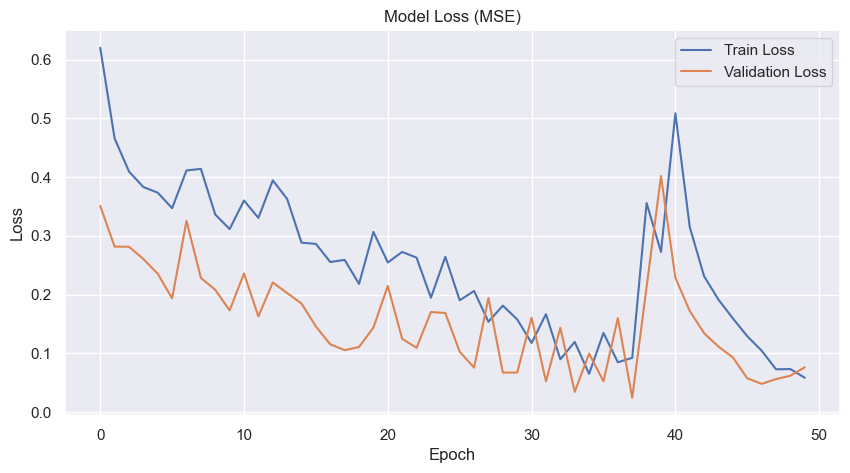

1/1 [==============================] - 1s 1s/step
    Real Values  Predictions
0       7253635    8189727.5
1       7317690    8003723.0
2       8450198    7971046.0
3      11166675    8116787.5
4      11921123    8617774.0
5      13231958    8793217.0
6      13392505    9110752.0
7      11319400    9163985.0
8      10581169    8631362.0
9       7544319    8534052.0
10      8528453    7999144.5
Accuracy basado en un umbral del 1.0%: 0.00%


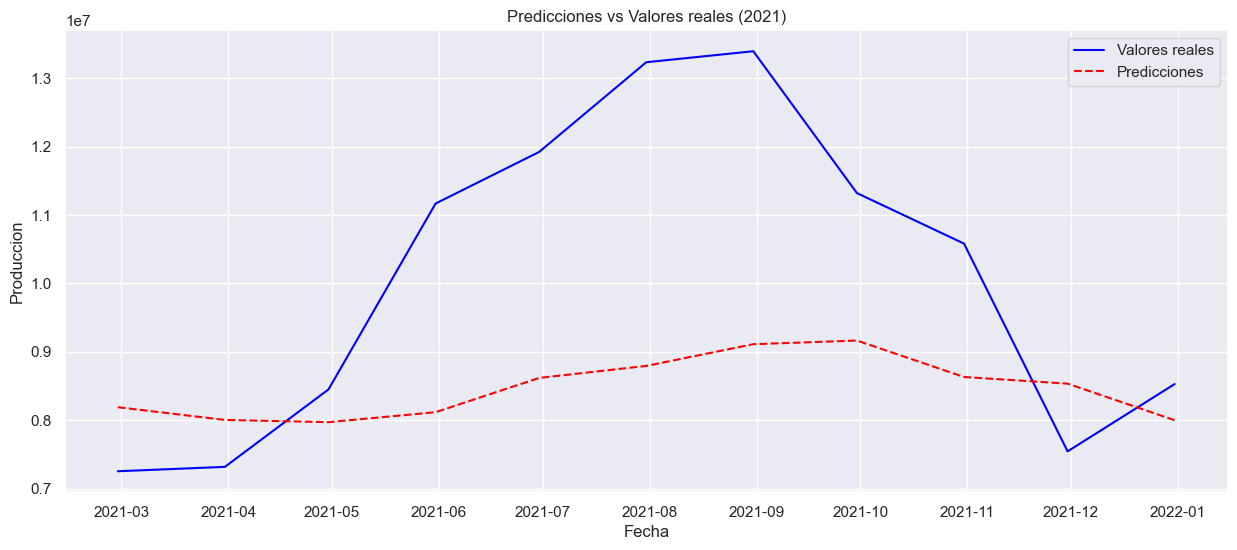

In [138]:
LSTMProduccionMensualDosCaracteristicas(1, dataMes)

    Cogiendo 6 meses anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.3885 - val_loss: 0.5265
Epoch 2/50
1/1 [==============================] - 0s 47ms/step - loss: 0.3757 - val_loss: 0.5103
Epoch 3/50
1/1 [==============================] - 0s 51ms/step - loss: 0.3643 - val_loss: 0.4944
Epoch 4/50
1/1 [==============================] - 0s 64ms/step - loss: 0.3533 - val_loss: 0.4787
Epoch 5/50
1/1 [==============================] - 0s 59ms/step - loss: 0.3424 - val_loss: 0.4631
Epoch 6/50
1/1 [==============================] - 0s 54ms/step - loss: 0.3315 - val_loss: 0.4476
Epoch 7/50
1/1 [==============================] - 0s 49ms/step - loss: 0.3207 - val_loss: 0.4323
Epoch 8/50
1/1 [==============================] - 0s 41ms/step - loss: 0.3099 - val_loss: 0.4170
Epoch 9/50
1/1 [==============================] - 0s 42ms/step - loss: 0.2991 - val_loss: 0.4018
Epoch 10/50
1/1 [==============================] - 0s 44ms/step - loss: 0.2882 - val_loss: 0.3862
Epoch 11/50
1/1 [==============

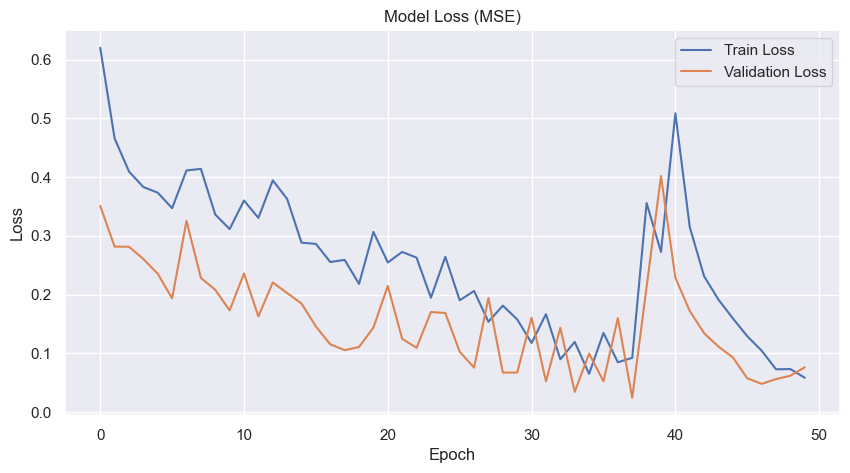

1/1 [==============================] - 0s 470ms/step
   Real Values  Predictions
0     13231958    9779519.0
1     13392505    9907268.0
2     11319400   10161716.0
3     10581169   10369821.0
4      7544319   10517622.0
5      8528453   10414048.0
Accuracy basado en un umbral del 1.0%: 0.00%


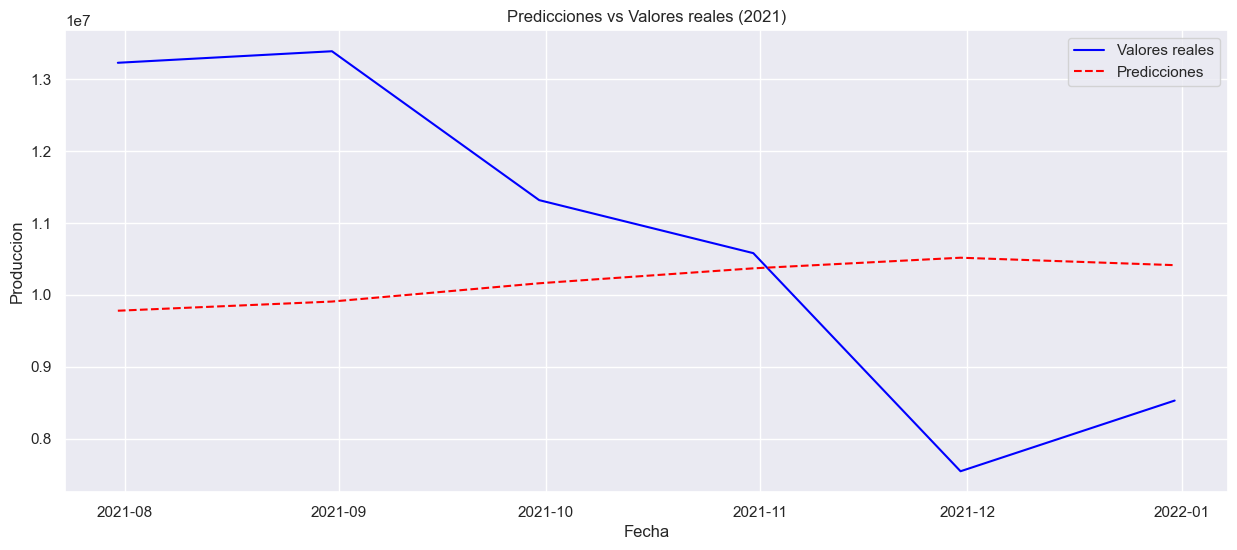

In [139]:
LSTMProduccionMensualDosCaracteristicas(6, dataMes)

# LSTM por horas con ambas características

In [140]:
dataHoraDemandaLSTM = pd.read_csv("datosHorarios.csv")

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemandaLSTM), freq='H')
dataHoraDemandaLSTM.index = date_hour_index

In [141]:
dataHoraDemandaLSTM

Produccion  Hours  Demanda
2019-01-01 00:00:00       10494      1    11479
2019-01-01 01:00:00        9914      2    10595
2019-01-01 02:00:00        9452      3    10132
2019-01-01 03:00:00        9334      4    10437
2019-01-01 04:00:00        9832      5    11576
...                         ...    ...      ...
2022-01-02 19:00:00       12754     20    19725
2022-01-02 20:00:00       12639     21    18376
2022-01-02 21:00:00       12320     22    17323
2022-01-02 22:00:00       11802     23    16220
2022-01-02 23:00:00       11000     24    15341

[26352 rows x 3 columns]

### LSTM para predecir la demanda

In [143]:
def LSTMDemandaHorarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()



    Cogiendo la hora anterior para la prediccion

Epoch 1/50
548/548 [==============================] - 9s 8ms/step - loss: 0.0334 - val_loss: 0.0015
Epoch 2/50
548/548 [==============================] - 4s 7ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/50
548/548 [==============================] - 6s 11ms/step - loss: 0.0011 - val_loss: 9.5386e-04
Epoch 4/50
548/548 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 9.3808e-04
Epoch 5/50
548/548 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 9.3301e-04
Epoch 6/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 9.5602e-04
Epoch 8/50
548/548 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
548/548 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 9.3010e-04
Epoch 10/50
548/548 [==============================] - 2s 4ms/step - loss: 0.00

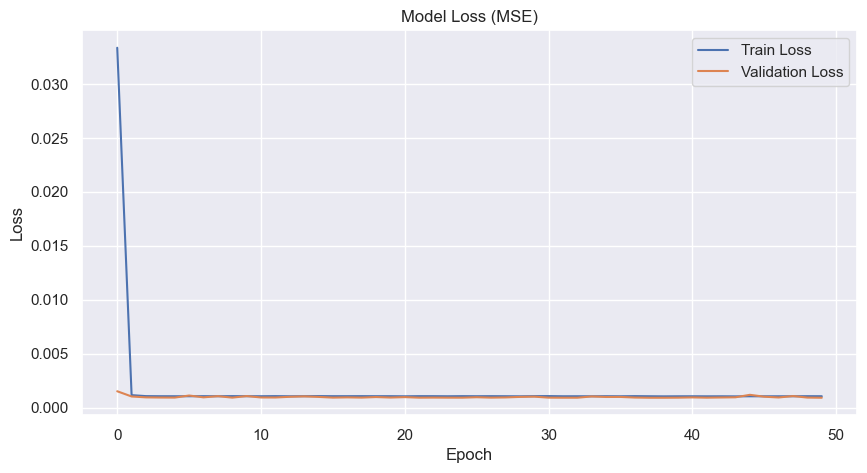

276/276 [==============================] - 1s 2ms/step
      Real Values   Predictions
0            9865  10084.508789
1            9792   9879.208008
2            9938   9807.740234
3           10247   9940.411133
4           10328  10229.622070
...           ...           ...
8801        12754  12857.423828
8802        12639  12730.447266
8803        12320  12589.025391
8804        11802  12268.636719
8805        11000  11757.991211

[8806 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 51.03%


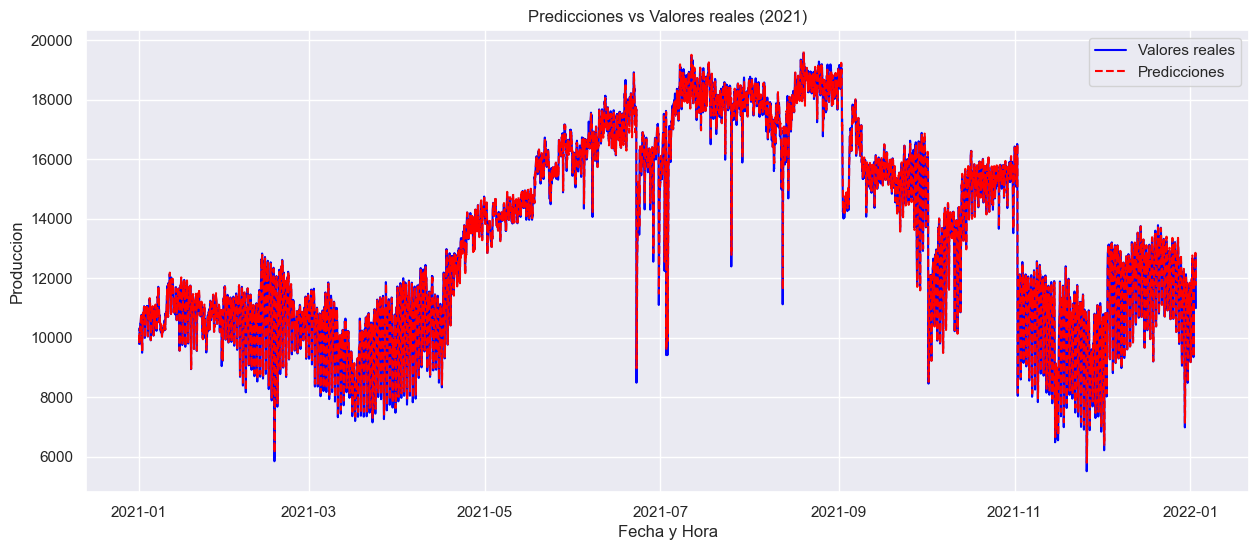

In [144]:
LSTMDemandaHorarioDosCaracteristicas(1, dataHoraDemandaLSTM)

    Cogiendo 24 horas anterior para la prediccion

Epoch 1/50
547/547 [==============================] - 18s 27ms/step - loss: 0.0186 - val_loss: 0.0023
Epoch 2/50
547/547 [==============================] - 14s 26ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/50
547/547 [==============================] - 14s 26ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 4/50
547/547 [==============================] - 14s 25ms/step - loss: 8.0389e-04 - val_loss: 9.9219e-04
Epoch 5/50
547/547 [==============================] - 14s 26ms/step - loss: 6.1510e-04 - val_loss: 9.1467e-04
Epoch 6/50
547/547 [==============================] - 14s 26ms/step - loss: 5.1967e-04 - val_loss: 6.5444e-04
Epoch 7/50
547/547 [==============================] - 14s 25ms/step - loss: 4.7126e-04 - val_loss: 7.0849e-04
Epoch 8/50
547/547 [==============================] - 14s 26ms/step - loss: 4.5538e-04 - val_loss: 6.5096e-04
Epoch 9/50
547/547 [==============================] - 14s 26ms/step - loss: 4.6269e-04 - val_loss: 6.0805e-04
Epoch 10/50
547/547 [=============

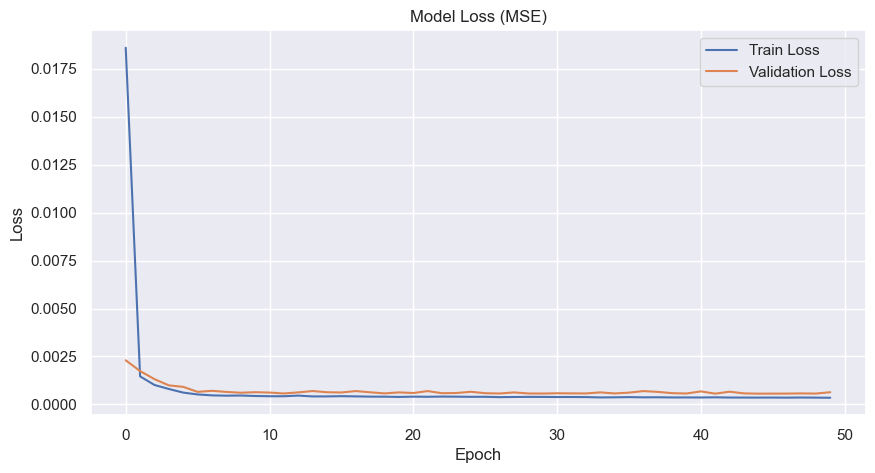

275/275 [==============================] - 4s 11ms/step
      Real Values   Predictions
0           10025   9522.847656
1            9612  10062.722656
2            9498   9554.325195
3            9814   9762.817383
4           10186  10259.051758
...           ...           ...
8778        12754  12816.935547
8779        12639  12648.751953
8780        12320  12497.911133
8781        11802  12099.983398
8782        11000  11441.865234

[8783 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 48.43%


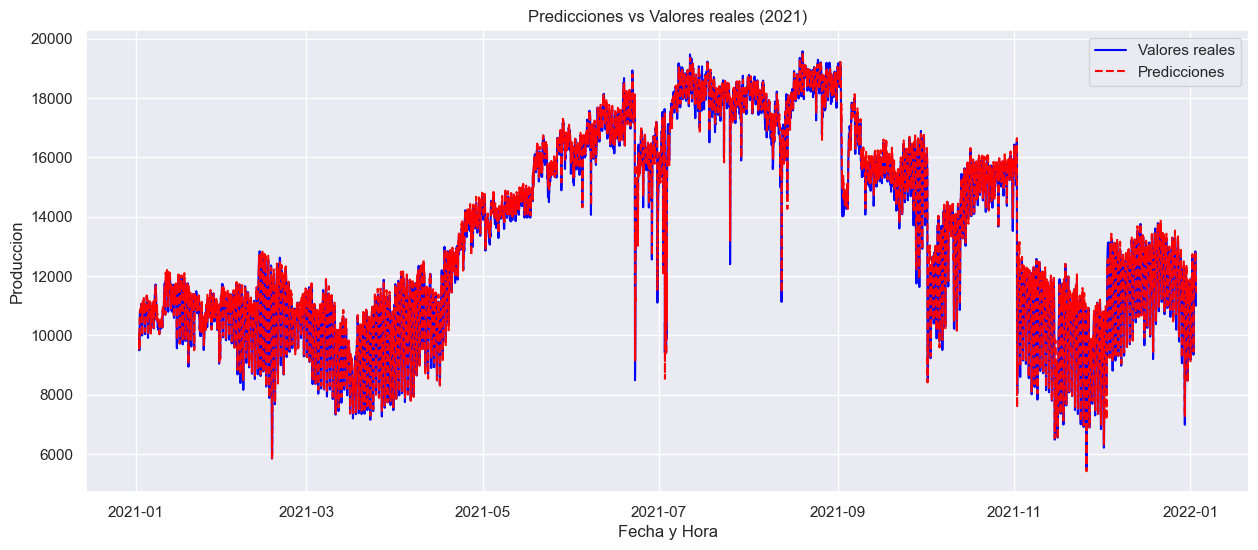

In [145]:
LSTMDemandaHorarioDosCaracteristicas(24, dataHoraDemandaLSTM)

    Cogiendo una semana anterior para la prediccion

In [146]:
LSTMDemandaHorarioDosCaracteristicas(168, dataHoraDemandaLSTM)

Epoch 1/50
140/543 [======>.......................] - ETA: 1:18 - loss: 0.0449

KeyboardInterrupt: 

### LSTM por horas para predecir la produccion

In [147]:
dataHoraProduccionLSTM = pd.read_csv("datosHorarios.csv")

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraProduccionLSTM), freq='H')
dataHoraProduccionLSTM.index = date_hour_index

In [148]:
dataHoraProduccionLSTM

Produccion  Hours  Demanda
2019-01-01 00:00:00       10494      1    11479
2019-01-01 01:00:00        9914      2    10595
2019-01-01 02:00:00        9452      3    10132
2019-01-01 03:00:00        9334      4    10437
2019-01-01 04:00:00        9832      5    11576
...                         ...    ...      ...
2022-01-02 19:00:00       12754     20    19725
2022-01-02 20:00:00       12639     21    18376
2022-01-02 21:00:00       12320     22    17323
2022-01-02 22:00:00       11802     23    16220
2022-01-02 23:00:00       11000     24    15341

[26352 rows x 3 columns]

In [149]:


def LSTMProduccionHorarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01  # Se han echo varias pruebas y se coge finalmente el 1% del valor real

    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo la hora anterior para la prediccion

Epoch 1/50
548/548 [==============================] - 10s 10ms/step - loss: 0.0412 - val_loss: 0.0014
Epoch 2/50
548/548 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 9.8948e-04
Epoch 3/50
548/548 [==============================] - 4s 8ms/step - loss: 0.0011 - val_loss: 9.4484e-04
Epoch 4/50
548/548 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 9.3974e-04
Epoch 5/50
548/548 [==============================] - 4s 6ms/step - loss: 0.0011 - val_loss: 9.6081e-04
Epoch 6/50
548/548 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
548/548 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 9.5790e-04
Epoch 8/50
548/548 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 9.8645e-04
Epoch 9/50
548/548 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 9.3344e-04
Epoch 10/50
548/548 [==============================] - 4s 8ms/step - l

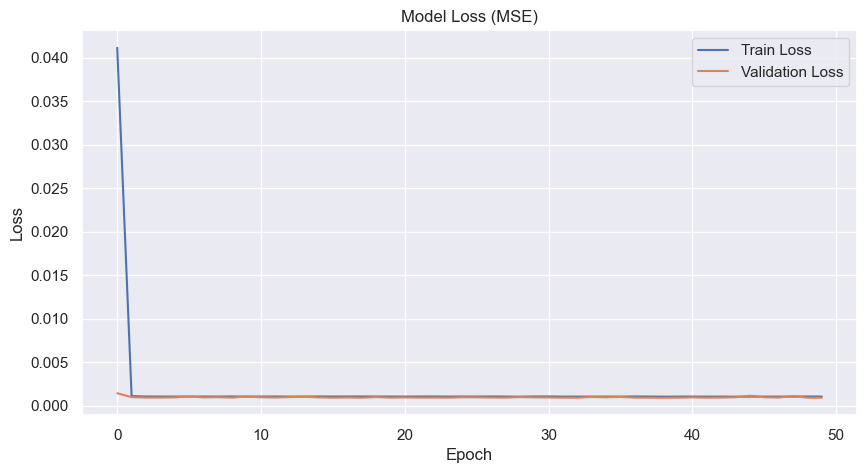

276/276 [==============================] - 1s 4ms/step
      Real Values   Predictions
0            9865  10081.946289
1            9792   9872.325195
2            9938   9801.691406
3           10247   9938.781250
4           10328  10235.141602
...           ...           ...
8801        12754  12801.404297
8802        12639  12710.947266
8803        12320  12585.017578
8804        11802  12259.305664
8805        11000  11746.782227

[8806 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 50.92%


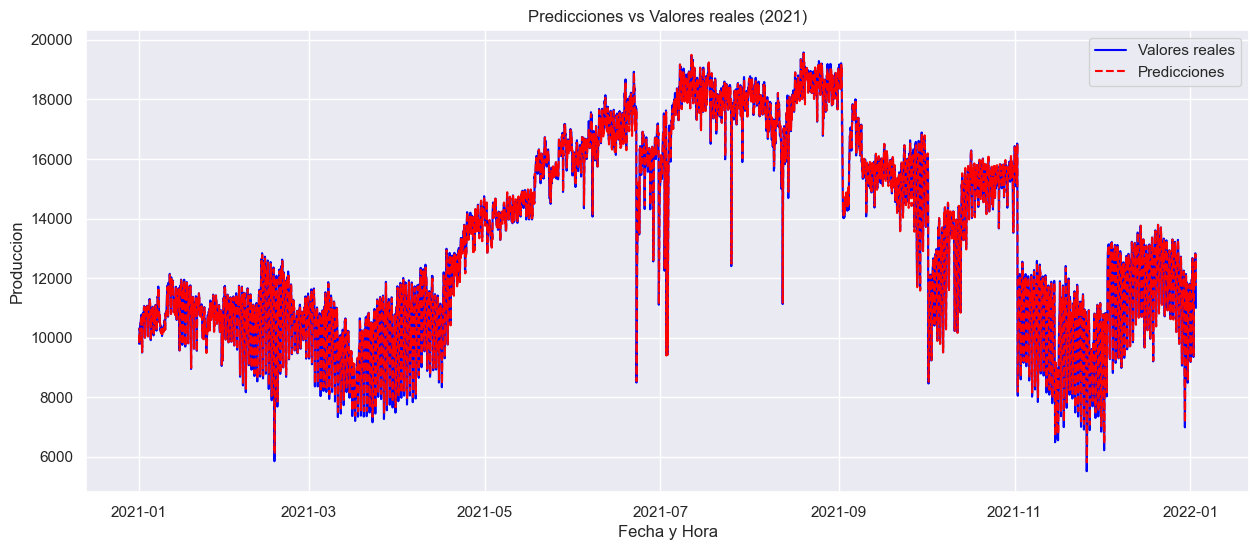

In [150]:
LSTMProduccionHorarioDosCaracteristicas(1, dataHoraProduccionLSTM)

    Cogiendo el dia anterior para la prediccion

In [ ]:
LSTMProduccionHorarioDosCaracteristicas(24, dataHoraProduccionLSTM)

    Cogiendo una semana anterior para la prediccion

In [ ]:
LSTMProduccionHorarioDosCaracteristicas(168, dataHoraProduccionLSTM)

# LSTM por días para predecir la demanda solo con la demanda

In [151]:
dataRNNdiasDemanda = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasDemanda), freq='D')
dataRNNdiasDemanda.index = date_index

Epoch 1/50
22/22 [==============================] - 9s 131ms/step - loss: 0.1226 - val_loss: 0.0655
Epoch 2/50
22/22 [==============================] - 1s 62ms/step - loss: 0.0164 - val_loss: 0.0224
Epoch 3/50
22/22 [==============================] - 2s 70ms/step - loss: 0.0094 - val_loss: 0.0176
Epoch 4/50
22/22 [==============================] - 3s 130ms/step - loss: 0.0069 - val_loss: 0.0131
Epoch 5/50
22/22 [==============================] - 2s 89ms/step - loss: 0.0047 - val_loss: 0.0235
Epoch 6/50
22/22 [==============================] - 1s 64ms/step - loss: 0.0048 - val_loss: 0.0103
Epoch 7/50
22/22 [==============================] - 2s 76ms/step - loss: 0.0035 - val_loss: 0.0114
Epoch 8/50
22/22 [==============================] - 2s 74ms/step - loss: 0.0033 - val_loss: 0.0109
Epoch 9/50
22/22 [==============================] - 2s 89ms/step - loss: 0.0029 - val_loss: 0.0115
Epoch 10/50
22/22 [==============================] - 2s 94ms/step - loss: 0.0028 - val_loss: 0.0105
Epoch 1

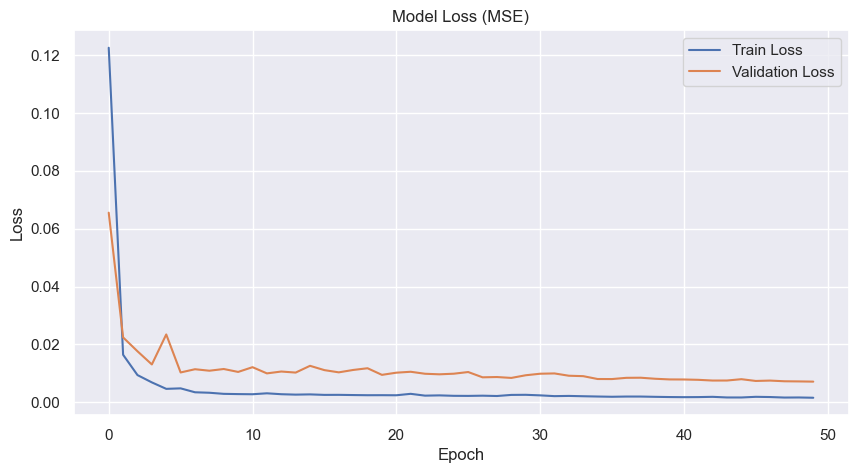

11/11 [==============================] - 1s 23ms/step
     Real Values    Predictions
0         403046  409934.953241
1         397671  406034.853838
2         387589  401628.467606
3         395473  395660.997143
4         406162  391611.323107
..           ...            ...
330       435243  452311.938291
331       420410  454033.486806
332       411592  450340.138559
333       378184  442770.168062
334       414996  427387.540059

[335 rows x 2 columns]


In [163]:
demand = dataRNNdiasDemanda[['Demanda']]
train_data = demand.loc['2019-01-01':'2020-12-31']
val_data = demand.loc['2021-01-01':'2021-12-31']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
look_back=30
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)


X_train, y_train = prepare_data(train_scaled, look_back=look_back)
X_val, y_val = prepare_data(val_scaled, look_back=look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[look_back:].values, 'Predictions': predictions})

print(comparison)



In [164]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real

correct_predictions = np.abs(predictions - val_data['Demanda'].iloc[look_back:].values) <= threshold * val_data['Demanda'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


 1/11 [=>............................] - ETA: 0s

11/11 [==============================] - 0s 23ms/step
Accuracy basado en un umbral del 1.0%: 18.21%


 1/11 [=>............................] - ETA: 0s

11/11 [==============================] - 0s 27ms/step


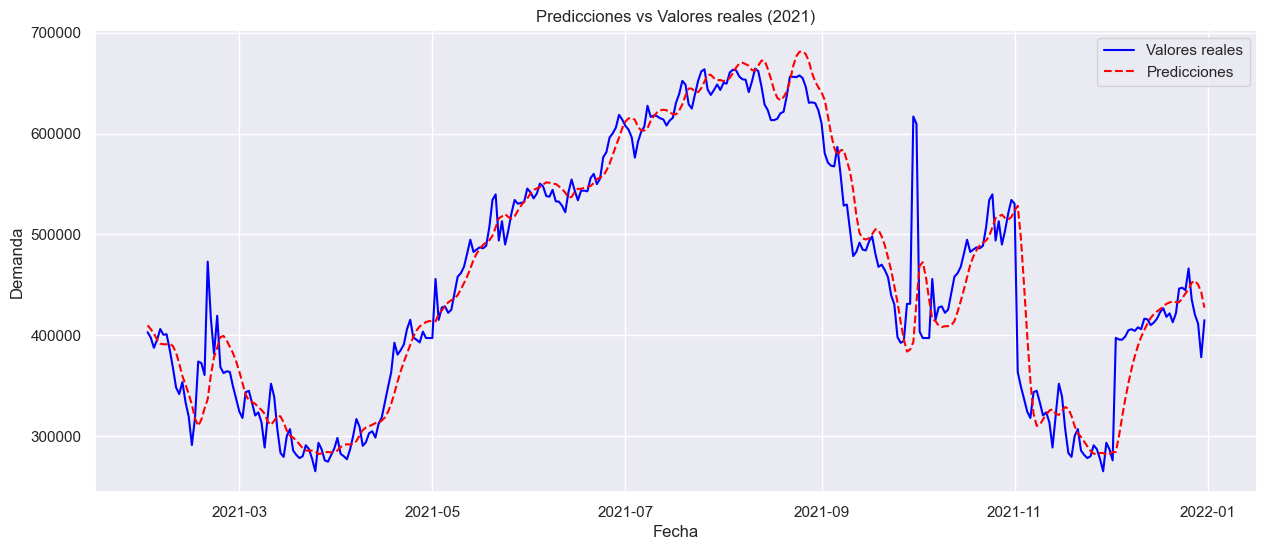

In [165]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]

plt.figure(figsize=(15, 6))

plt.plot(val_data.index[look_back:], val_data['Demanda'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


## LSTM por días para predecir la produccion solo con la produccion

In [166]:
dataRNNdiasProduccion = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasProduccion), freq='D')
dataRNNdiasProduccion.index = date_index

Epoch 1/50
22/22 [==============================] - 8s 94ms/step - loss: 0.1312 - val_loss: 0.0165
Epoch 2/50
22/22 [==============================] - 1s 56ms/step - loss: 0.0126 - val_loss: 0.0152
Epoch 3/50
22/22 [==============================] - 1s 67ms/step - loss: 0.0080 - val_loss: 0.0144
Epoch 4/50
22/22 [==============================] - 2s 74ms/step - loss: 0.0070 - val_loss: 0.0138
Epoch 5/50
22/22 [==============================] - 2s 87ms/step - loss: 0.0061 - val_loss: 0.0130
Epoch 6/50
22/22 [==============================] - 1s 51ms/step - loss: 0.0055 - val_loss: 0.0136
Epoch 7/50
22/22 [==============================] - 1s 54ms/step - loss: 0.0052 - val_loss: 0.0143
Epoch 8/50
22/22 [==============================] - 1s 56ms/step - loss: 0.0046 - val_loss: 0.0122
Epoch 9/50
22/22 [==============================] - 1s 54ms/step - loss: 0.0041 - val_loss: 0.0128
Epoch 10/50
22/22 [==============================] - 1s 57ms/step - loss: 0.0040 - val_loss: 0.0126
Epoch 11/

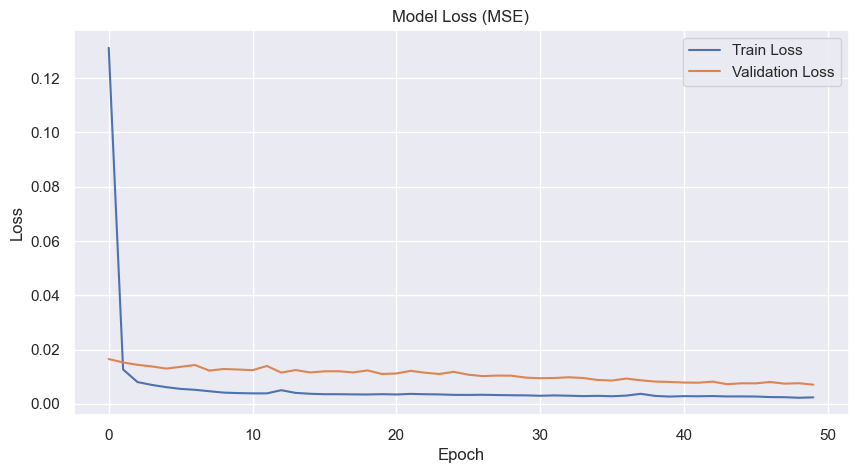

In [179]:
produccion = dataRNNdiasDemanda[['Produccion']]
train_data = produccion.loc['2019-01-01':'2020-12-31']
val_data = produccion.loc['2021-01-01':'2021-12-31']

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

look_back = 30

def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, look_back)
X_val, y_val = prepare_data(val_scaled, look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [180]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[look_back:].values.flatten(), 'Predictions': predictions.flatten()})

print(comparison)


11/11 [==============================] - 2s 42ms/step
     Real Values    Predictions
0         264439  260478.015625
1         258896  261978.953125
2         262317  262088.078125
3         260137  262591.937500
4         263383  262521.031250
..           ...            ...
330       291977  299012.250000
331       279246  297784.093750
332       261122  293083.906250
333       248905  283369.250000
334       257533  271209.875000

[335 rows x 2 columns]


In [181]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions).flatten()

threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real
correct_predictions = np.abs(predictions - val_data['Produccion'].iloc[look_back:].values) <= threshold * val_data['Produccion'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


 6/11 [===============>..............] - ETA: 0s

11/11 [==============================] - 0s 24ms/step
Accuracy basado en un umbral del 1.0%: 20.90%


 5/11 [============>.................] - ETA: 0s

11/11 [==============================] - 0s 44ms/step


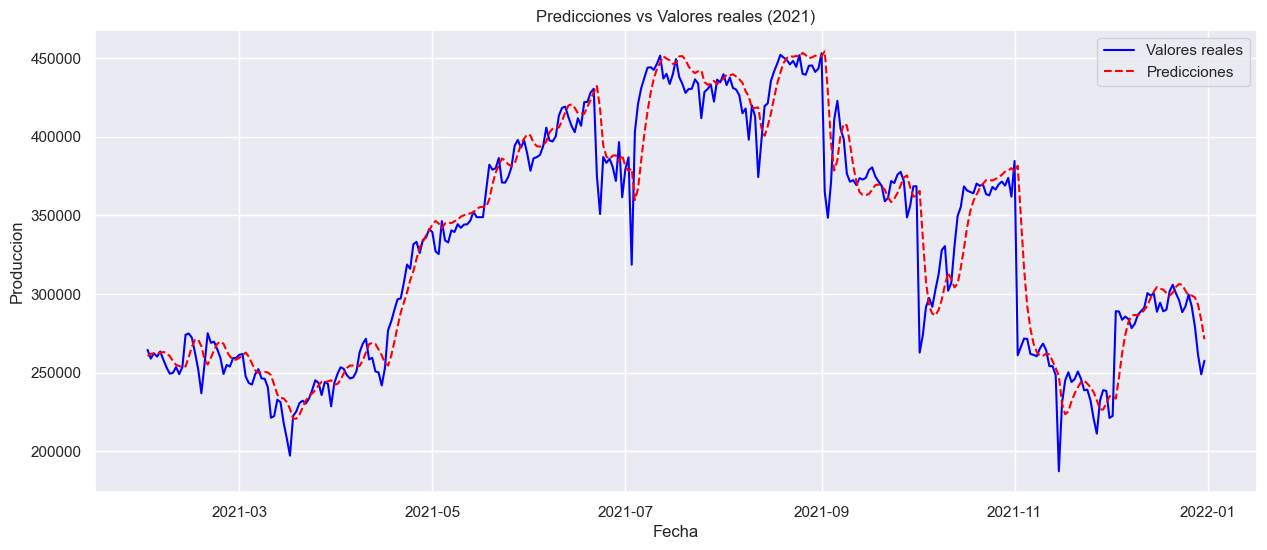

In [182]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions).flatten()

plt.figure(figsize=(15, 6))

plt.plot(val_data.index[look_back:], val_data['Produccion'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Produccion")
plt.legend()
plt.grid(True)
plt.show()


## LSTM por horas para predecir la demanda solo con la demanda

In [183]:
dataHoraDemanda = pd.read_csv("datosHorarios.csv")


Epoch 1/50
549/549 [==============================] - 9s 8ms/step - loss: 0.0279 - mae: 0.0973 - val_loss: 0.0032 - val_mae: 0.0434
Epoch 2/50
549/549 [==============================] - 6s 10ms/step - loss: 0.0017 - mae: 0.0322 - val_loss: 0.0024 - val_mae: 0.0389
Epoch 3/50
549/549 [==============================] - 9s 16ms/step - loss: 0.0014 - mae: 0.0288 - val_loss: 0.0016 - val_mae: 0.0338
Epoch 4/50
549/549 [==============================] - 8s 14ms/step - loss: 0.0012 - mae: 0.0268 - val_loss: 0.0014 - val_mae: 0.0314
Epoch 5/50
549/549 [==============================] - 6s 10ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 0.0015 - val_mae: 0.0323
Epoch 6/50
549/549 [==============================] - 6s 10ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 7/50
549/549 [==============================] - 5s 9ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0015 - val_mae: 0.0325
Epoch 8/50
549/549 [==============================] - 4s 8ms/step - los

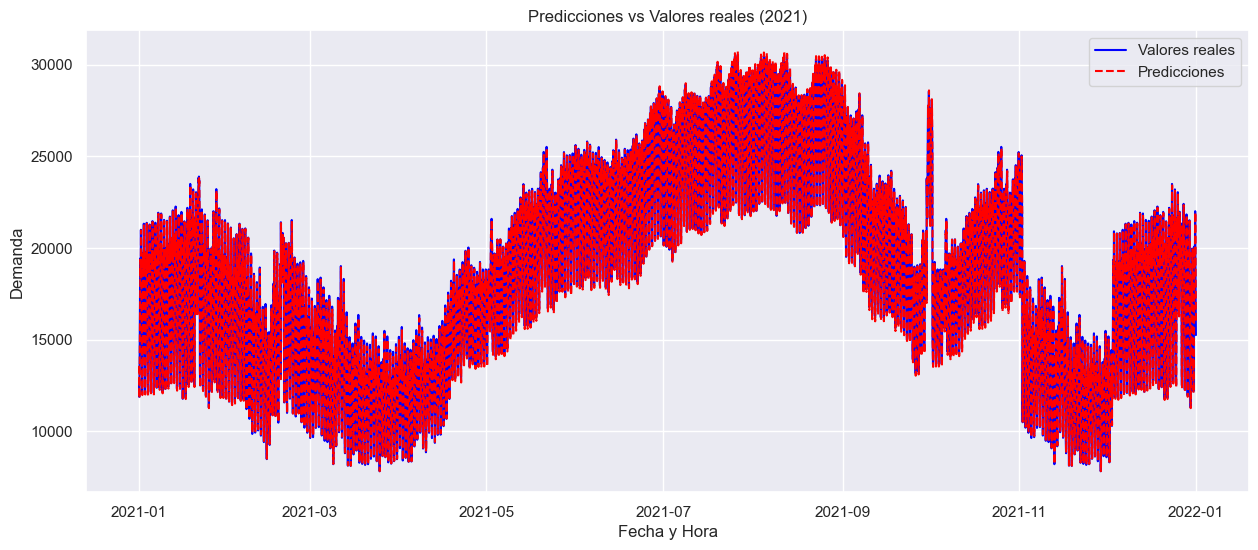

In [184]:
date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemanda), freq='H')
dataHoraDemanda.index = date_hour_index
demand = dataHoraDemanda[['Demanda']]
train_data = demand.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = demand.loc['2021-01-01':'2021-12-31 23:00:00']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

look_back = 1
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, look_back)
X_val, y_val = prepare_data(val_scaled, look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[look_back:], val_data['Demanda'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()

In [185]:
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[look_back:].values, 'Predictions': predictions.flatten()})
print(comparison)

threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real
correct_predictions = np.abs(predictions.flatten() - val_data['Demanda'].iloc[look_back:].values) <= threshold * val_data['Demanda'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

      Real Values   Predictions
0           12559  13577.775391
1           11928  12455.596680
2           11879  11857.685547
3           12429  11811.511719
4           13359  12331.909180
...           ...           ...
8754        19597  20733.574219
8755        18253  19544.576172
8756        17179  18139.001953
8757        16117  17026.205078
8758        15250  15944.842773

[8759 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 13.59%


## LSTM por horas para predecir la produccion solo con la produccion


In [187]:
dataHoraProduccion = pd.read_csv("datosHorarios.csv")

Epoch 1/50
549/549 [==============================] - 8s 7ms/step - loss: 0.0513 - mae: 0.1279 - val_loss: 0.0016 - val_mae: 0.0282
Epoch 2/50
549/549 [==============================] - 3s 6ms/step - loss: 0.0015 - mae: 0.0283 - val_loss: 0.0015 - val_mae: 0.0277
Epoch 3/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 0.0014 - val_mae: 0.0259
Epoch 4/50
549/549 [==============================] - 4s 6ms/step - loss: 0.0013 - mae: 0.0259 - val_loss: 0.0012 - val_mae: 0.0228
Epoch 5/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0010 - val_mae: 0.0201
Epoch 6/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 9.7042e-04 - val_mae: 0.0194
Epoch 7/50
549/549 [==============================] - 4s 8ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 9.6528e-04 - val_mae: 0.0189
Epoch 8/50
549/549 [==============================] - 5s 9ms/step - 

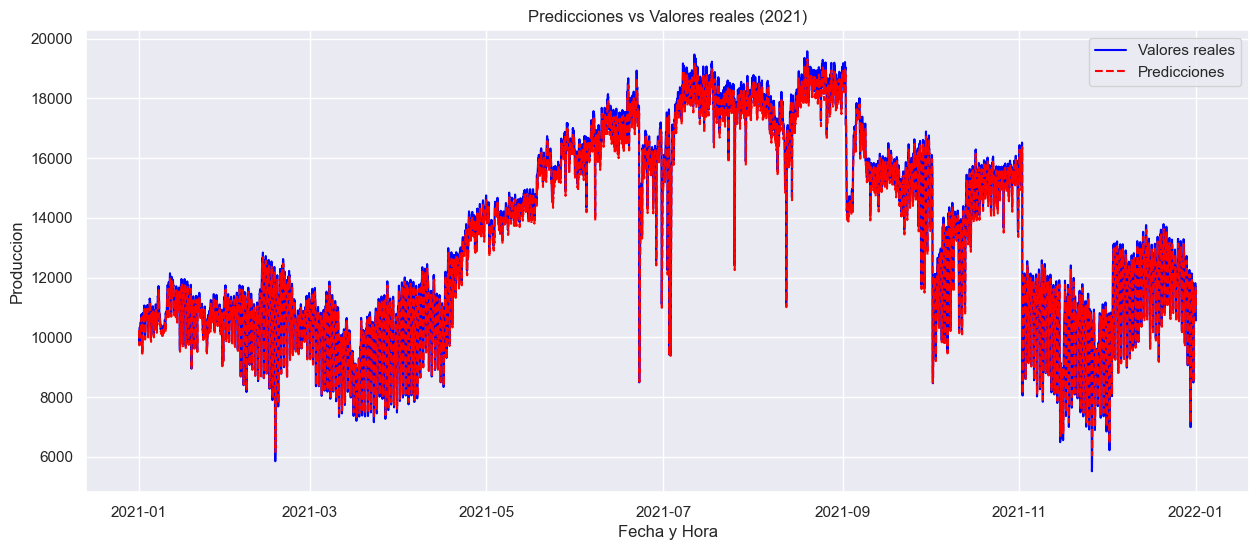

In [188]:
date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraProduccion), freq='H')
dataHoraProduccion.index = date_hour_index

produccion = dataHoraProduccion[['Produccion']]

train_data = produccion.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = produccion.loc['2021-01-01':'2021-12-31 23:00:00']

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

look_back = 1
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, look_back)
X_val, y_val = prepare_data(val_scaled, look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(15, 6))
plt.plot(val_data.index[look_back:], val_data['Produccion'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Produccion")
plt.legend()
plt.grid(True)
plt.show()


In [189]:
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[look_back:].values, 'Predictions': predictions.flatten()})
print(comparison)

threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real

correct_predictions = np.abs(predictions.flatten() - val_data['Produccion'].iloc[look_back:].values) <= threshold * val_data['Produccion'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


      Real Values   Predictions
0           10085  10241.500000
1            9865  10006.903320
2            9792   9797.881836
3            9938   9728.690430
4           10247   9867.155273
...           ...           ...
8754        11690  11672.365234
8755        11691  11553.348633
8756        11472  11554.323242
8757        11025  11341.175781
8758        10560  10908.158203

[8759 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 33.05%


## LSTM para predecir la demanda con todas las caracteristicas diaria

In [190]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index

In [191]:
def LSTMDemandaDiaria2(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()



    Cogiendo un día anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 5s 44ms/step - loss: 0.2263 - val_loss: 0.3177
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1496 - val_loss: 0.1758
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0518 - val_loss: 0.0297
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0219
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0170
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss: 0.0181
Epoch 7/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0155
Epoch 8/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0139
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0111
Epoch 10/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0090
Epoch 11/50
23/23

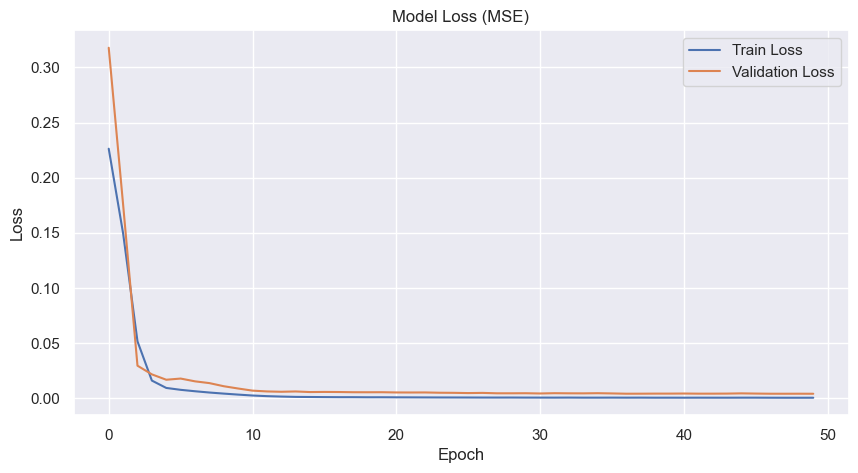

12/12 [==============================] - 0s 3ms/step
     Real Values   Predictions
0         405037  395697.62500
1         406001  403733.18750
2         404353  404941.28125
3         407859  403467.25000
4         406022  406534.09375
..           ...           ...
361       411592  419846.96875
362       378184  410302.12500
363       414996  379141.56250
364       437452  413224.75000
365       417780  434030.59375

[366 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 23.77%


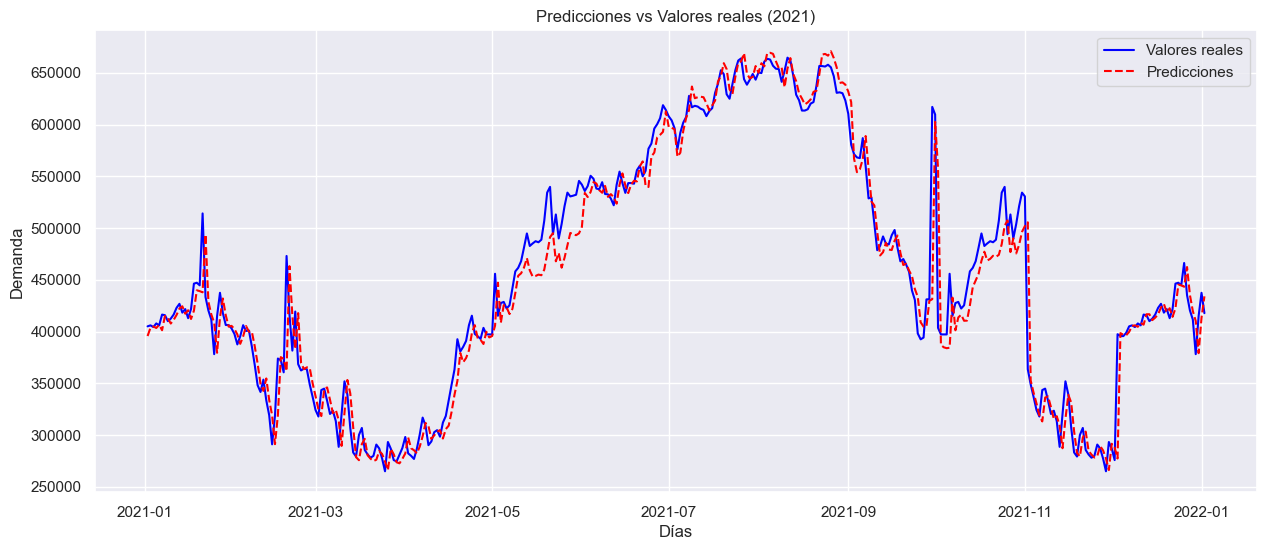

In [192]:
LSTMDemandaDiaria2(1, dataFullCaracteristicas)

    Cogiendo 7 dias anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 4s 32ms/step - loss: 0.0677 - val_loss: 0.0242
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0086 - val_loss: 0.0254
Epoch 3/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0058 - val_loss: 0.0144
Epoch 4/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0038 - val_loss: 0.0104
Epoch 5/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0031 - val_loss: 0.0106
Epoch 6/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 7/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0095
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 9/50
23/23 [==============================] - 0s 17ms/step - loss: 0.0023 - val_loss: 0.0097
Epoch 10/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0090
Epoch 11/

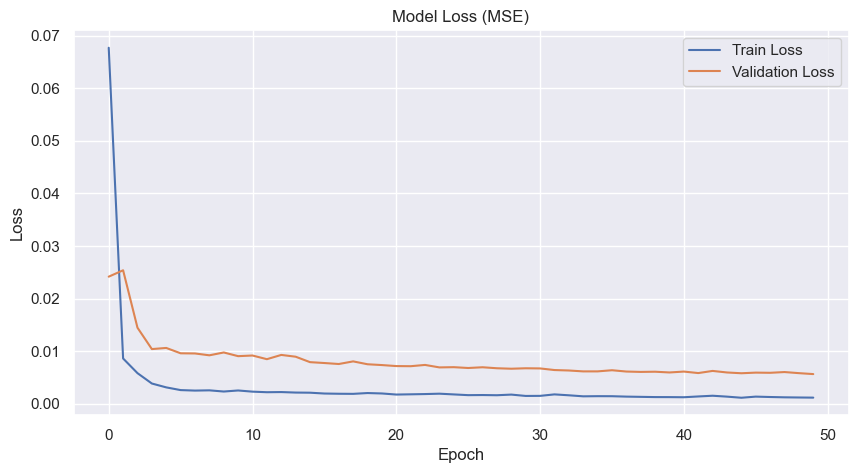

12/12 [==============================] - 1s 7ms/step
     Real Values   Predictions
0         415824  427716.90625
1         410048  418231.84375
2         412486  418113.53125
3         416401  421186.93750
4         422912  426939.71875
..           ...           ...
355       411592  427158.68750
356       378184  415496.31250
357       414996  397017.31250
358       437452  393444.46875
359       417780  404384.18750

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 18.61%


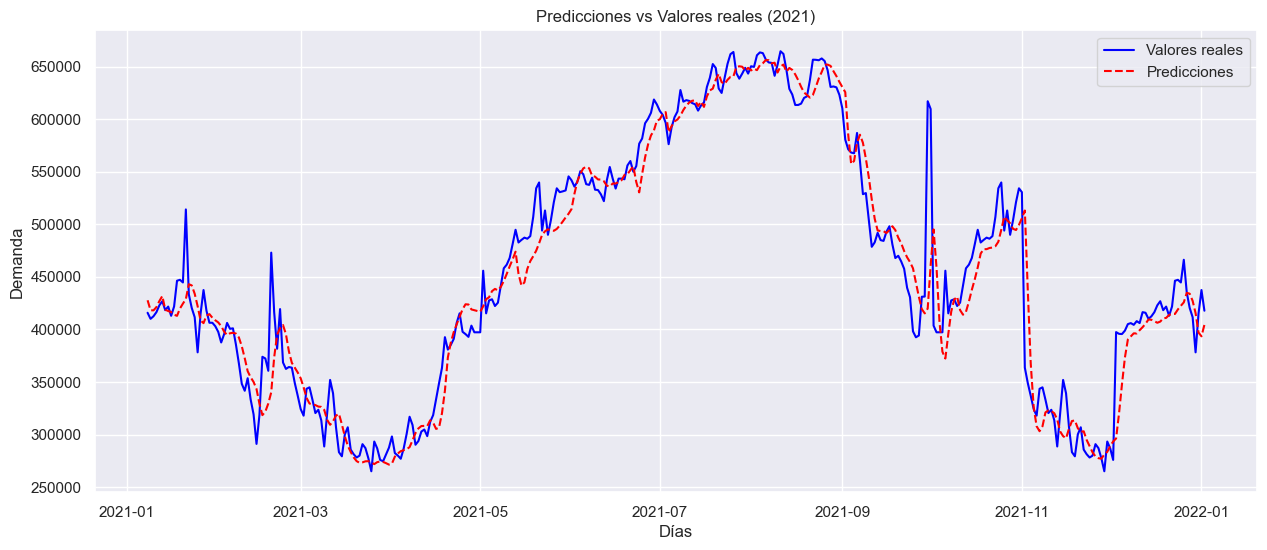

In [193]:
LSTMDemandaDiaria2(7, dataFullCaracteristicas)

    Cogiendo 30 días anterior para la prediccion

Epoch 1/50
22/22 [==============================] - 4s 51ms/step - loss: 0.0732 - val_loss: 0.0487
Epoch 2/50
22/22 [==============================] - 1s 37ms/step - loss: 0.0114 - val_loss: 0.0317
Epoch 3/50
22/22 [==============================] - 1s 43ms/step - loss: 0.0079 - val_loss: 0.0265
Epoch 4/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0057 - val_loss: 0.0229
Epoch 5/50
22/22 [==============================] - 1s 39ms/step - loss: 0.0042 - val_loss: 0.0154
Epoch 6/50
22/22 [==============================] - 1s 38ms/step - loss: 0.0036 - val_loss: 0.0143
Epoch 7/50
22/22 [==============================] - 1s 37ms/step - loss: 0.0034 - val_loss: 0.0162
Epoch 8/50
22/22 [==============================] - 1s 45ms/step - loss: 0.0034 - val_loss: 0.0168
Epoch 9/50
22/22 [==============================] - 1s 50ms/step - loss: 0.0032 - val_loss: 0.0148
Epoch 10/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0031 - val_loss: 0.0143
Epoch 11/

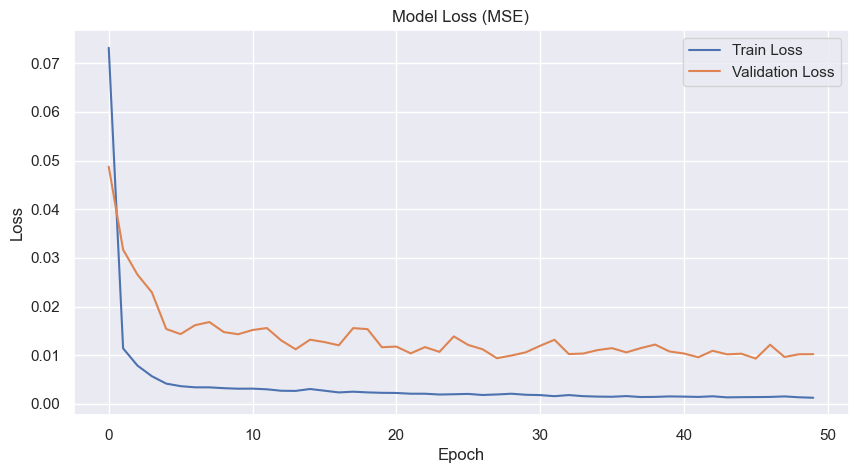

11/11 [==============================] - 1s 14ms/step
     Real Values   Predictions
0         403046  417147.40625
1         397671  414684.12500
2         387589  412401.40625
3         395473  409653.65625
4         406162  407144.59375
..           ...           ...
332       411592  416801.34375
333       378184  413431.21875
334       414996  407852.71875
335       437452  405450.46875
336       417780  404916.31250

[337 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 13.65%


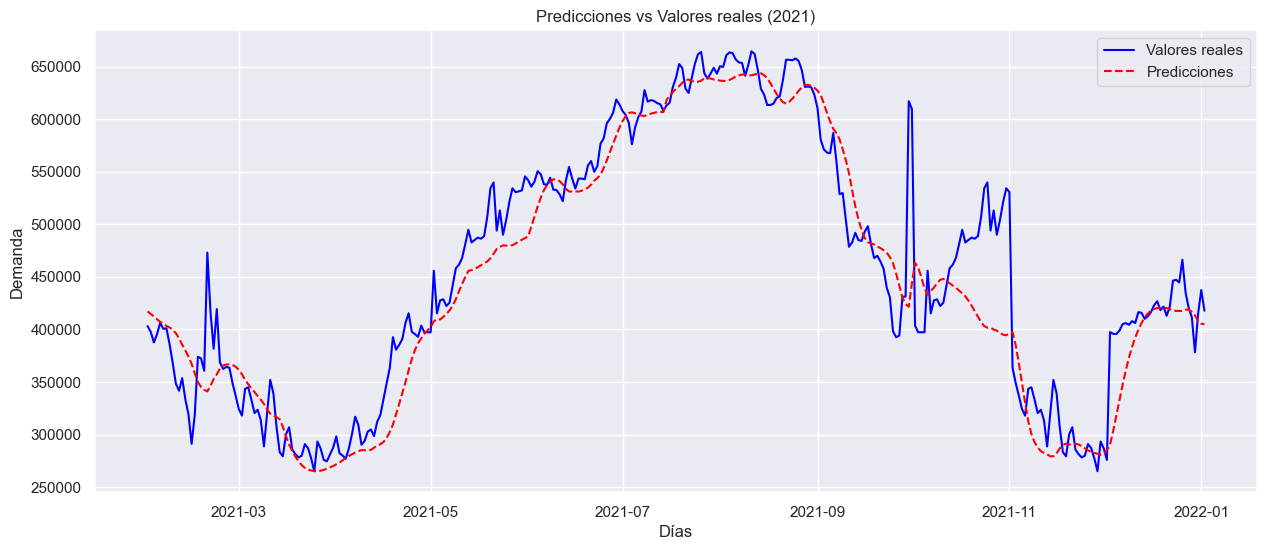

In [194]:
LSTMDemandaDiaria2(30, dataFullCaracteristicas)

## LSTM para predecir la producción con todas las caracteristicas diaria

In [203]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index

In [204]:
def LSTMProduccionDiaria(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()

      Cogiendo un día anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 4s 24ms/step - loss: 0.3584 - val_loss: 0.3390
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.2413 - val_loss: 0.1769
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0855 - val_loss: 0.0344
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0200 - val_loss: 0.0153
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0122
Epoch 6/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.0109
Epoch 7/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0092
Epoch 10/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0091
Epoch 11/50
23/23

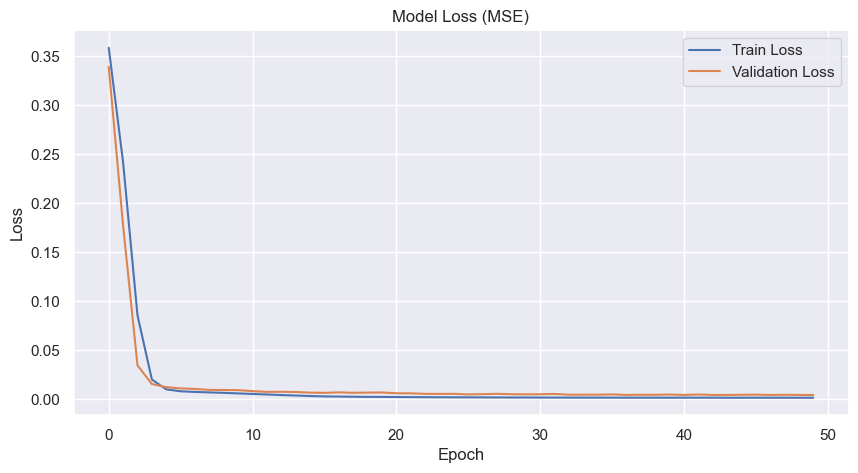

12/12 [==============================] - 0s 3ms/step
     Real Values    Predictions
0         253488  252927.250000
1         258897  256326.218750
2         259925  260977.171875
3         256563  261750.171875
4         256305  259106.062500
..           ...            ...
361       261122  279783.437500
362       248905  263243.593750
363       257533  250881.750000
364       272710  260383.687500
365       277922  275144.906250

[366 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 29.51%


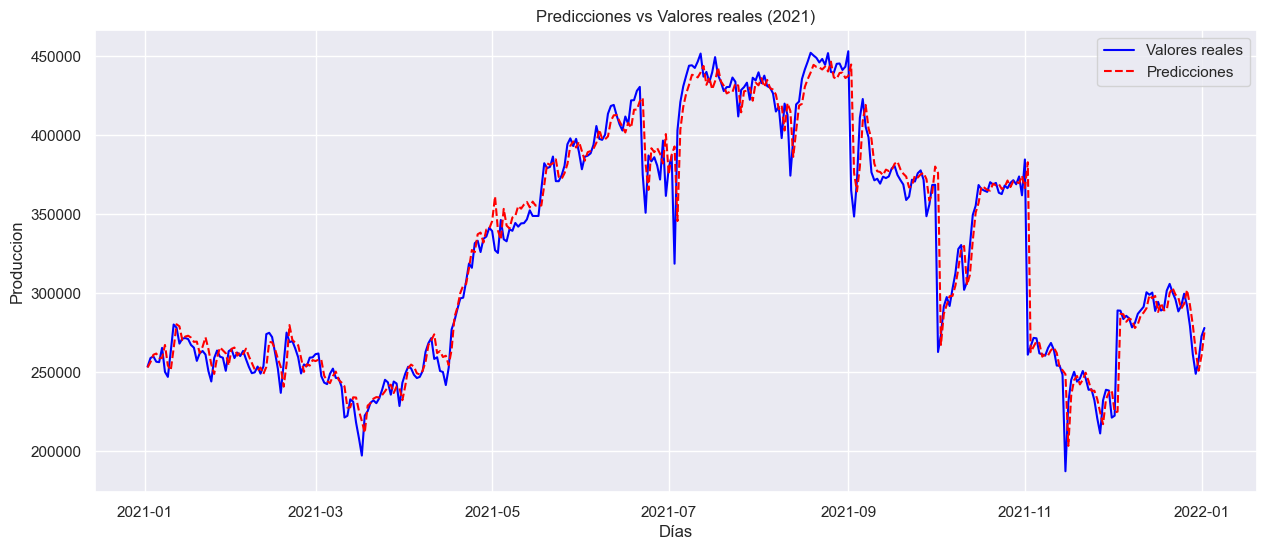

In [205]:
LSTMProduccionDiaria(1, dataFullCaracteristicas)

      Cogiendo 7 dias anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 4s 34ms/step - loss: 0.1594 - val_loss: 0.0584
Epoch 2/50
23/23 [==============================] - 0s 18ms/step - loss: 0.0193 - val_loss: 0.0183
Epoch 3/50
23/23 [==============================] - 0s 18ms/step - loss: 0.0076 - val_loss: 0.0144
Epoch 4/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 5/50
23/23 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0097
Epoch 6/50
23/23 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0098
Epoch 7/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0091
Epoch 8/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0090
Epoch 9/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0098
Epoch 10/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0033 - val_loss: 0.0092
Epoch 11/

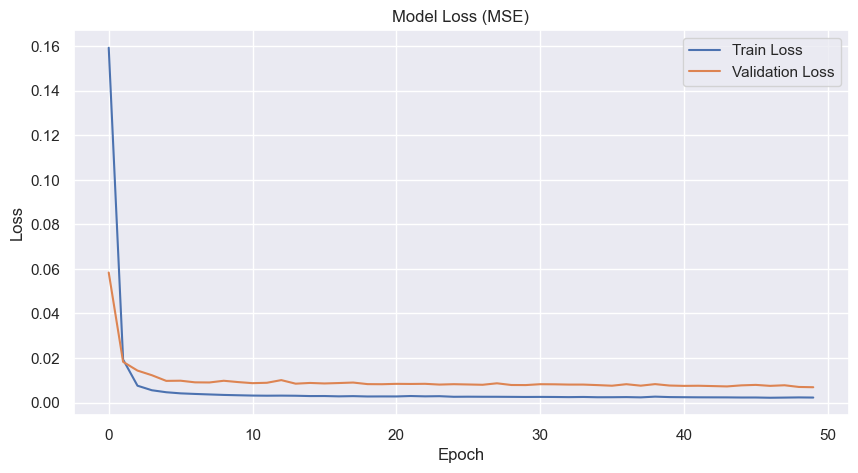

12/12 [==============================] - 1s 8ms/step
     Real Values   Predictions
0         250163  271740.75000
1         246979  265430.28125
2         263122  263898.62500
3         280107  264241.78125
4         278105  267812.37500
..           ...           ...
355       261122  291400.18750
356       248905  284791.93750
357       257533  276350.90625
358       272710  270605.46875
359       277922  268977.15625

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 21.67%


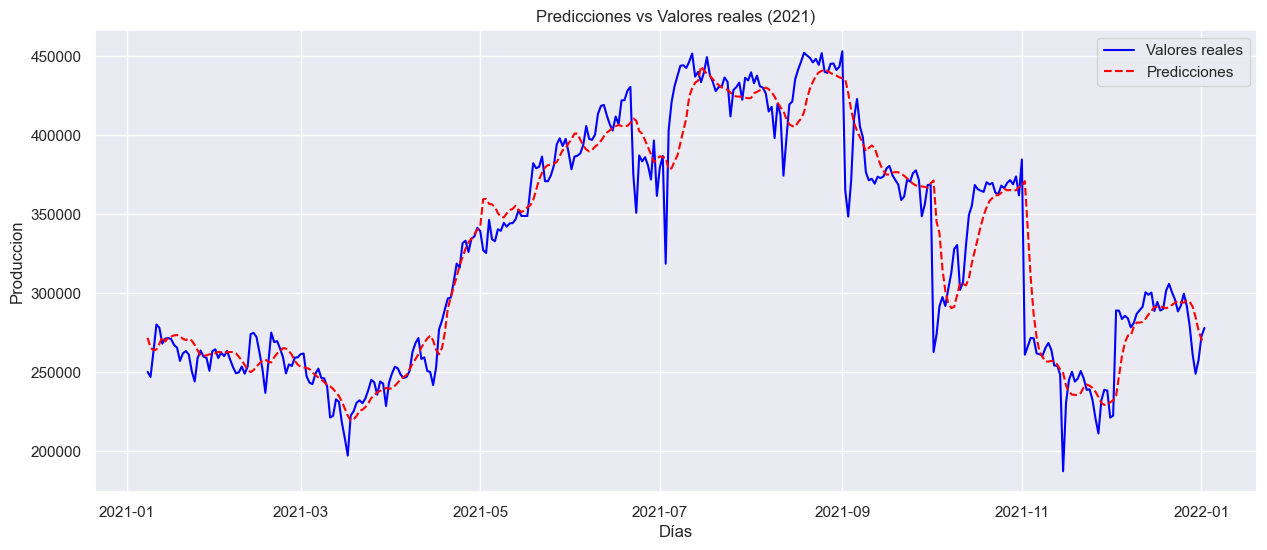

In [206]:
LSTMProduccionDiaria(7, dataFullCaracteristicas)

      Cogiendo 30 dias anterior para la prediccion

Epoch 1/50
22/22 [==============================] - 5s 71ms/step - loss: 0.1619 - val_loss: 0.0277
Epoch 2/50
22/22 [==============================] - 1s 45ms/step - loss: 0.0115 - val_loss: 0.0259
Epoch 3/50
22/22 [==============================] - 1s 43ms/step - loss: 0.0069 - val_loss: 0.0215
Epoch 4/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0057 - val_loss: 0.0212
Epoch 5/50
22/22 [==============================] - 1s 37ms/step - loss: 0.0049 - val_loss: 0.0182
Epoch 6/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0046 - val_loss: 0.0187
Epoch 7/50
22/22 [==============================] - 1s 45ms/step - loss: 0.0043 - val_loss: 0.0182
Epoch 8/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0042 - val_loss: 0.0154
Epoch 9/50
22/22 [==============================] - 1s 53ms/step - loss: 0.0039 - val_loss: 0.0149
Epoch 10/50
22/22 [==============================] - 1s 54ms/step - loss: 0.0037 - val_loss: 0.0155
Epoch 11/

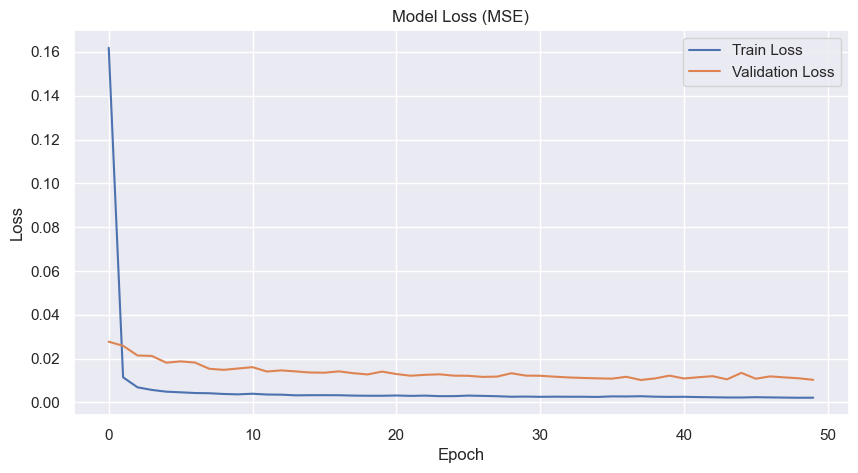

11/11 [==============================] - 2s 23ms/step
     Real Values   Predictions
0         264439  269933.25000
1         258896  269141.71875
2         262317  268323.00000
3         260137  267478.09375
4         263383  266659.93750
..           ...           ...
332       261122  301168.00000
333       248905  298874.90625
334       257533  294842.00000
335       272710  291684.15625
336       277922  289677.81250

[337 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 12.17%


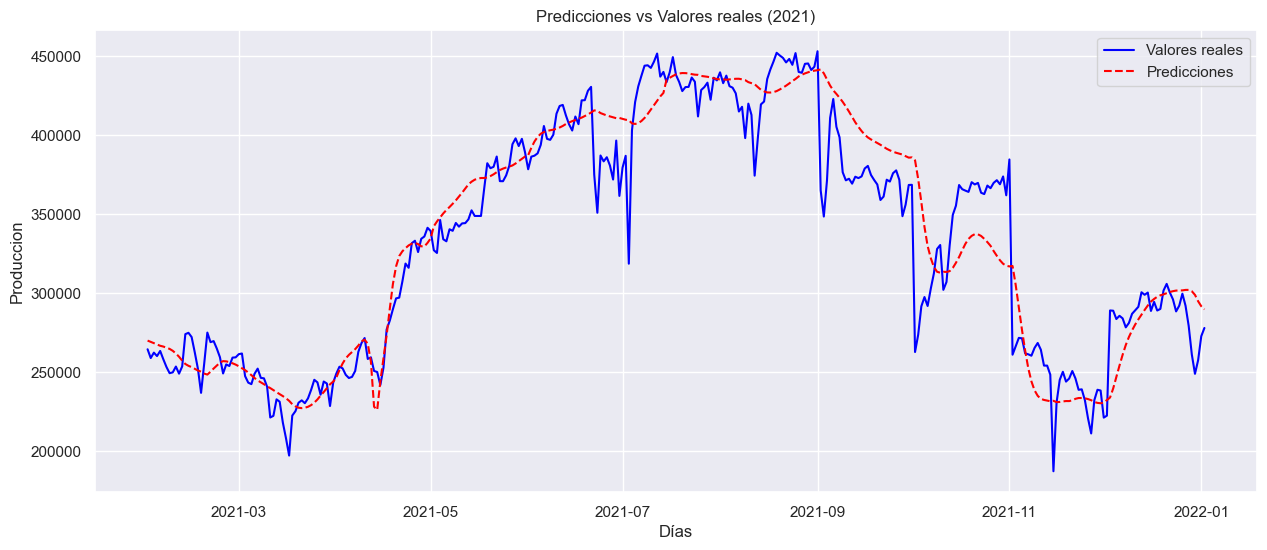

In [207]:
LSTMProduccionDiaria(30, dataFullCaracteristicas)

## LSTM para predecir la demanda con todas las caracteristicas por horas

In [195]:
dataHoras= pd.read_csv("datosHorarios.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataHoras), freq='D')
dataHoras.index = date_index

In [196]:
dataHoras

Produccion  Hours  Demanda
2019-01-01       10494      1    11479
2019-01-02        9914      2    10595
2019-01-03        9452      3    10132
2019-01-04        9334      4    10437
2019-01-05        9832      5    11576
...                ...    ...      ...
2091-02-19       12754     20    19725
2091-02-20       12639     21    18376
2091-02-21       12320     22    17323
2091-02-22       11802     23    16220
2091-02-23       11000     24    15341

[26352 rows x 3 columns]

In [197]:


def LSTMDemandaHoraria(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])
    
    estaciones = ['Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera', 'Estacion_Verano']
    for estacion in estaciones:
        if estacion not in data.columns:
            data[estacion] = 0

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='H'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='H'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='H')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='H'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='H'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='H')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = pd.to_datetime(["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                               "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                               "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"])
    festivos_hours = [pd.date_range(start=f, end=f + pd.Timedelta(days=1), freq='H') for f in festivos]
    
    data['Festivo'] = data.index.isin(np.concatenate(festivos_hours)).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    

    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Horas")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo la hora anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 6s 102ms/step - loss: 0.3765 - val_loss: 0.5475
Epoch 2/50
23/23 [==============================] - 2s 78ms/step - loss: 0.2581 - val_loss: 0.3179
Epoch 3/50
23/23 [==============================] - 2s 95ms/step - loss: 0.0764 - val_loss: 0.0590
Epoch 4/50
23/23 [==============================] - 2s 86ms/step - loss: 0.0322 - val_loss: 0.0599
Epoch 5/50
23/23 [==============================] - 2s 83ms/step - loss: 0.0263 - val_loss: 0.0465
Epoch 6/50
23/23 [==============================] - 2s 94ms/step - loss: 0.0233 - val_loss: 0.0382
Epoch 7/50
23/23 [==============================] - 2s 86ms/step - loss: 0.0209 - val_loss: 0.0306
Epoch 8/50
23/23 [==============================] - 2s 93ms/step - loss: 0.0181 - val_loss: 0.0258
Epoch 9/50
23/23 [==============================] - 2s 80ms/step - loss: 0.0156 - val_loss: 0.0281
Epoch 10/50
23/23 [==============================] - 2s 85ms/step - loss: 0.0136 - val_loss: 0.0283
Epoch 11

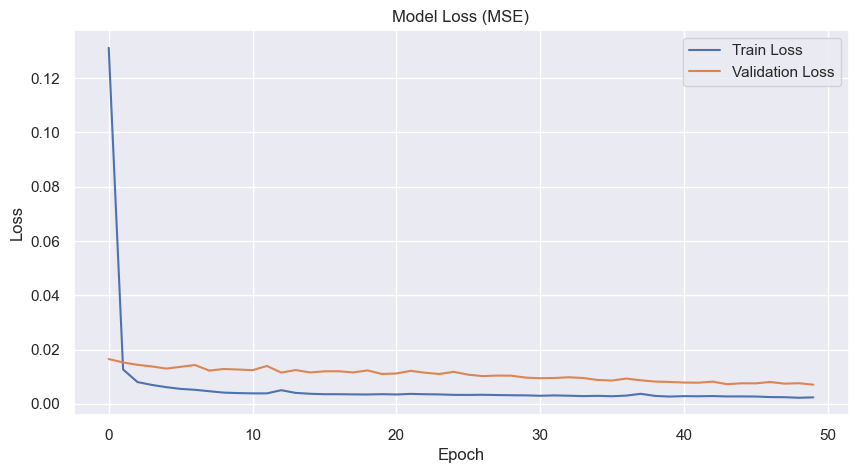

801/801 [==============================] - 2s 3ms/step
       Real Values   Predictions
0            17525  18278.794922
1            17525  17286.173828
2            17096  17286.173828
3            18823  17061.882812
4            19197  19633.500000
...            ...           ...
25614        19725  20343.847656
25615        18376  19380.439453
25616        17323  18325.398438
25617        16220  17343.230469
25618        15341  16271.688477

[25619 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 5.65%


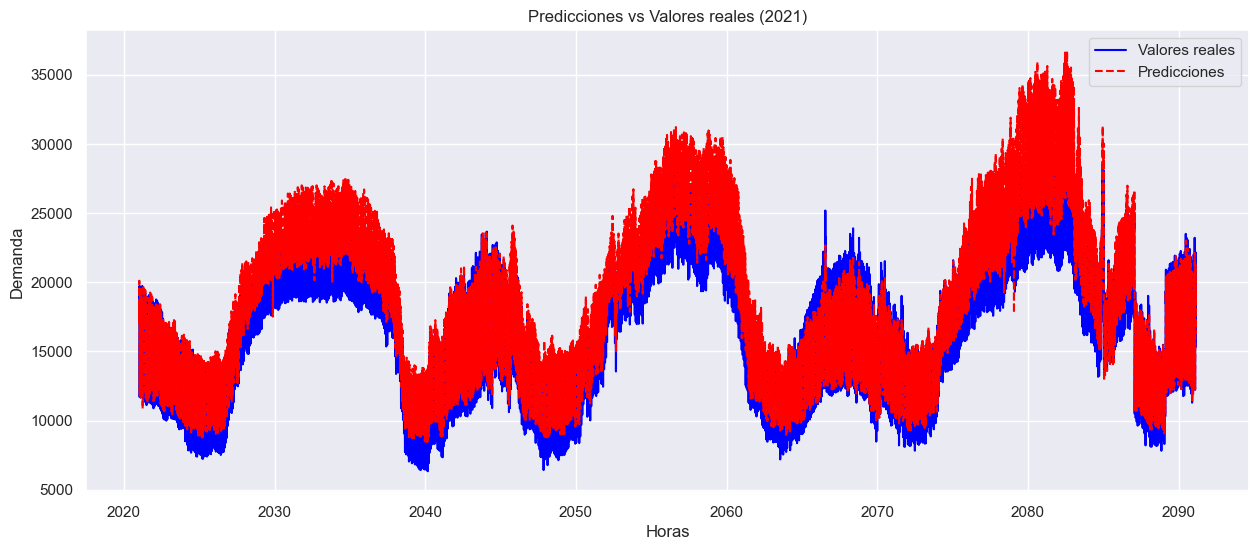

In [198]:
LSTMDemandaHoraria(1,dataHoras)

## LSTM para predecir la producción con todas las caracteristicas por horas

In [210]:

dataHoras= pd.read_csv("datosHorarios.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataHoras), freq='D')
dataHoras.index = date_index

In [211]:

def LSTMProduccionHoraria(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])
    
    estaciones = ['Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera', 'Estacion_Verano']
    for estacion in estaciones:
        if estacion not in data.columns:
            data[estacion] = 0

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='H'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='H'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='H')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='H'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='H'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='H')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = pd.to_datetime(["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                               "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                               "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"])
    festivos_hours = [pd.date_range(start=f, end=f + pd.Timedelta(days=1), freq='H') for f in festivos]
    
    data['Festivo'] = data.index.isin(np.concatenate(festivos_hours)).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    

    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Horas")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()


        Cogiendo la hora anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 6s 113ms/step - loss: 0.5127 - val_loss: 0.9544
Epoch 2/50
23/23 [==============================] - 2s 92ms/step - loss: 0.3686 - val_loss: 0.6276
Epoch 3/50
23/23 [==============================] - 2s 95ms/step - loss: 0.1186 - val_loss: 0.0997
Epoch 4/50
23/23 [==============================] - 2s 110ms/step - loss: 0.0192 - val_loss: 0.0881
Epoch 5/50
23/23 [==============================] - 2s 90ms/step - loss: 0.0114 - val_loss: 0.0691
Epoch 6/50
23/23 [==============================] - 2s 88ms/step - loss: 0.0098 - val_loss: 0.0679
Epoch 7/50
23/23 [==============================] - 2s 92ms/step - loss: 0.0093 - val_loss: 0.0590
Epoch 8/50
23/23 [==============================] - 2s 84ms/step - loss: 0.0089 - val_loss: 0.0558
Epoch 9/50
23/23 [==============================] - 2s 98ms/step - loss: 0.0084 - val_loss: 0.0516
Epoch 10/50
23/23 [==============================] - 3s 116ms/step - loss: 0.0081 - val_loss: 0.0455
Epoch 

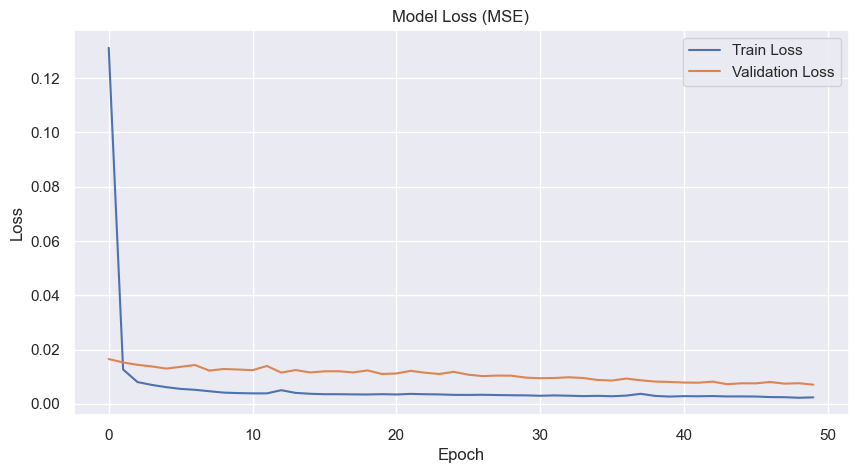

801/801 [==============================] - 3s 3ms/step
       Real Values   Predictions
0            11971  12281.693359
1            11971  11988.368164
2            12120  11988.368164
3            12453  12131.203125
4            12669  12725.833984
...            ...           ...
25614        12754  12898.484375
25615        12639  12798.021484
25616        12320  12658.673828
25617        11802  12334.791992
25618        11000  11810.755859

[25619 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 22.84%


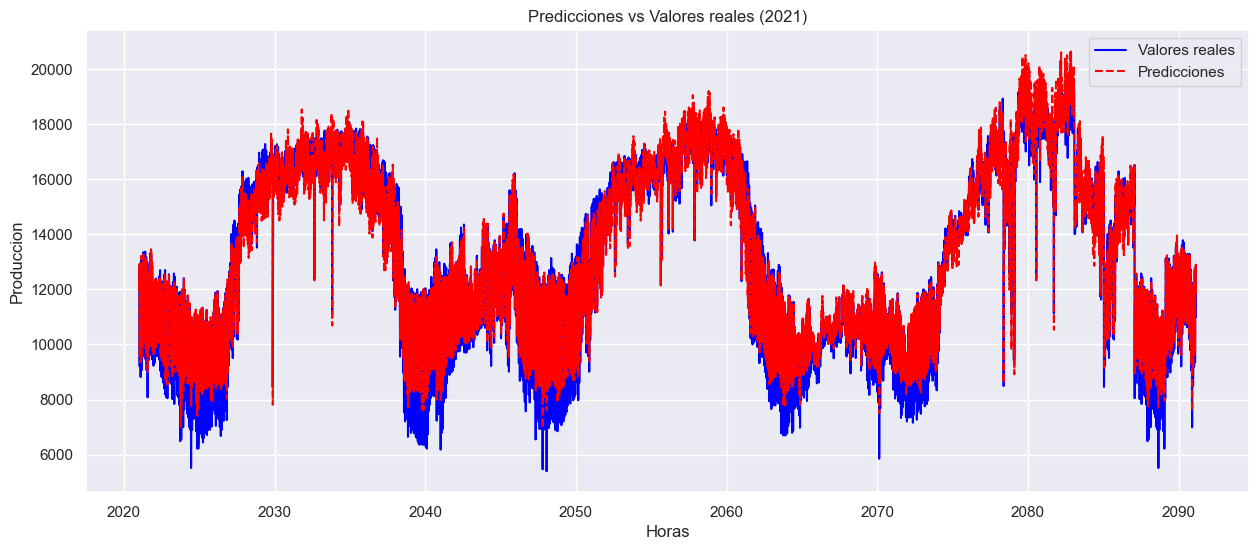

In [212]:
LSTMProduccionHoraria(1,dataHoras)

## LSTM para predecir la demanda con todas las caracteristicas por meses

In [199]:
dataMes= data.resample('m').sum()
dataMes

Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12224975     8528453

In [200]:
def LSTMDemandaMensual(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_months = ["2019-05", "2019-06", "2020-04", "2020-05", "2021-04", "2021-05"]
    shaaban_months = ["2019-04", "2019-05", "2020-03", "2020-04", "2021-03", "2021-04"]

    data['Ramadan'] = data.index.strftime('%Y-%m').isin(ramadan_months).astype(int)
    data['Shaaban'] = data.index.strftime('%Y-%m').isin(shaaban_months).astype(int)

    festivos = ["2019-01", "2019-05", "2019-07", "2019-10", "2020-01", "2020-05", "2020-07", "2020-10", "2021-01", "2021-05", "2021-07", "2021-10"]
    data['Festivo'] = data.index.strftime('%Y-%m').isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

 
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
   
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Meses")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el mes anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2641 - val_loss: 0.4434
Epoch 2/50
1/1 [==============================] - 0s 54ms/step - loss: 0.2615 - val_loss: 0.4399
Epoch 3/50
1/1 [==============================] - 0s 71ms/step - loss: 0.2589 - val_loss: 0.4364
Epoch 4/50
1/1 [==============================] - 0s 80ms/step - loss: 0.2564 - val_loss: 0.4329
Epoch 5/50
1/1 [==============================] - 0s 80ms/step - loss: 0.2539 - val_loss: 0.4294
Epoch 6/50
1/1 [==============================] - 0s 70ms/step - loss: 0.2513 - val_loss: 0.4258
Epoch 7/50
1/1 [==============================] - 0s 70ms/step - loss: 0.2488 - val_loss: 0.4222
Epoch 8/50
1/1 [==============================] - 0s 73ms/step - loss: 0.2462 - val_loss: 0.4185
Epoch 9/50
1/1 [==============================] - 0s 41ms/step - loss: 0.2435 - val_loss: 0.4146
Epoch 10/50
1/1 [==============================] - 0s 37ms/step - loss: 0.2408 - val_loss: 0.4107
Epoch 11/50
1/1 [==============

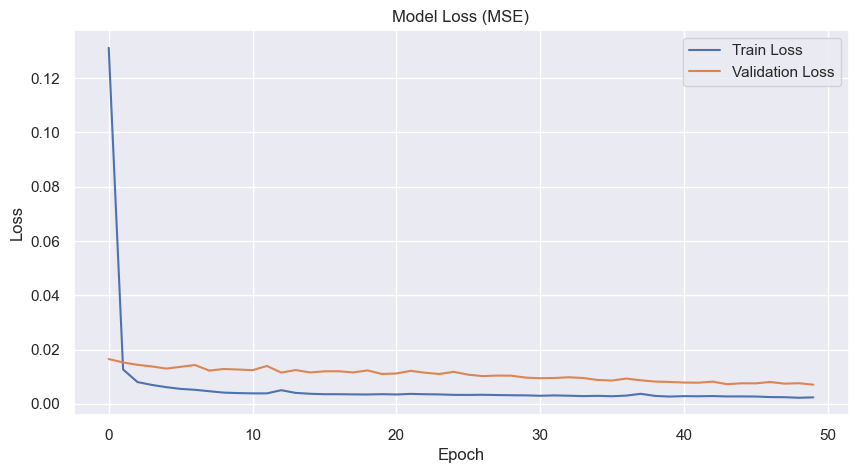

1/1 [==============================] - 1s 776ms/step
    Real Values  Predictions
0      10390139   11357181.0
1       9342708   10111392.0
2      10272893   10441837.0
3      14984538   12050361.0
4      16670675   13146478.0
5      19392643   11701366.0
6      19935514   13533004.0
7      14896197   12240335.0
8      14652679   11455728.0
9       9516929   12209889.0
10     12224975   10411475.0
Accuracy basado en un umbral del 1.0%: 0.00%


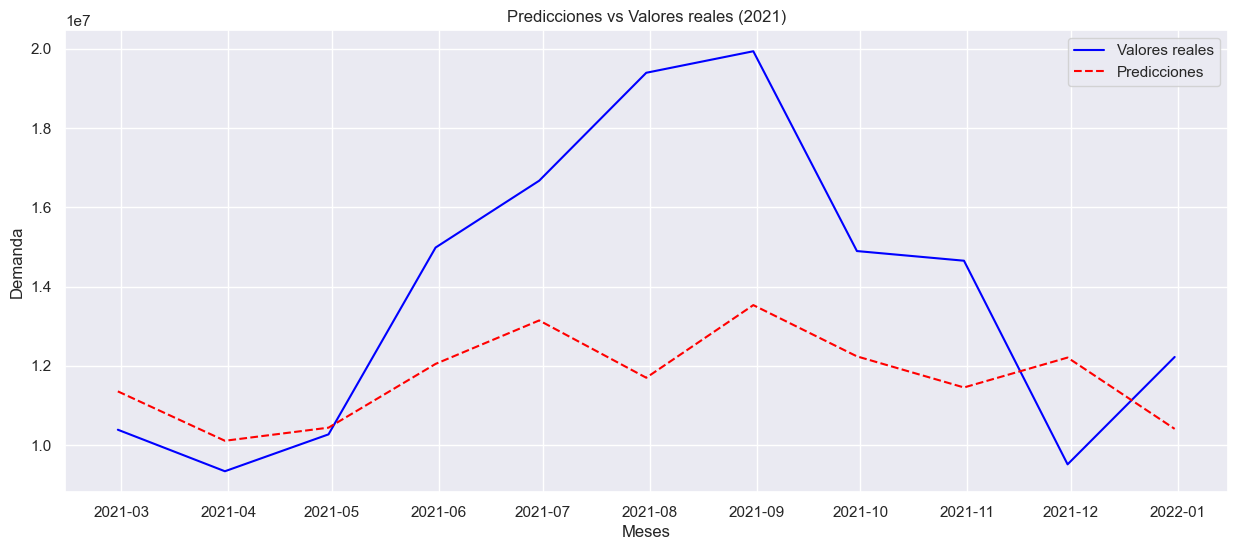

In [201]:
LSTMDemandaMensual(1,dataMes)

    Cogiendo 6 meses anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.3149 - val_loss: 0.5796
Epoch 2/50
1/1 [==============================] - 0s 149ms/step - loss: 0.2956 - val_loss: 0.5482
Epoch 3/50
1/1 [==============================] - 0s 131ms/step - loss: 0.2771 - val_loss: 0.5175
Epoch 4/50
1/1 [==============================] - 0s 103ms/step - loss: 0.2593 - val_loss: 0.4877
Epoch 5/50
1/1 [==============================] - 0s 122ms/step - loss: 0.2423 - val_loss: 0.4588
Epoch 6/50
1/1 [==============================] - 0s 70ms/step - loss: 0.2261 - val_loss: 0.4308
Epoch 7/50
1/1 [==============================] - 0s 136ms/step - loss: 0.2105 - val_loss: 0.4036
Epoch 8/50
1/1 [==============================] - 0s 134ms/step - loss: 0.1957 - val_loss: 0.3773
Epoch 9/50
1/1 [==============================] - 0s 147ms/step - loss: 0.1817 - val_loss: 0.3518
Epoch 10/50
1/1 [==============================] - 0s 224ms/step - loss: 0.1687 - val_loss: 0.3268
Epoch 11/50
1/1 [======

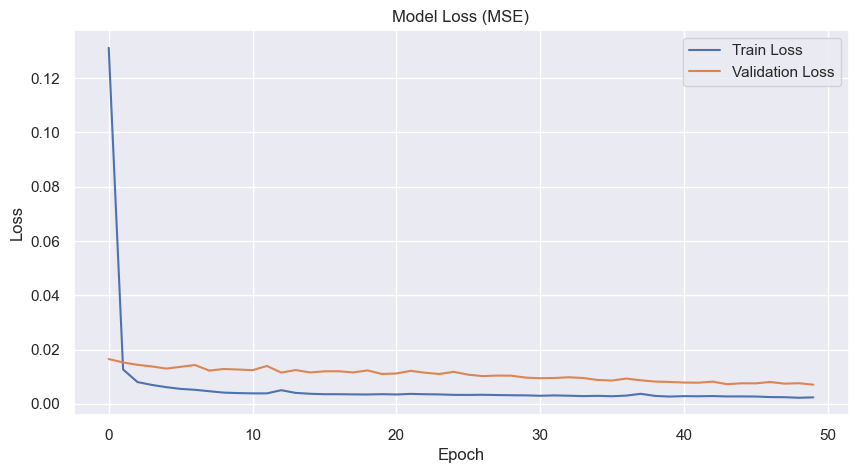

1/1 [==============================] - 0s 344ms/step
   Real Values  Predictions
0     19392643   16228833.0
1     19935514   15779996.0
2     14896197   14297603.0
3     14652679   12236150.0
4      9516929   10690637.0
5     12224975   10221512.0
Accuracy basado en un umbral del 1.0%: 0.00%


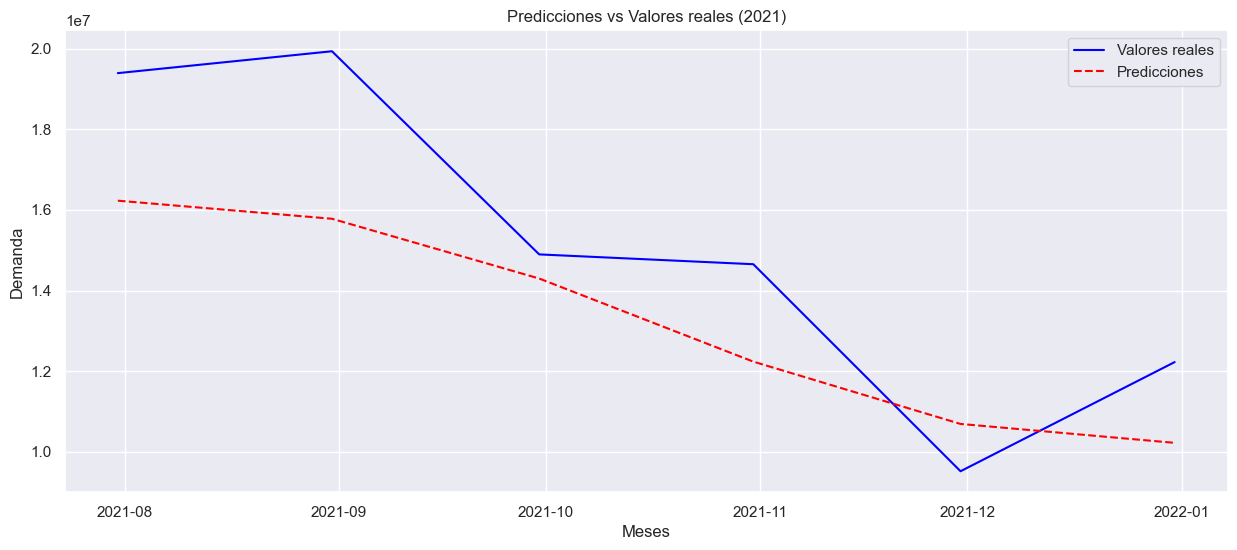

In [202]:
LSTMDemandaMensual(6,dataMes)

## LSTM para predecir la producción con todas las caracteristicas por meses

In [214]:
dataMes= data.resample('m').sum()
dataMes


Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12224975     8528453

In [215]:
def LSTMProduccionMensual(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_months = ["2019-05", "2019-06", "2020-04", "2020-05", "2021-04", "2021-05"]
    shaaban_months = ["2019-04", "2019-05", "2020-03", "2020-04", "2021-03", "2021-04"]

    data['Ramadan'] = data.index.strftime('%Y-%m').isin(ramadan_months).astype(int)
    data['Shaaban'] = data.index.strftime('%Y-%m').isin(shaaban_months).astype(int)

    festivos = ["2019-01", "2019-05", "2019-07", "2019-10", "2020-01", "2020-05", "2020-07", "2020-10", "2021-01", "2021-05", "2021-07", "2021-10"]
    data['Festivo'] = data.index.strftime('%Y-%m').isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

 
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
   
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Meses")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()


        Cogiendo el mes anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.3430 - val_loss: 0.4008
Epoch 2/50
1/1 [==============================] - 0s 47ms/step - loss: 0.3399 - val_loss: 0.3973
Epoch 3/50
1/1 [==============================] - 0s 56ms/step - loss: 0.3367 - val_loss: 0.3937
Epoch 4/50
1/1 [==============================] - 0s 63ms/step - loss: 0.3335 - val_loss: 0.3902
Epoch 5/50
1/1 [==============================] - 0s 50ms/step - loss: 0.3303 - val_loss: 0.3866
Epoch 6/50
1/1 [==============================] - 0s 67ms/step - loss: 0.3271 - val_loss: 0.3830
Epoch 7/50
1/1 [==============================] - 0s 63ms/step - loss: 0.3238 - val_loss: 0.3794
Epoch 8/50
1/1 [==============================] - 0s 61ms/step - loss: 0.3206 - val_loss: 0.3758
Epoch 9/50
1/1 [==============================] - 0s 56ms/step - loss: 0.3173 - val_loss: 0.3721
Epoch 10/50
1/1 [==============================] - 0s 51ms/step - loss: 0.3139 - val_loss: 0.3684
Epoch 11/50
1/1 [==============

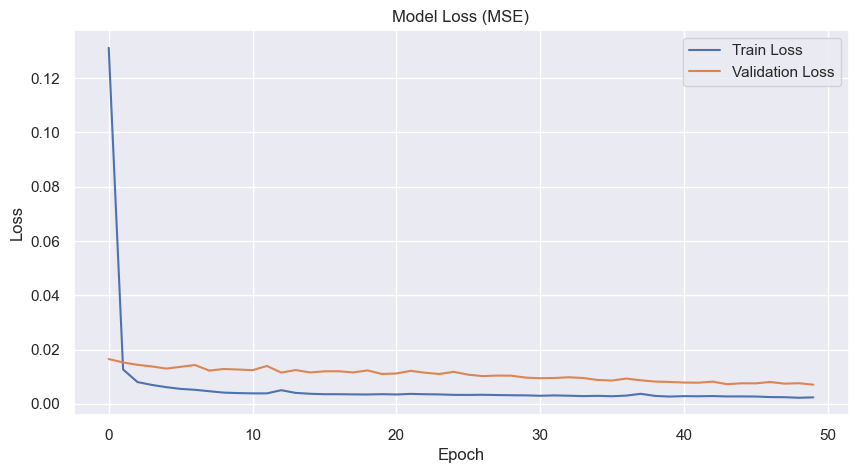

1/1 [==============================] - 0s 425ms/step
    Real Values  Predictions
0       7253635    8904202.0
1       7317690    8377422.0
2       8450198    8812596.0
3      11166675    9851660.0
4      11921123   10027944.0
5      13231958    9294898.0
6      13392505    9983033.0
7      11319400    9637815.0
8      10581169    9142852.0
9       7544319    8878003.0
10      8528453    8228458.5
Accuracy basado en un umbral del 1.0%: 0.00%


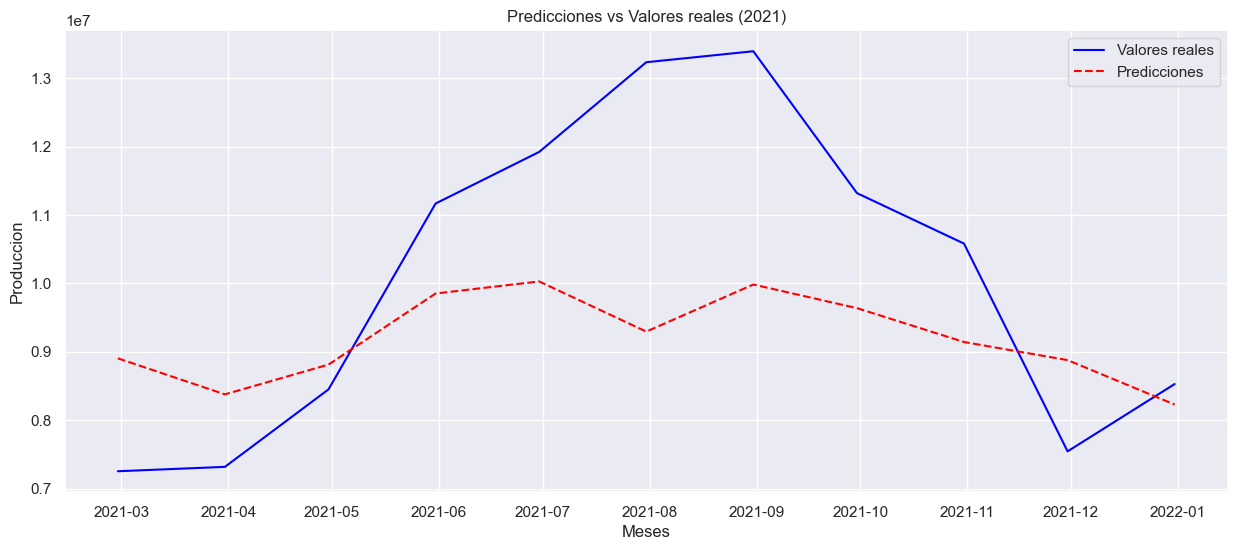

In [216]:
LSTMProduccionMensual(1,dataMes)


        Cogiendo 6 meses anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.3705 - val_loss: 0.5014
Epoch 2/50
1/1 [==============================] - 0s 46ms/step - loss: 0.3580 - val_loss: 0.4870
Epoch 3/50
1/1 [==============================] - 0s 45ms/step - loss: 0.3465 - val_loss: 0.4729
Epoch 4/50
1/1 [==============================] - 0s 105ms/step - loss: 0.3354 - val_loss: 0.4586
Epoch 5/50
1/1 [==============================] - 0s 47ms/step - loss: 0.3241 - val_loss: 0.4442
Epoch 6/50
1/1 [==============================] - 0s 46ms/step - loss: 0.3126 - val_loss: 0.4291
Epoch 7/50
1/1 [==============================] - 0s 44ms/step - loss: 0.3007 - val_loss: 0.4131
Epoch 8/50
1/1 [==============================] - 0s 62ms/step - loss: 0.2883 - val_loss: 0.3960
Epoch 9/50
1/1 [==============================] - 0s 85ms/step - loss: 0.2752 - val_loss: 0.3781
Epoch 10/50
1/1 [==============================] - 0s 70ms/step - loss: 0.2613 - val_loss: 0.3590
Epoch 11/50
1/1 [=============

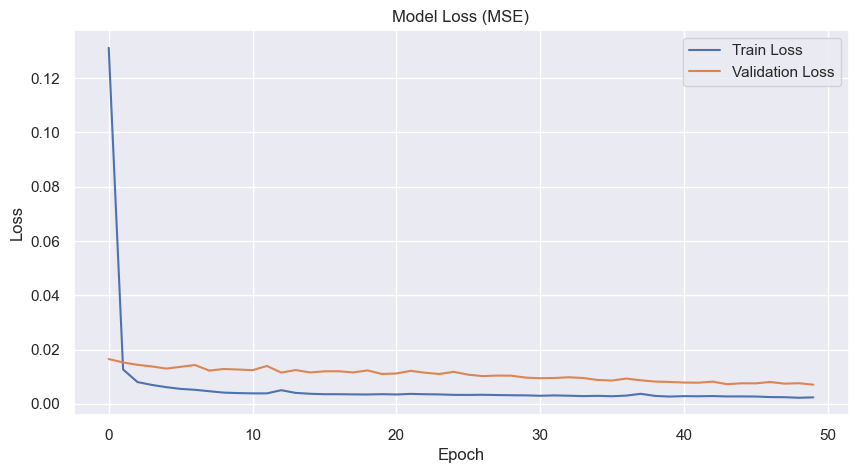

1/1 [==============================] - 1s 717ms/step
   Real Values  Predictions
0     13231958   12494921.0
1     13392505   12065728.0
2     11319400   11108488.0
3     10581169    9437733.0
4      7544319    8280567.0
5      8528453    7926882.0
Accuracy basado en un umbral del 1.0%: 0.00%


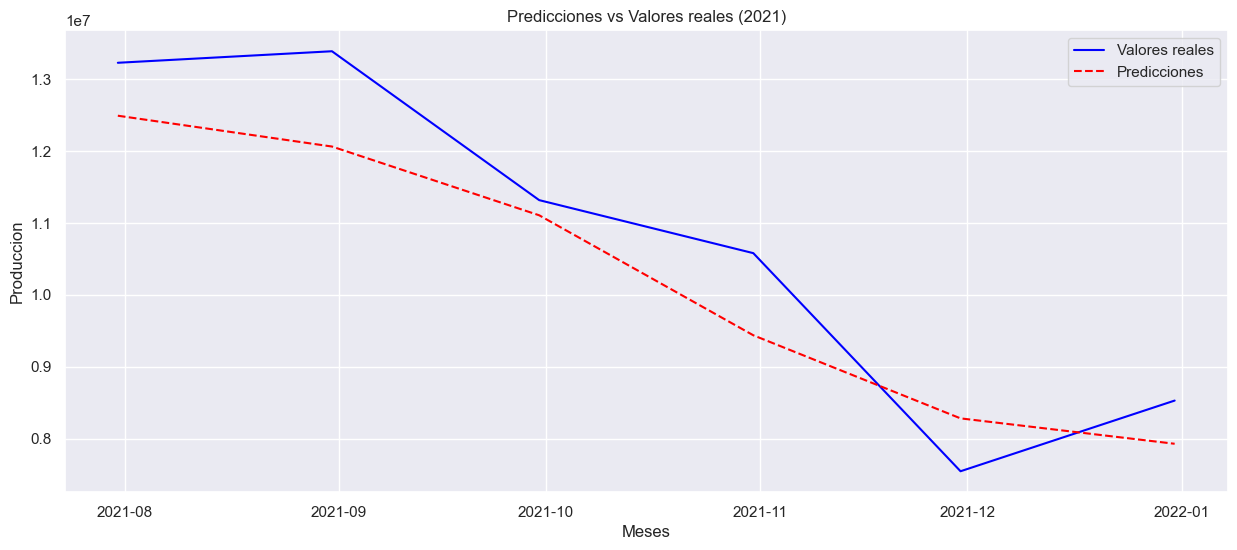

In [217]:
LSTMProduccionMensual(6,dataMes)

## LSTM para predecir la demanda de un mes en concreto en con todas las caracteristicas por días

In [41]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index


In [54]:
def LSTMDemandaDiariaPorMeses(time_steps, data, month_to_predict):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)
    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year != 2021)]
    train_target = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year == 2021)]
    val_target = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]


    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    history=model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.05
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()
 

Epoch 1/50
2/2 [==============================] - 4s 428ms/step - loss: 0.2680 - val_loss: 0.2339
Epoch 2/50
2/2 [==============================] - 0s 62ms/step - loss: 0.2503 - val_loss: 0.2217
Epoch 3/50
2/2 [==============================] - 0s 66ms/step - loss: 0.2336 - val_loss: 0.2101
Epoch 4/50
2/2 [==============================] - 0s 59ms/step - loss: 0.2150 - val_loss: 0.1988
Epoch 5/50
2/2 [==============================] - 0s 61ms/step - loss: 0.1964 - val_loss: 0.1869
Epoch 6/50
2/2 [==============================] - 0s 53ms/step - loss: 0.1787 - val_loss: 0.1745
Epoch 7/50
2/2 [==============================] - 0s 56ms/step - loss: 0.1584 - val_loss: 0.1610
Epoch 8/50
2/2 [==============================] - 0s 51ms/step - loss: 0.1351 - val_loss: 0.1469
Epoch 9/50
2/2 [==============================] - 0s 58ms/step - loss: 0.1145 - val_loss: 0.1326
Epoch 10/50
2/2 [==============================] - 0s 57ms/step - loss: 0.0940 - val_loss: 0.1195
Epoch 11/50
2/2 [===========

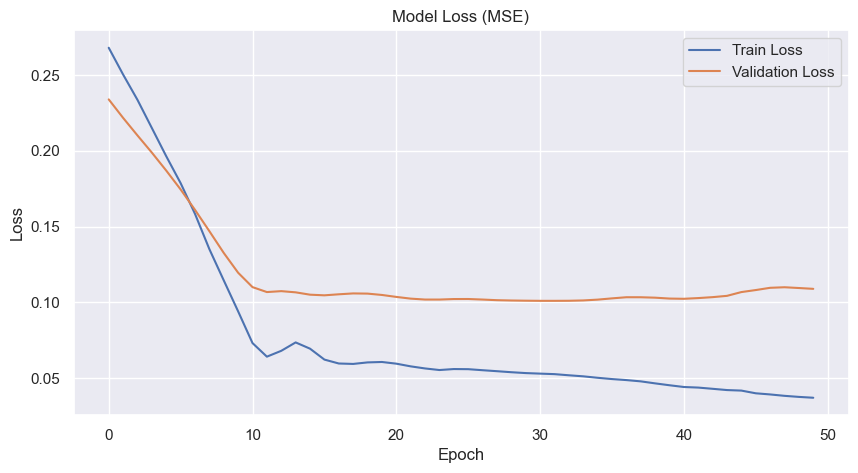

1/1 [==============================] - 0s 494ms/step
    Real Values   Predictions
0        353577  382048.87500
1        333476  377147.06250
2        319228  372964.53125
3        291080  368018.87500
4        318794  361277.75000
5        373945  355307.71875
6        372357  352994.75000
7        360640  352699.40625
8        473028  354340.93750
9        416444  363172.62500
10       381620  371386.71875
11       419341  377324.84375
12       368549  385512.65625
13       362425  389964.81250
14       364235  391329.12500
15       363589  388986.00000
16       349016  384054.53125
17       336906  378323.90625
Accuracy basado en un umbral del 5.0%: 22.22%


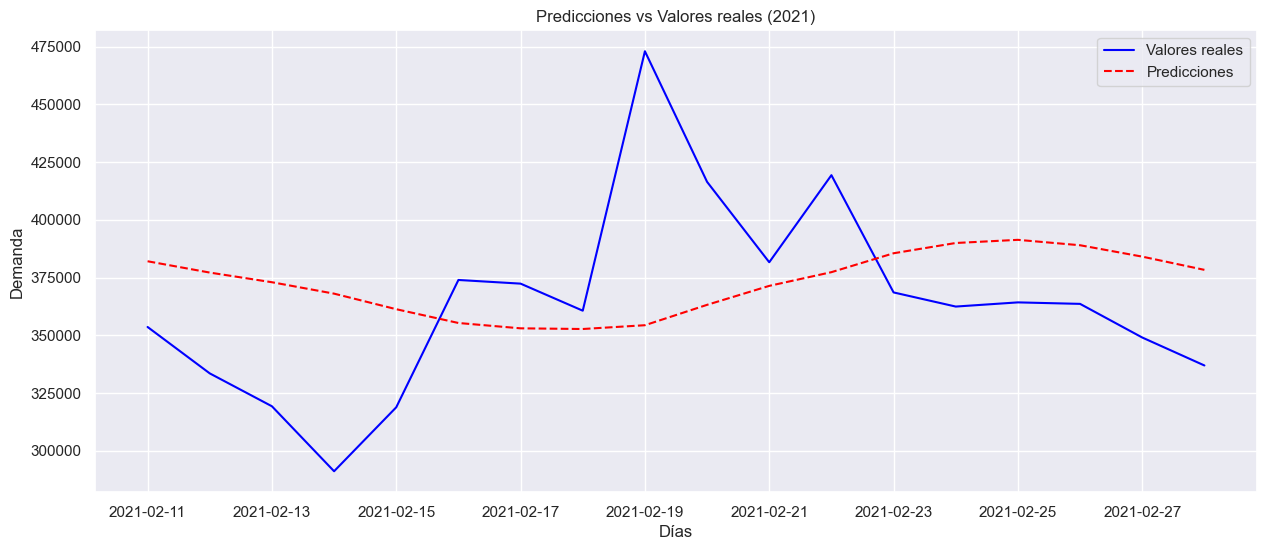

In [55]:
LSTMDemandaDiariaPorMeses(10, dataFullCaracteristicas, 2)

# LSTM para predecir la demanda de un mes en concreto con todas las caracteristicas por días según configuración

In [32]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index


In [33]:
dataFullCaracteristicas

Demanda  Produccion
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-29   411592      261122
2021-12-30   378184      248905
2021-12-31   414996      257533
2022-01-01   437452      272710
2022-01-02   417780      277922

[1098 rows x 2 columns]

In [34]:
def LSTMDemandaDiariaPorMesesConfig(time_steps, data, month_to_predict, config):

    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)
    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year != 2021)]
    train_target = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year == 2021)]
    val_target = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]


    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    # para meter las capas
    for i in range(config['layers']):
        return_seq = config['return_sequence'] if i < config['layers'] - 1 else False
        model.add(LSTM(config['units'], activation='relu', return_sequences=return_seq, 
                       recurrent_dropout=config['recurrent_dropout'], 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
    #la dense
    for units in config['dense_layers']:
        model.add(Dense(units, activation='relu'))
        if config['dense_dropout'] > 0:
            model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=1)

    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()
    return history.history['val_loss'][-1]
 

In [3]:
config1 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128]
}


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3162 - val_loss: 0.3535
Epoch 2/200
1/1 [==============================] - 0s 72ms/step - loss: 0.2937 - val_loss: 0.3352
Epoch 3/200
1/1 [==============================] - 0s 72ms/step - loss: 0.2698 - val_loss: 0.3121
Epoch 4/200
1/1 [==============================] - 0s 73ms/step - loss: 0.2416 - val_loss: 0.2851
Epoch 5/200
1/1 [==============================] - 0s 72ms/step - loss: 0.2096 - val_loss: 0.2544
Epoch 6/200
1/1 [==============================] - 0s 73ms/step - loss: 0.1742 - val_loss: 0.2201
Epoch 7/200
1/1 [==============================] - 0s 72ms/step - loss: 0.1361 - val_loss: 0.1830
Epoch 8/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0975 - val_loss: 0.1447
Epoch 9/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0630 - val_loss: 0.1096
Epoch 10/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0415 - val_loss: 0.0854
Epoch 11/200
1/1 [===

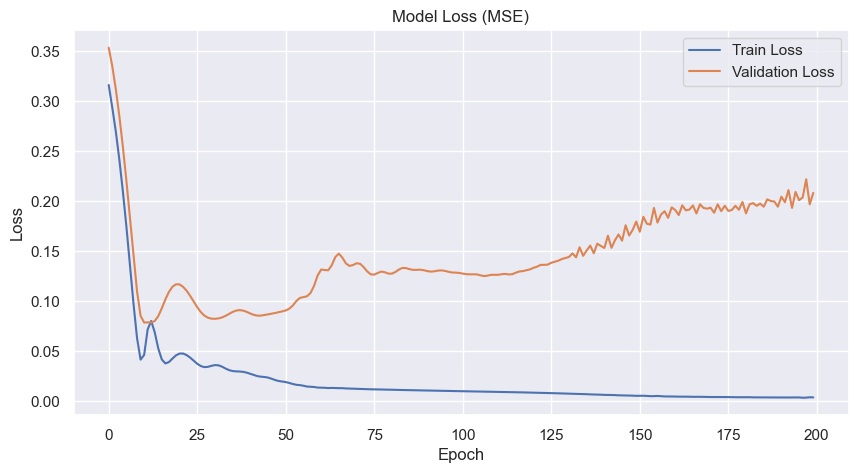

1/1 [==============================] - 0s 197ms/step
    Real Values   Predictions
0        416401  414740.62500
1        422912  444051.37500
2        426802  446118.00000
3        418290  445105.65625
4        421703  442038.93750
5        412939  438267.56250
6        421758  439471.68750
7        446306  436259.90625
8        447156  436151.15625
9        444662  436821.93750
10       514133  441289.84375
11       433443  450810.40625
12       420410  454533.46875
13       411592  459353.90625
14       378184  463050.37500
15       414996  462131.87500
16       437452  466002.56250
17       417780  468846.90625
18       406326  464275.00000
19       406326  456490.15625
20       403046  451857.59375
Accuracy basado en un umbral del 1.0%: 4.76%


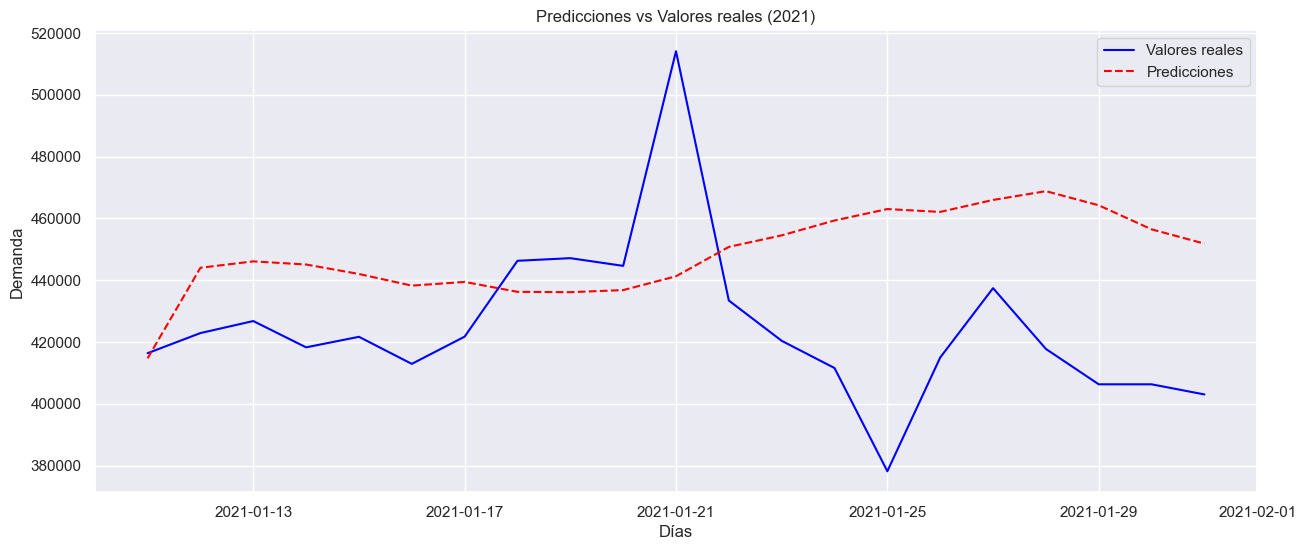

In [67]:

LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config1)

Configuración base con más unidades en la capa LSTM:

In [6]:

config2 = {
    'layers': 1,
    'units': 256,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [64, 128]
}

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3140 - val_loss: 0.3466
Epoch 2/200
1/1 [==============================] - 0s 100ms/step - loss: 0.2856 - val_loss: 0.3202
Epoch 3/200
1/1 [==============================] - 0s 86ms/step - loss: 0.2582 - val_loss: 0.2921
Epoch 4/200
1/1 [==============================] - 0s 95ms/step - loss: 0.2283 - val_loss: 0.2594
Epoch 5/200
1/1 [==============================] - 0s 104ms/step - loss: 0.1928 - val_loss: 0.2219
Epoch 6/200
1/1 [==============================] - 0s 93ms/step - loss: 0.1512 - val_loss: 0.1806
Epoch 7/200
1/1 [==============================] - 0s 101ms/step - loss: 0.1062 - val_loss: 0.1379
Epoch 8/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0630 - val_loss: 0.1005
Epoch 9/200
1/1 [==============================] - 0s 101ms/step - loss: 0.0353 - val_loss: 0.0854
Epoch 10/200
1/1 [==============================] - 0s 123ms/step - loss: 0.0520 - val_loss: 0.0918
Epoch 11/200
1/1

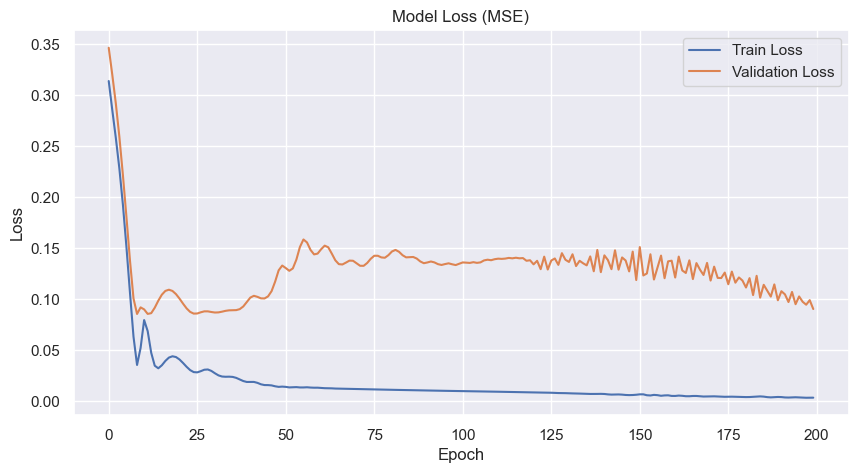

1/1 [==============================] - 0s 212ms/step
    Real Values   Predictions
0        416401  415169.93750
1        422912  437742.65625
2        426802  439268.40625
3        418290  436681.21875
4        421703  433868.18750
5        412939  433868.43750
6        421758  430421.12500
7        446306  426526.87500
8        447156  429991.90625
9        444662  436136.37500
10       514133  439593.40625
11       433443  444929.37500
12       420410  443334.87500
13       411592  441662.84375
14       378184  439191.00000
15       414996  434176.03125
16       437452  432890.96875
17       417780  430068.68750
18       406326  425800.71875
19       406326  421432.78125
20       403046  420930.37500
Accuracy basado en un umbral del 1.0%: 4.76%


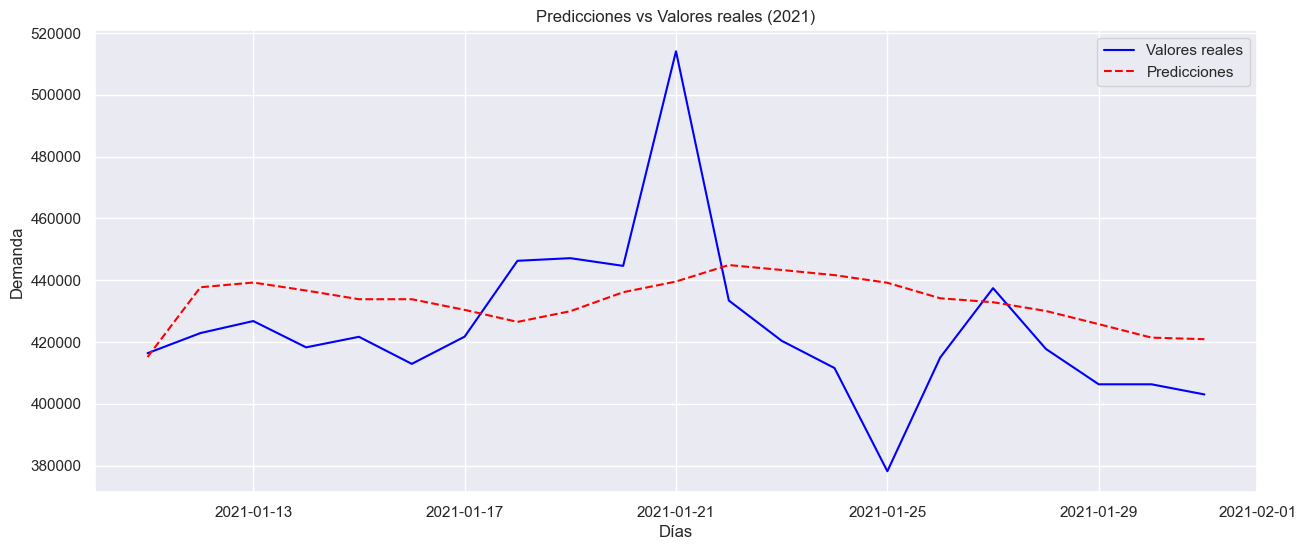

In [69]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config2)

Configuración con múltiples capas LSTM

In [7]:
config3 = {
    'layers': 2,
    'units': 128,
    'return_sequence': True,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64]
}

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.3116 - val_loss: 0.3504
Epoch 2/200
1/1 [==============================] - 0s 120ms/step - loss: 0.2920 - val_loss: 0.3322
Epoch 3/200
1/1 [==============================] - 0s 139ms/step - loss: 0.2697 - val_loss: 0.3112
Epoch 4/200
1/1 [==============================] - 0s 113ms/step - loss: 0.2453 - val_loss: 0.2865
Epoch 5/200
1/1 [==============================] - 0s 110ms/step - loss: 0.2169 - val_loss: 0.2573
Epoch 6/200
1/1 [==============================] - 0s 112ms/step - loss: 0.1834 - val_loss: 0.2236
Epoch 7/200
1/1 [==============================] - 0s 116ms/step - loss: 0.1455 - val_loss: 0.1857
Epoch 8/200
1/1 [==============================] - 0s 115ms/step - loss: 0.1047 - val_loss: 0.1447
Epoch 9/200
1/1 [==============================] - 0s 129ms/step - loss: 0.0660 - val_loss: 0.1067
Epoch 10/200
1/1 [==============================] - 0s 130ms/step - loss: 0.0435 - val_loss: 0.0860
Epoch 11/200

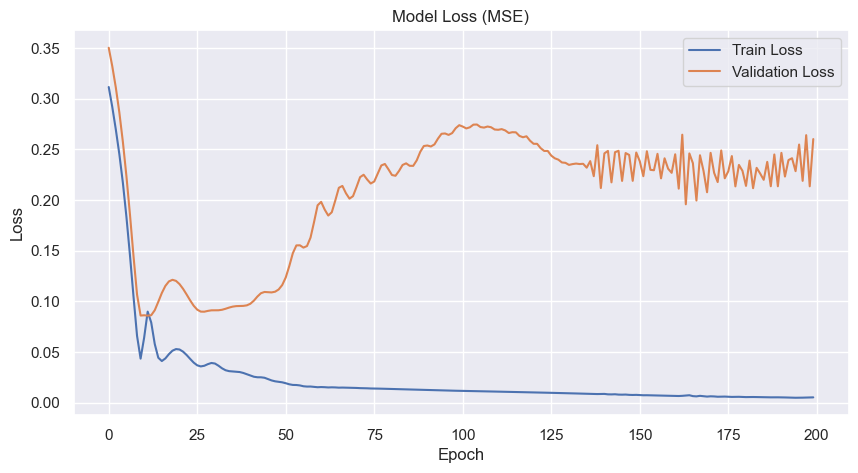

1/1 [==============================] - 0s 429ms/step
    Real Values   Predictions
0        416401  417511.40625
1        422912  450060.34375
2        426802  451514.90625
3        418290  448440.40625
4        421703  443071.46875
5        412939  437676.21875
6        421758  441398.87500
7        446306  436192.59375
8        447156  438158.21875
9        444662  446186.62500
10       514133  455334.84375
11       433443  462720.84375
12       420410  468608.25000
13       411592  476257.90625
14       378184  480954.50000
15       414996  478908.84375
16       437452  476247.81250
17       417780  472406.00000
18       406326  461549.56250
19       406326  455837.56250
20       403046  451140.81250
Accuracy basado en un umbral del 1.0%: 9.52%


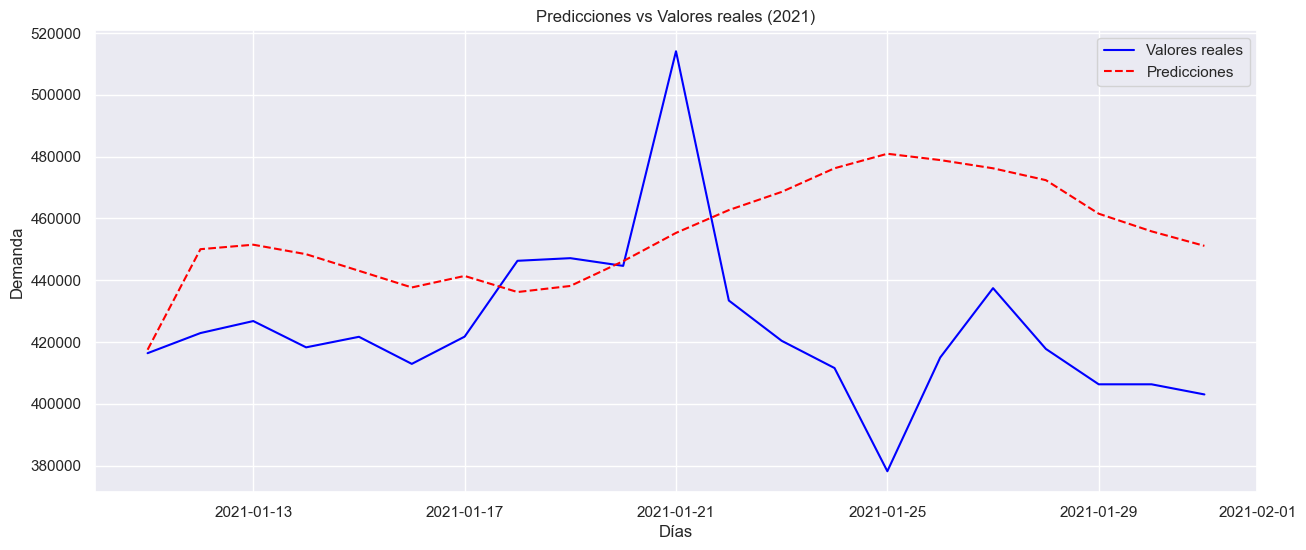

In [71]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config3)

Configuración con dropout:

In [8]:
config4 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0.2,
    'dense_dropout': 0.3,
    'dense_layers': [64]
}

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.3204 - val_loss: 0.3532
Epoch 2/200
1/1 [==============================] - 0s 90ms/step - loss: 0.2941 - val_loss: 0.3328
Epoch 3/200
1/1 [==============================] - 0s 82ms/step - loss: 0.2706 - val_loss: 0.3126
Epoch 4/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2462 - val_loss: 0.2932
Epoch 5/200
1/1 [==============================] - 0s 78ms/step - loss: 0.2219 - val_loss: 0.2736
Epoch 6/200
1/1 [==============================] - 0s 64ms/step - loss: 0.1974 - val_loss: 0.2528
Epoch 7/200
1/1 [==============================] - 0s 88ms/step - loss: 0.1728 - val_loss: 0.2309
Epoch 8/200
1/1 [==============================] - 0s 75ms/step - loss: 0.1468 - val_loss: 0.2075
Epoch 9/200
1/1 [==============================] - 0s 74ms/step - loss: 0.1215 - val_loss: 0.1826
Epoch 10/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0953 - val_loss: 0.1567
Epoch 11/200
1/1 [===

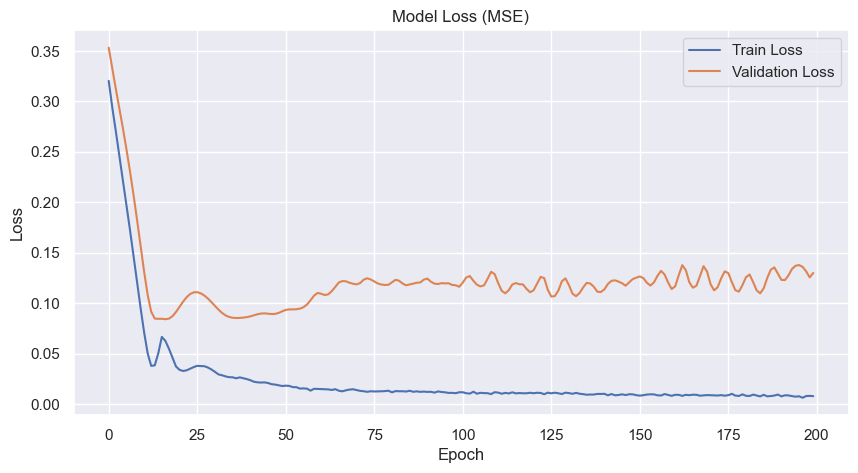

1/1 [==============================] - 0s 272ms/step
    Real Values   Predictions
0        416401  423103.90625
1        422912  435195.12500
2        426802  436632.21875
3        418290  437006.31250
4        421703  436159.34375
5        412939  436043.06250
6        421758  430922.46875
7        446306  429617.75000
8        447156  432544.34375
9        444662  435823.12500
10       514133  440061.81250
11       433443  453286.43750
12       420410  453645.68750
13       411592  451307.59375
14       378184  448850.31250
15       414996  440840.43750
16       437452  442638.81250
17       417780  446871.06250
18       406326  444335.43750
19       406326  439295.43750
20       403046  436880.18750
Accuracy basado en un umbral del 1.0%: 0.00%


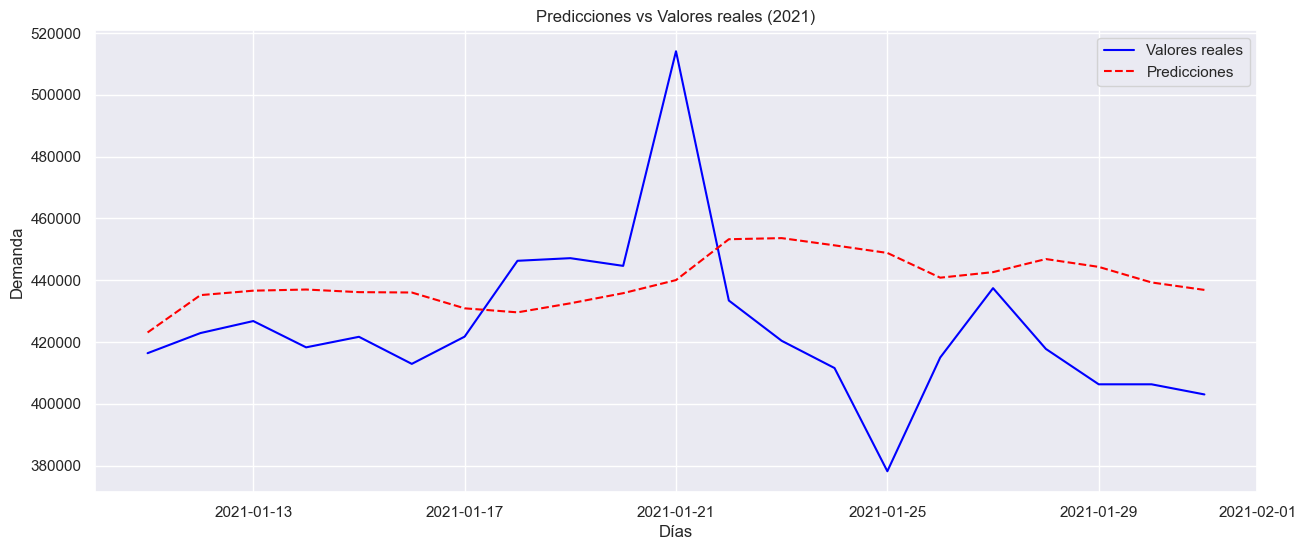

In [73]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config4)

Configuración con más capas denses

In [9]:
config5 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128, 64]
}

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3172 - val_loss: 0.3582
Epoch 2/200
1/1 [==============================] - 0s 101ms/step - loss: 0.3040 - val_loss: 0.3430
Epoch 3/200
1/1 [==============================] - 0s 56ms/step - loss: 0.2870 - val_loss: 0.3247
Epoch 4/200
1/1 [==============================] - 0s 79ms/step - loss: 0.2667 - val_loss: 0.3027
Epoch 5/200
1/1 [==============================] - 0s 79ms/step - loss: 0.2424 - val_loss: 0.2769
Epoch 6/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2141 - val_loss: 0.2470
Epoch 7/200
1/1 [==============================] - 0s 79ms/step - loss: 0.1813 - val_loss: 0.2127
Epoch 8/200
1/1 [==============================] - 0s 63ms/step - loss: 0.1441 - val_loss: 0.1746
Epoch 9/200
1/1 [==============================] - 0s 78ms/step - loss: 0.1044 - val_loss: 0.1351
Epoch 10/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0668 - val_loss: 0.0998
Epoch 11/200
1/1 [==

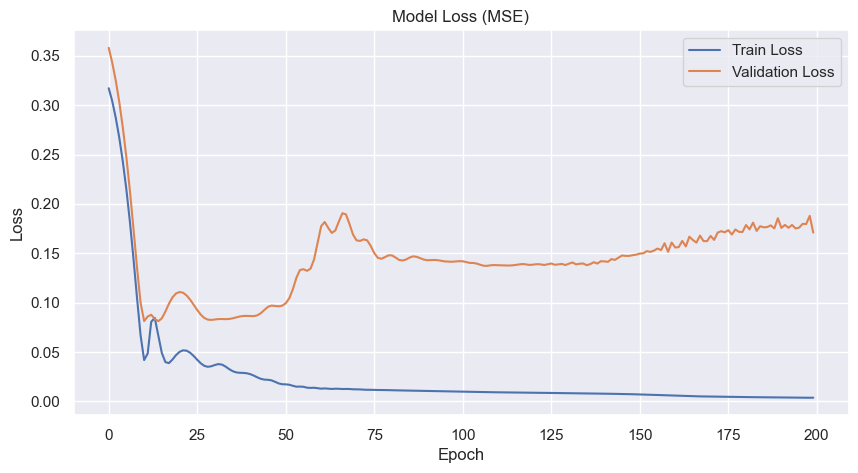

1/1 [==============================] - 0s 220ms/step
    Real Values   Predictions
0        416401  424937.59375
1        422912  444976.12500
2        426802  446672.59375
3        418290  445903.03125
4        421703  444427.28125
5        412939  443954.03125
6        421758  441280.46875
7        446306  439384.50000
8        447156  442603.40625
9        444662  445287.59375
10       514133  449335.21875
11       433443  458985.56250
12       420410  460990.15625
13       411592  459816.56250
14       378184  456952.93750
15       414996  451799.84375
16       437452  451398.15625
17       417780  452615.06250
18       406326  451532.84375
19       406326  448543.43750
20       403046  448877.50000
Accuracy basado en un umbral del 1.0%: 4.76%


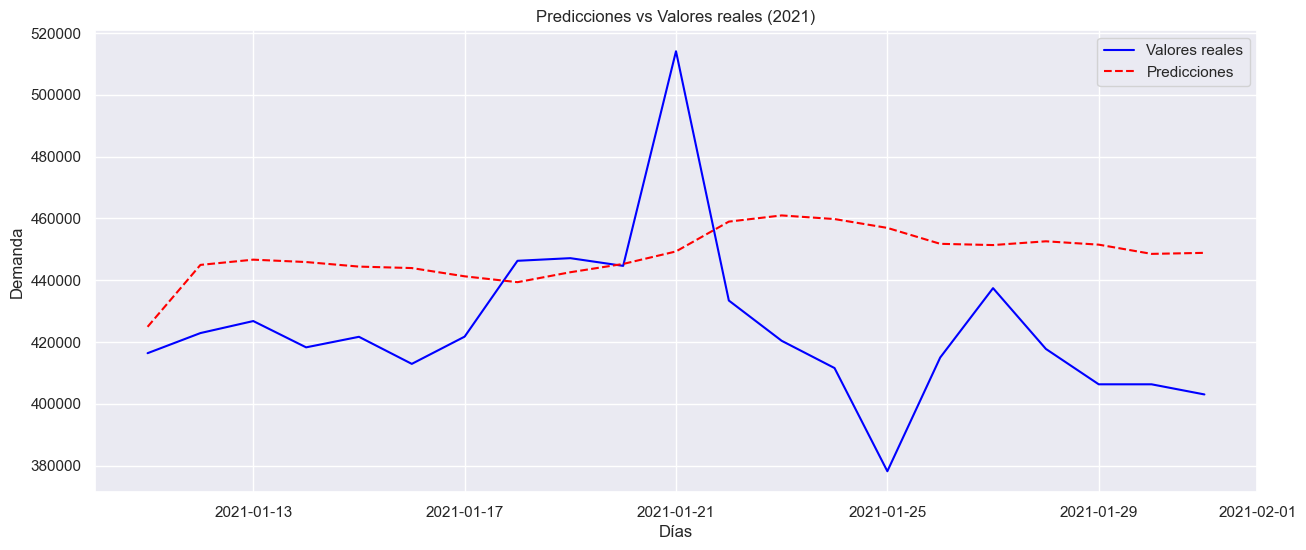

In [75]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config5)

Configuración simple para evitar sobre ajustes

In [10]:
config6 = {
    'layers': 1,
    'units': 64,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0,
    'dense_layers': [32]
}

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.3049 - val_loss: 0.3557
Epoch 2/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2853 - val_loss: 0.3385
Epoch 3/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2663 - val_loss: 0.3229
Epoch 4/200
1/1 [==============================] - 0s 49ms/step - loss: 0.2482 - val_loss: 0.3077
Epoch 5/200
1/1 [==============================] - 0s 45ms/step - loss: 0.2315 - val_loss: 0.2926
Epoch 6/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2160 - val_loss: 0.2780
Epoch 7/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2008 - val_loss: 0.2643
Epoch 8/200
1/1 [==============================] - 0s 47ms/step - loss: 0.1861 - val_loss: 0.2510
Epoch 9/200
1/1 [==============================] - 0s 47ms/step - loss: 0.1719 - val_loss: 0.2377
Epoch 10/200
1/1 [==============================] - 0s 47ms/step - loss: 0.1579 - val_loss: 0.2244
Epoch 11/200
1/1 [===

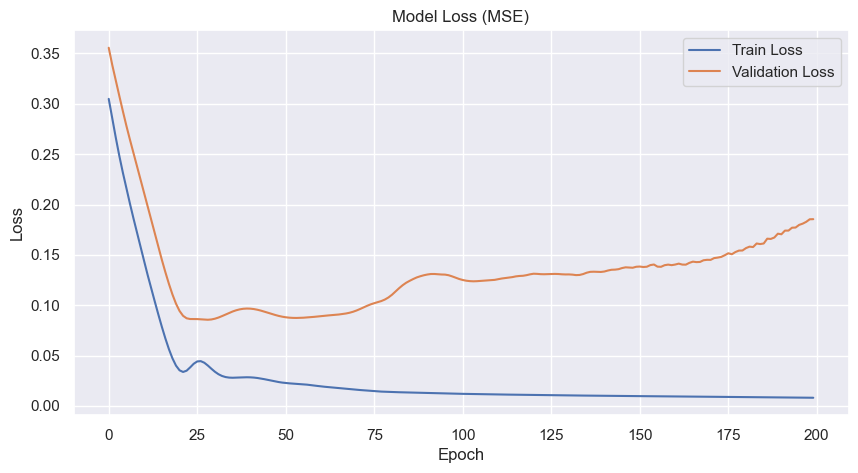

1/1 [==============================] - 0s 173ms/step
    Real Values   Predictions
0        416401  425586.18750
1        422912  441150.65625
2        426802  442465.96875
3        418290  441502.68750
4        421703  438765.15625
5        412939  437935.06250
6        421758  439559.28125
7        446306  437383.84375
8        447156  439245.71875
9        444662  442568.28125
10       514133  446910.46875
11       433443  465646.87500
12       420410  468253.43750
13       411592  466431.43750
14       378184  465043.00000
15       414996  458180.28125
16       437452  458441.68750
17       417780  458868.96875
18       406326  452172.34375
19       406326  442890.65625
20       403046  438837.50000
Accuracy basado en un umbral del 1.0%: 4.76%


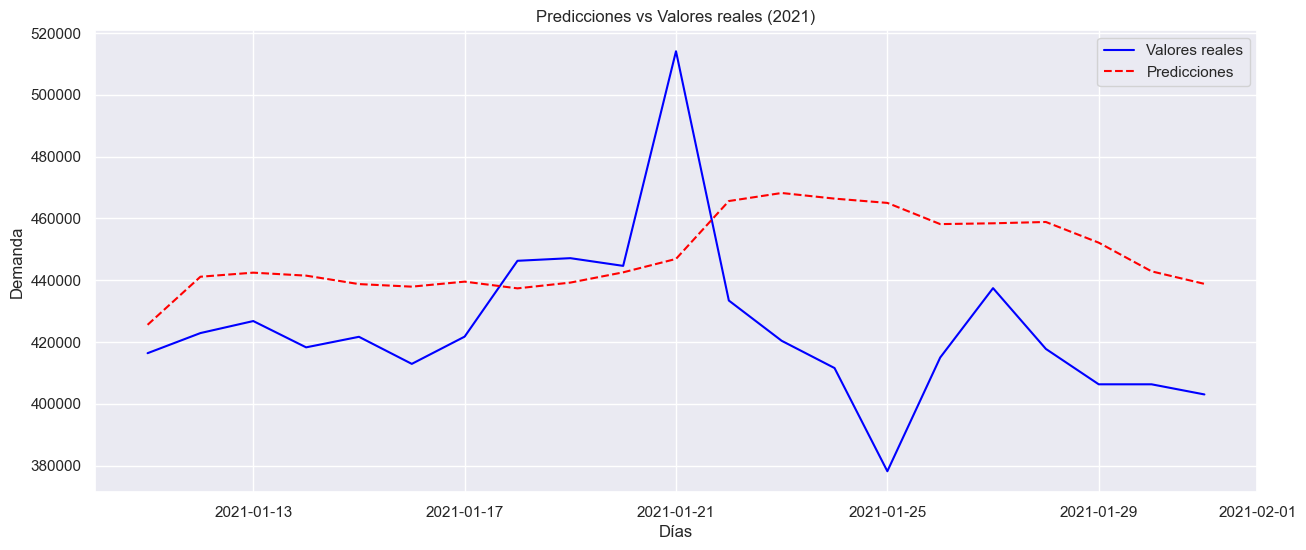

In [77]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config6)

# Compración para sacar la mejor configuración

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3144 - val_loss: 0.3478
Epoch 2/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2919 - val_loss: 0.3265
Epoch 3/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2684 - val_loss: 0.3031
Epoch 4/200
1/1 [==============================] - 0s 82ms/step - loss: 0.2424 - val_loss: 0.2766
Epoch 5/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2127 - val_loss: 0.2466
Epoch 6/200
1/1 [==============================] - 0s 78ms/step - loss: 0.1797 - val_loss: 0.2137
Epoch 7/200
1/1 [==============================] - 0s 81ms/step - loss: 0.1439 - val_loss: 0.1788
Epoch 8/200
1/1 [==============================] - 0s 81ms/step - loss: 0.1072 - val_loss: 0.1436
Epoch 9/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0731 - val_loss: 0.1117
Epoch 10/200
1/1 [==============================] - 0s 86ms/step - loss: 0.0480 - val_loss: 0.0891
Epoch 11/200
1/1 [===

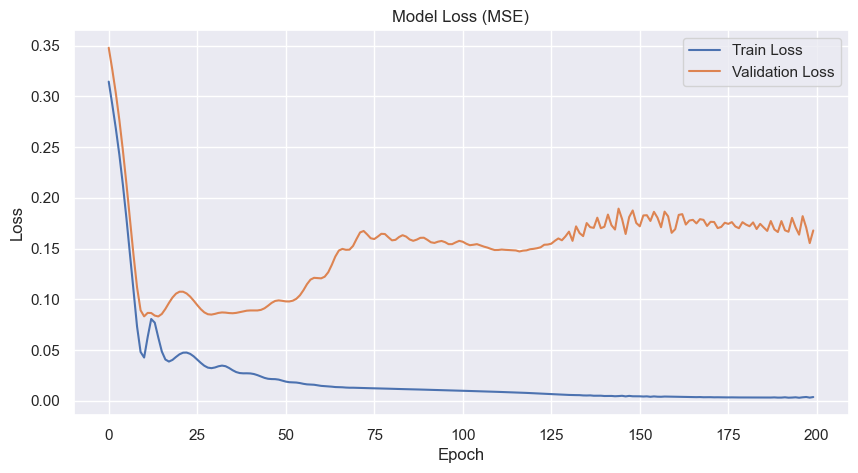

1/1 [==============================] - 0s 272ms/step
    Real Values   Predictions
0        416401  431603.68750
1        422912  444063.71875
2        426802  445515.84375
3        418290  444591.37500
4        421703  443338.81250
5        412939  444225.40625
6        421758  436522.21875
7        446306  435027.12500
8        447156  439921.75000
9        444662  445721.68750
10       514133  451931.46875
11       433443  468254.65625
12       420410  467374.56250
13       411592  464569.15625
14       378184  459263.18750
15       414996  450739.37500
16       437452  448518.75000
17       417780  449946.93750
18       406326  447300.40625
19       406326  441294.03125
20       403046  438987.59375
Accuracy basado en un umbral del 1.0%: 4.76%


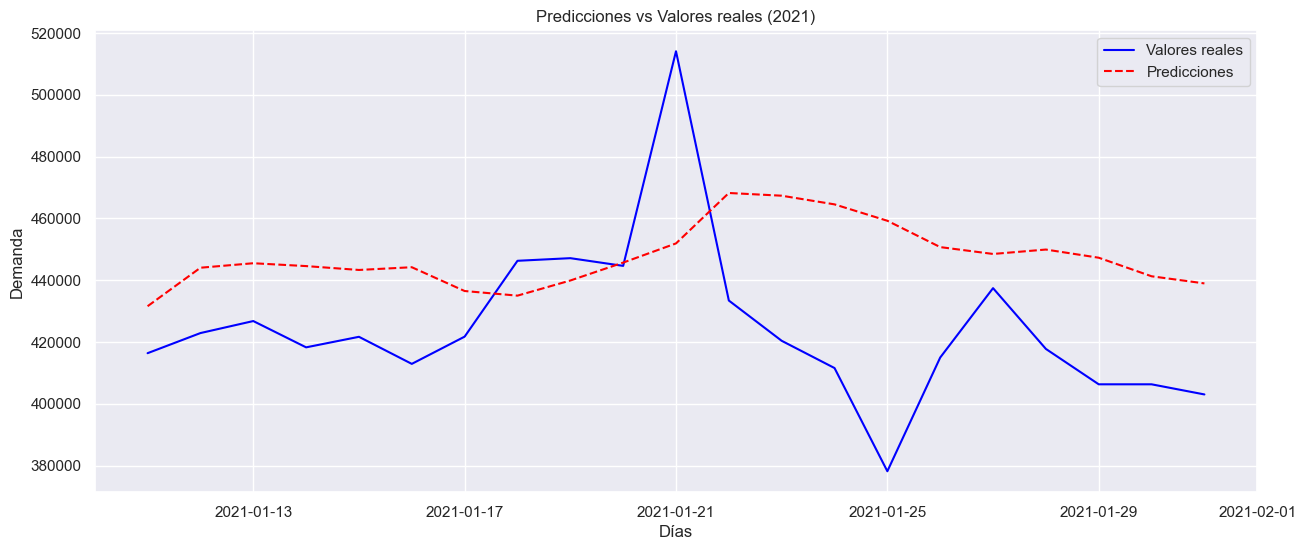

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3204 - val_loss: 0.3473
Epoch 2/200
1/1 [==============================] - 0s 110ms/step - loss: 0.2854 - val_loss: 0.3211
Epoch 3/200
1/1 [==============================] - 0s 106ms/step - loss: 0.2522 - val_loss: 0.2892
Epoch 4/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2147 - val_loss: 0.2508
Epoch 5/200
1/1 [==============================] - 0s 58ms/step - loss: 0.1712 - val_loss: 0.2067
Epoch 6/200
1/1 [==============================] - 0s 64ms/step - loss: 0.1230 - val_loss: 0.1594
Epoch 7/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0761 - val_loss: 0.1140
Epoch 8/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0422 - val_loss: 0.0853
Epoch 9/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0485 - val_loss: 0.0851
Epoch 10/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0820 - val_loss: 0.0848
Epoch 11/200
1/1 [=

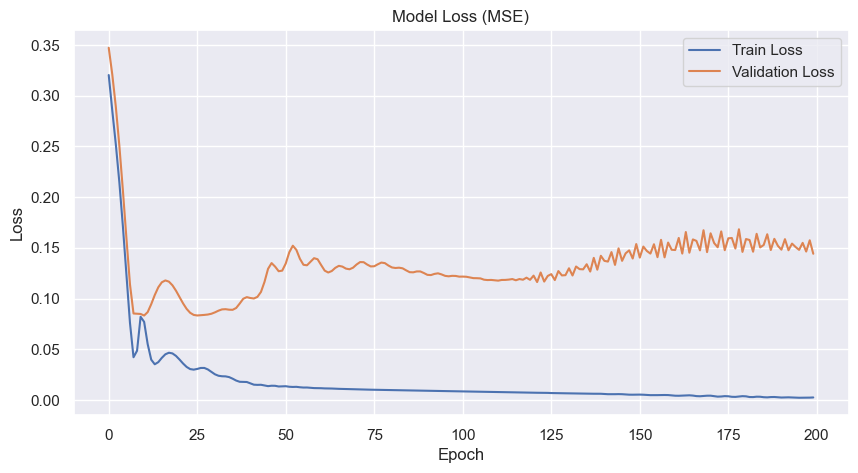

1/1 [==============================] - 0s 305ms/step
    Real Values   Predictions
0        416401  415230.96875
1        422912  440822.03125
2        426802  440199.28125
3        418290  435636.87500
4        421703  429765.93750
5        412939  428743.78125
6        421758  430473.87500
7        446306  425663.59375
8        447156  430123.25000
9        444662  438345.53125
10       514133  446378.50000
11       433443  460410.43750
12       420410  462127.62500
13       411592  462101.65625
14       378184  459144.90625
15       414996  451924.18750
16       437452  448435.18750
17       417780  445534.28125
18       406326  440159.00000
19       406326  433784.37500
20       403046  431634.03125
Accuracy basado en un umbral del 1.0%: 4.76%


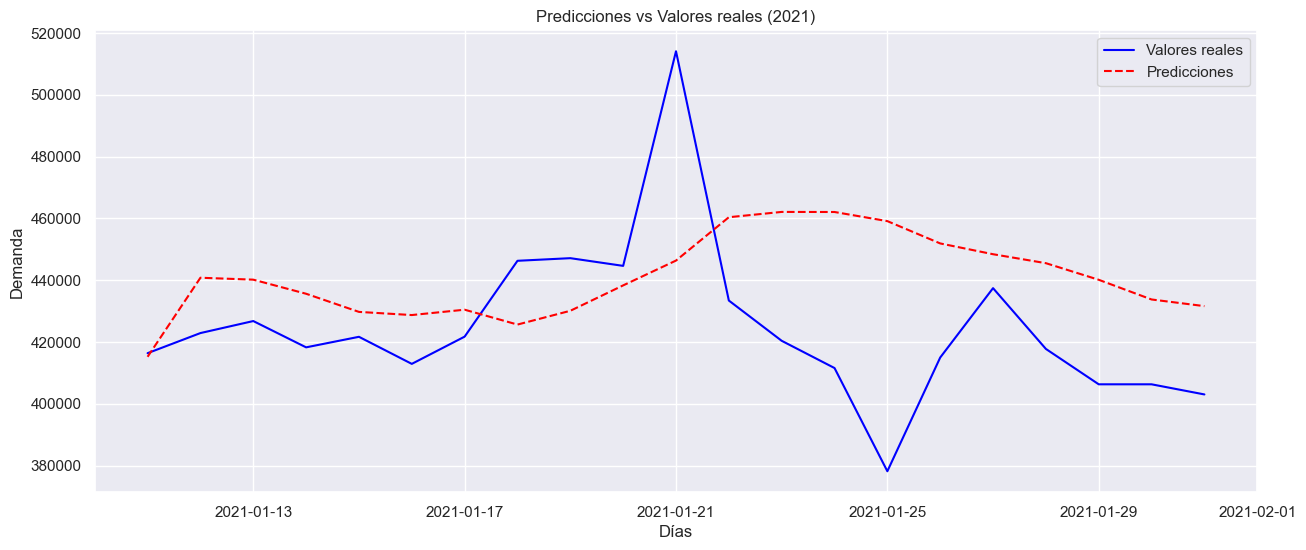

Epoch 1/200
1/1 [==============================] - 6s 6s/step - loss: 0.3226 - val_loss: 0.3637
Epoch 2/200
1/1 [==============================] - 0s 87ms/step - loss: 0.3099 - val_loss: 0.3558
Epoch 3/200
1/1 [==============================] - 0s 68ms/step - loss: 0.3012 - val_loss: 0.3475
Epoch 4/200
1/1 [==============================] - 0s 95ms/step - loss: 0.2923 - val_loss: 0.3379
Epoch 5/200
1/1 [==============================] - 0s 90ms/step - loss: 0.2820 - val_loss: 0.3268
Epoch 6/200
1/1 [==============================] - 0s 93ms/step - loss: 0.2705 - val_loss: 0.3147
Epoch 7/200
1/1 [==============================] - 0s 93ms/step - loss: 0.2571 - val_loss: 0.3012
Epoch 8/200
1/1 [==============================] - 0s 88ms/step - loss: 0.2418 - val_loss: 0.2857
Epoch 9/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2241 - val_loss: 0.2679
Epoch 10/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2035 - val_loss: 0.2474
Epoch 11/200
1/1 [===

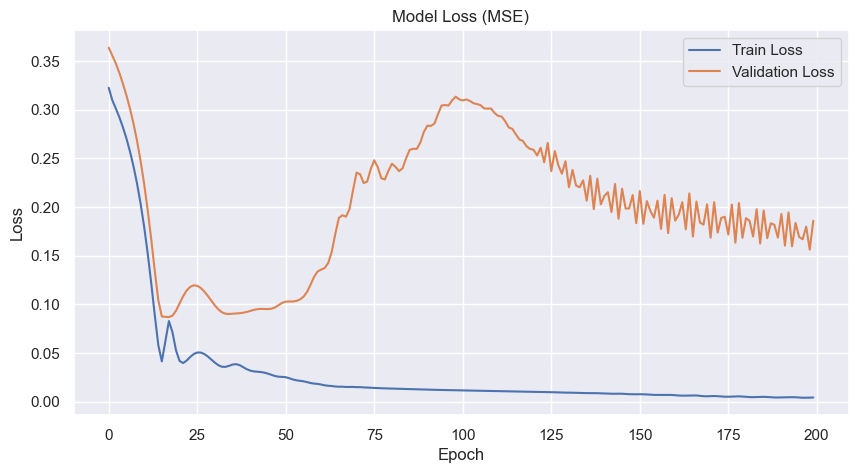

1/1 [==============================] - 0s 385ms/step
    Real Values   Predictions
0        416401  451044.34375
1        422912  454791.56250
2        426802  453653.71875
3        418290  448798.90625
4        421703  444255.12500
5        412939  440170.46875
6        421758  434339.15625
7        446306  431810.00000
8        447156  435436.15625
9        444662  444180.96875
10       514133  453246.15625
11       433443  460270.25000
12       420410  464318.96875
13       411592  468922.68750
14       378184  469616.03125
15       414996  462738.34375
16       437452  453984.71875
17       417780  445849.28125
18       406326  438361.46875
19       406326  435439.68750
20       403046  433411.37500
Accuracy basado en un umbral del 1.0%: 4.76%


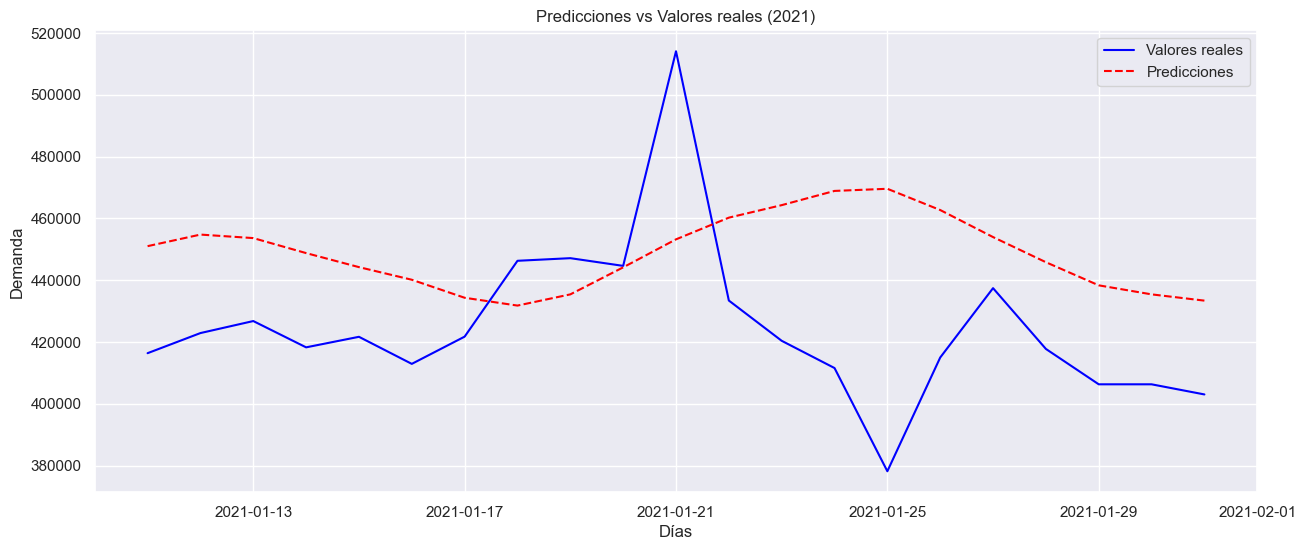

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.2965 - val_loss: 0.3278
Epoch 2/200
1/1 [==============================] - 0s 53ms/step - loss: 0.2615 - val_loss: 0.3004
Epoch 3/200
1/1 [==============================] - 0s 54ms/step - loss: 0.2298 - val_loss: 0.2704
Epoch 4/200
1/1 [==============================] - 0s 57ms/step - loss: 0.1977 - val_loss: 0.2395
Epoch 5/200
1/1 [==============================] - 0s 54ms/step - loss: 0.1638 - val_loss: 0.2084
Epoch 6/200
1/1 [==============================] - 0s 53ms/step - loss: 0.1310 - val_loss: 0.1770
Epoch 7/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0991 - val_loss: 0.1468
Epoch 8/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0702 - val_loss: 0.1199
Epoch 9/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0473 - val_loss: 0.0988
Epoch 10/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0322 - val_loss: 0.0868
Epoch 11/200
1/1 [===

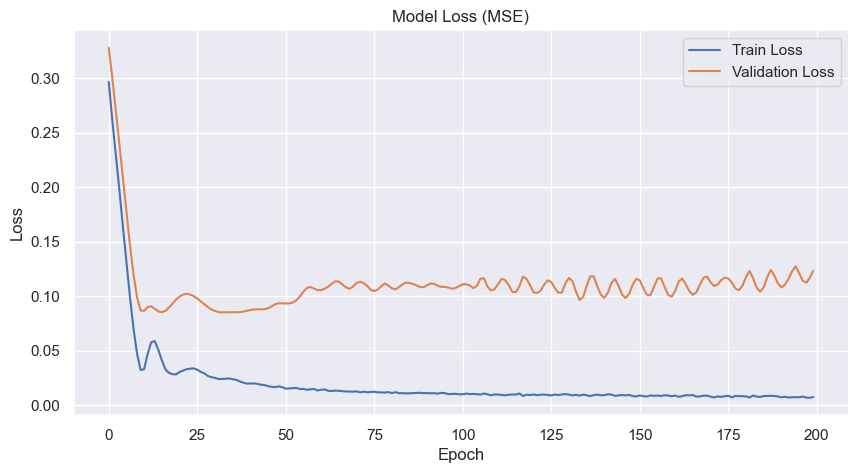

1/1 [==============================] - 0s 403ms/step
    Real Values   Predictions
0        416401  421747.81250
1        422912  431639.00000
2        426802  434280.75000
3        418290  437042.03125
4        421703  437039.15625
5        412939  438464.68750
6        421758  431795.25000
7        446306  431975.75000
8        447156  436795.21875
9        444662  440884.09375
10       514133  445002.84375
11       433443  460663.75000
12       420410  458294.12500
13       411592  453663.06250
14       378184  449356.84375
15       414996  435845.62500
16       437452  437259.43750
17       417780  443429.09375
18       406326  441432.40625
19       406326  436364.75000
20       403046  433030.59375
Accuracy basado en un umbral del 1.0%: 9.52%


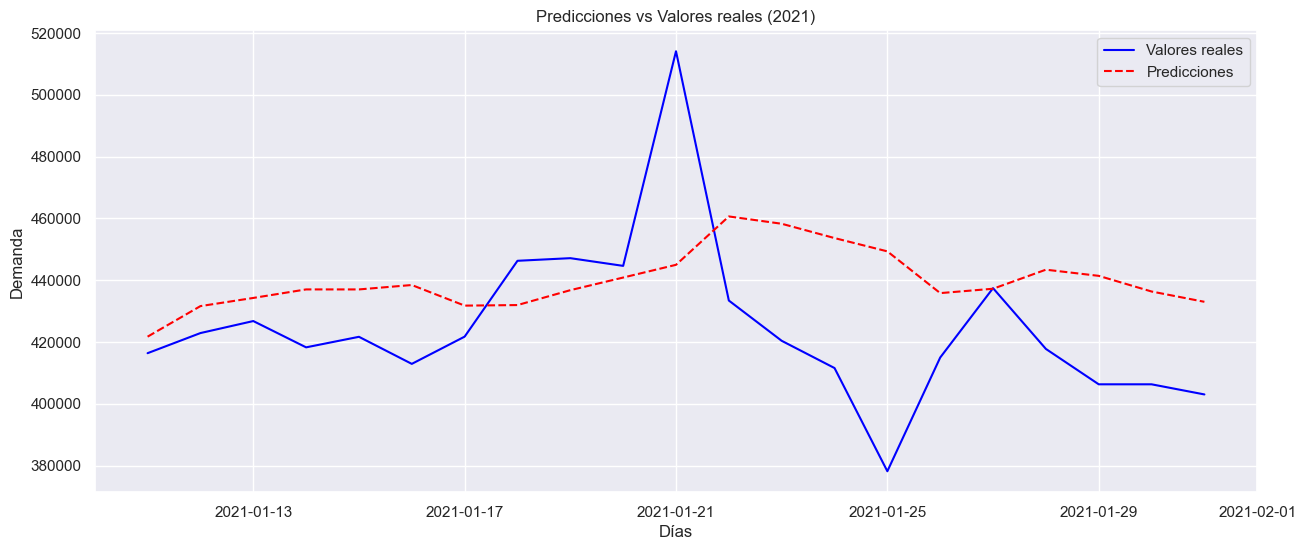

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.3181 - val_loss: 0.3623
Epoch 2/200
1/1 [==============================] - 0s 54ms/step - loss: 0.3097 - val_loss: 0.3505
Epoch 3/200
1/1 [==============================] - 0s 111ms/step - loss: 0.2983 - val_loss: 0.3359
Epoch 4/200
1/1 [==============================] - 0s 64ms/step - loss: 0.2840 - val_loss: 0.3184
Epoch 5/200
1/1 [==============================] - 0s 53ms/step - loss: 0.2667 - val_loss: 0.2980
Epoch 6/200
1/1 [==============================] - 0s 54ms/step - loss: 0.2468 - val_loss: 0.2738
Epoch 7/200
1/1 [==============================] - 0s 54ms/step - loss: 0.2226 - val_loss: 0.2457
Epoch 8/200
1/1 [==============================] - 0s 55ms/step - loss: 0.1939 - val_loss: 0.2138
Epoch 9/200
1/1 [==============================] - 0s 53ms/step - loss: 0.1611 - val_loss: 0.1785
Epoch 10/200
1/1 [==============================] - 0s 54ms/step - loss: 0.1248 - val_loss: 0.1421
Epoch 11/200
1/1 [==

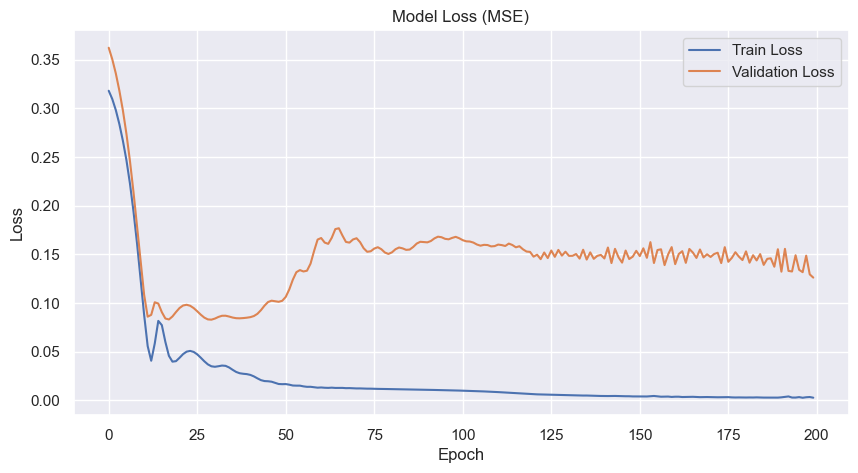

1/1 [==============================] - 0s 409ms/step
    Real Values   Predictions
0        416401  431491.75000
1        422912  441274.06250
2        426802  443397.34375
3        418290  442510.15625
4        421703  440336.53125
5        412939  438695.09375
6        421758  441336.87500
7        446306  440606.21875
8        447156  445429.53125
9        444662  449292.71875
10       514133  452757.90625
11       433443  460079.65625
12       420410  458989.93750
13       411592  454720.59375
14       378184  449435.31250
15       414996  442983.68750
16       437452  439901.87500
17       417780  439309.56250
18       406326  438861.31250
19       406326  437120.84375
20       403046  437070.12500
Accuracy basado en un umbral del 1.0%: 9.52%


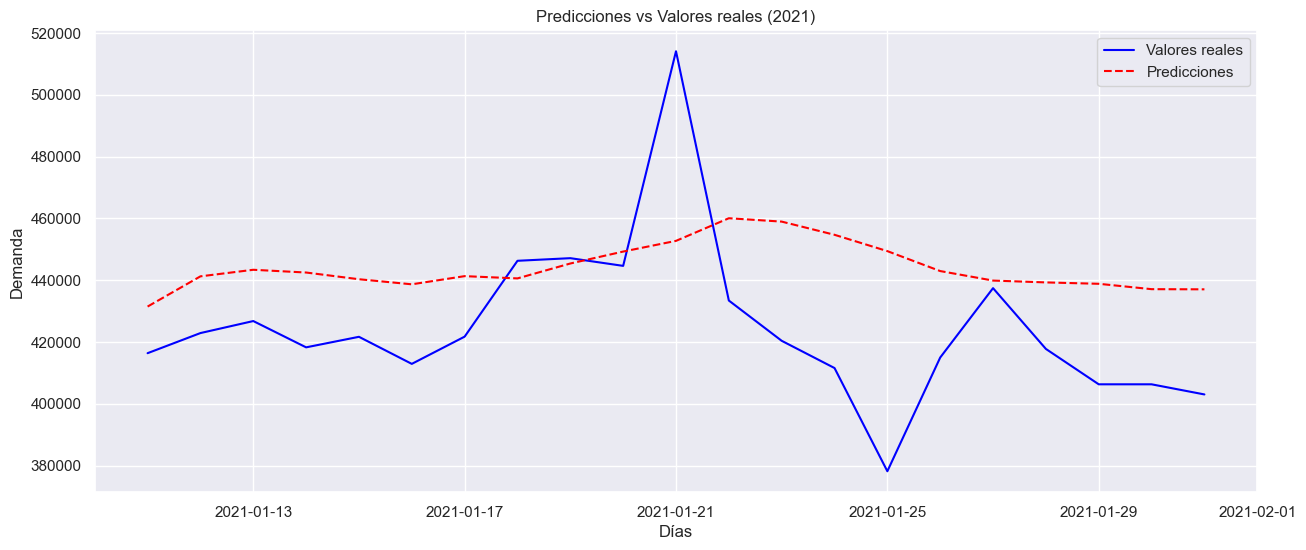

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.3376 - val_loss: 0.3553
Epoch 2/200
1/1 [==============================] - 0s 51ms/step - loss: 0.3131 - val_loss: 0.3379
Epoch 3/200
1/1 [==============================] - 0s 50ms/step - loss: 0.2894 - val_loss: 0.3206
Epoch 4/200
1/1 [==============================] - 0s 50ms/step - loss: 0.2660 - val_loss: 0.3035
Epoch 5/200
1/1 [==============================] - 0s 60ms/step - loss: 0.2430 - val_loss: 0.2864
Epoch 6/200
1/1 [==============================] - 0s 49ms/step - loss: 0.2205 - val_loss: 0.2693
Epoch 7/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1987 - val_loss: 0.2524
Epoch 8/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1777 - val_loss: 0.2358
Epoch 9/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1571 - val_loss: 0.2196
Epoch 10/200
1/1 [==============================] - 0s 70ms/step - loss: 0.1373 - val_loss: 0.2039
Epoch 11/200
1/1 [===

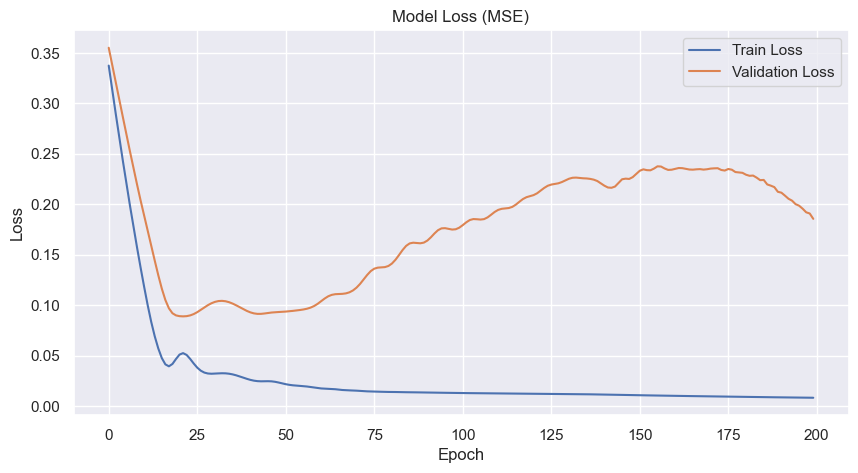

1/1 [==============================] - 0s 300ms/step
    Real Values   Predictions
0        416401  432292.40625
1        422912  440141.00000
2        426802  440673.31250
3        418290  439646.84375
4        421703  437655.84375
5        412939  435494.87500
6        421758  437111.21875
7        446306  435991.75000
8        447156  436926.84375
9        444662  439728.78125
10       514133  445251.68750
11       433443  458205.59375
12       420410  462749.37500
13       411592  462620.75000
14       378184  461988.65625
15       414996  456160.03125
16       437452  457430.75000
17       417780  460765.84375
18       406326  457948.68750
19       406326  450963.75000
20       403046  446712.96875
Accuracy basado en un umbral del 1.0%: 0.00%


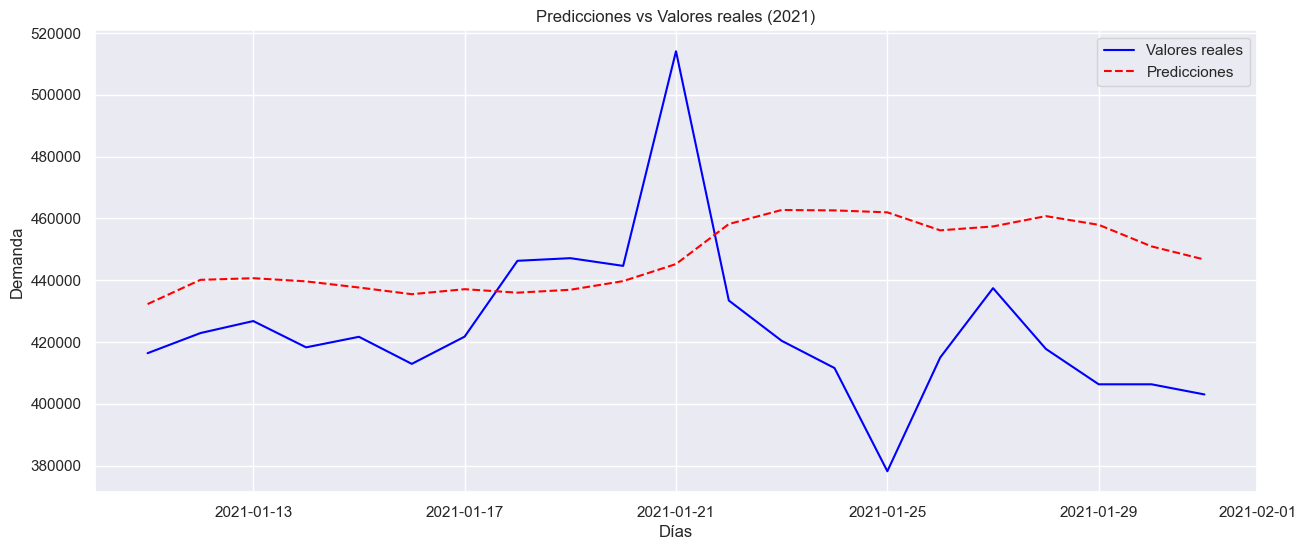

[('config4',
  {'layers': 1,
   'units': 128,
   'return_sequence': False,
   'recurrent_dropout': 0.2,
   'dense_dropout': 0.3,
   'dense_layers': [64]},
  0.12332119047641754),
 ('config5',
  {'layers': 1,
   'units': 128,
   'return_sequence': False,
   'recurrent_dropout': 0,
   'dense_dropout': 0.2,
   'dense_layers': [32, 64, 128, 64]},
  0.12614910304546356),
 ('config2',
  {'layers': 1,
   'units': 256,
   'return_sequence': False,
   'recurrent_dropout': 0,
   'dense_dropout': 0.2,
   'dense_layers': [64, 128]},
  0.14418376982212067),
 ('config1',
  {'layers': 1,
   'units': 128,
   'return_sequence': False,
   'recurrent_dropout': 0,
   'dense_dropout': 0.2,
   'dense_layers': [32, 64, 128]},
  0.167775958776474),
 ('config6',
  {'layers': 1,
   'units': 64,
   'return_sequence': False,
   'recurrent_dropout': 0,
   'dense_dropout': 0,
   'dense_layers': [32]},
  0.1856033056974411),
 ('config3',
  {'layers': 2,
   'units': 128,
   'return_sequence': True,
   'recurrent_drop

In [44]:
def train_and_validate_fixed_years_ranked_with_names(model, data, configs):
    train_data = data[data.index.year.isin([2019, 2020])]
    val_data = data[data.index.year == 2021]
    
    results = []
    for config_name, config in configs.items():
        #aqui le cambio el look_back y el mes
        result = model(10, train_data.append(val_data), 1, config)
        results.append((config_name, config, result))
    
    ranked_results = sorted(results, key=lambda x: x[2])
    return ranked_results

configs_dict = {
    'config1': config1,'config2': config2,'config3': config3,'config4': config4,'config5': config5,'config6': config6,


}
ranked_results = train_and_validate_fixed_years_ranked_with_names(LSTMDemandaDiariaPorMesesConfig, dataFullCaracteristicas, configs_dict)
ranked_results



# PRUEBAS 

In [49]:
def LSTMBestConfiguration(time_steps, data, month_to_predict, config):
    #lstm para probar las mejores configuraciones

    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)
    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs[inputs.index.year.isin([2019, 2020])]
    train_target = target[target.index.year.isin([2019, 2020])]
    val_inputs = inputs[inputs.index.year == 2021]
    val_target = target[target.index.year == 2021]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps].values)
            y_list.append(y[i+time_steps].values)
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs, train_target, time_steps)
    X_val, y_val = prepare_data(val_inputs, val_target, time_steps)

    model = Sequential()
    for i in range(config['layers']):
        return_seq = config['return_sequence'] if i < config['layers'] - 1 else False
        model.add(LSTM(config['units'], activation='relu', return_sequences=return_seq, 
                       recurrent_dropout=config['recurrent_dropout'], 
                       input_shape=(time_steps, len(input_columns))))
    
    for units in config['dense_layers']:
        model.add(Dense(units, activation='relu'))
        if config['dense_dropout'] > 0:
            model.add(Dropout(config['dense_dropout']))
    
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=0)

    return history.history['val_loss'][-1]


In [50]:
def search_random(model, data, n_iter=10):
    param_distributions = {
        'layers': [1, 2, 3, 4],
        'units': [30, 40, 50, 60, 70, 80, 90, 100],
        'return_sequence': [True, False],
        'recurrent_dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
        'dense_layers': [[30], [40], [50], [30, 15], [40, 20], [50, 25]],
        'dense_dropout': [0.1, 0.2, 0.3, 0.4, 0.5]
    }
    
    results = []
    
    train_data = data[data.index.year.isin([2019, 2020])]
    val_data = data[data.index.year == 2021]
    
    for _ in range(n_iter):
        config = {param: random.choice(values) for param, values in param_distributions.items()}
        
        val_error = model(10, train_data.append(val_data), 1, config)
        results.append((config, val_error))
    ranked_results = sorted(results, key=lambda x: x[1])
    
    return ranked_results




In [ ]:

 ranked_results_simple = search_random(LSTMBestConfiguration, dataFullCaracteristicas, n_iter=20)
ranked_results_simple

In [ ]:
ranked_results_simple = search_random(LSTMBestConfiguration, dataFullCaracteristicas, n_iter=20)
print(ranked_results_simple)


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

## Predicción según meses

In [93]:
dataPredMes = data.copy()
dataPredMes

NameError: name 'data' is not defined

In [111]:
data1_19_20 = dataPredMes[(dataPredMes.index.month == 4) & (dataPredMes.index.year <= 2020)]
data1_21 = dataPredMes[(dataPredMes.index.month == 1) & (dataPredMes.index.year == 2021)]

In [112]:
train_data  = data1_19_20
train_data = train_data.drop('Produccion', axis=1)
train_data

Demanda
fecha              
2019-04-01   286390
2019-04-02   283185
2019-04-03   281100
2019-04-04   273165
2019-04-05   270548
2019-04-06   273851
2019-04-07   276671
2019-04-08   274952
2019-04-09   273243
2019-04-10   277249
2019-04-11   277577
2019-04-12   275304
2019-04-13   277056
2019-04-14   275659
2019-04-15   277416
2019-04-16   282269
2019-04-17   280209
2019-04-18   277804
2019-04-19   276820
2019-04-20   277358
2019-04-21   274310
2019-04-22   271071
2019-04-23   271005
2019-04-24   265778
2019-04-25   273833
2019-04-26   272873
2019-04-27   275624
2019-04-28   284252
2019-04-29   295115
2019-04-30   297353
2020-04-01   262326
2020-04-02   265847
2020-04-03   260356
2020-04-04   260415
2020-04-05   260290
2020-04-06   261459
2020-04-07   262692
2020-04-08   269437
2020-04-09   272344
2020-04-10   282602
2020-04-11   288420
2020-04-12   284245
2020-04-13   277975
2020-04-14   275214
2020-04-15   272721
2020-04-16   270850
2020-04-17   274349
2020-04-18   282000
2020-04-19   283465
2020-04-20   279172
2020-04-21   288504
2020-04-22   309798
2020-04-23   324502
2020-04-24   342249
2020-04-25   352359
2020-04-26   371136
2020-04-27   344921
2020-04-28   325709
2020-04-29   325771
2020-04-30   316859

In [113]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

In [114]:
timesteps = 62

In [115]:

def create_sequences(data):
    X, y = [], []
    for i in range(len(data)-timesteps-1):
        X.append(data[i:(i+timesteps), 0])
        y.append(data[(i+timesteps), 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [116]:
X_train, y_train = create_sequences(train_data_scaled)

In [118]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

IndexError: tuple index out of range

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
1/1 - 3s - loss: 0.1555 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.1361 - 20ms/epoch - 20ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1191 - 22ms/epoch - 22ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1042 - 21ms/epoch - 21ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0912 - 23ms/epoch - 23ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0802 - 20ms/epoch - 20ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0714 - 18ms/epoch - 18ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0650 - 18ms/epoch - 18ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0615 - 20ms/epoch - 20ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0613 - 18ms/epoch - 18ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0641 - 19ms/epoch - 19ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0676 - 16ms/epoch - 16ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0693 - 19ms/epoch - 19ms/step
Epoch 14/100
1/1 - 0s - loss: 0.0686 - 15ms/epoch - 15ms/step
Epoch 15/100
1/1 - 0s - loss: 0.0663 - 17ms/epoch - 17ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0636 - 16ms/epoch - 16ms/step
Epoch 17/100
1/1 - 0s

In [ ]:
last_data = train_data_scaled[-timesteps:]
pred_values = []
for i in range(31):
    test_data_seq = last_data[-timesteps:]
    test_data_seq = test_data_seq.reshape(1, timesteps, 1)
    pred = model.predict(test_data_seq)
    pred_values.append(pred[0][0])
    last_data = np.append(last_data, pred)[1:]

1/1 [==============================] - 0s 23ms/step


In [ ]:
pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))

In [ ]:
for i, value in enumerate(pred_values):
    print("La demanda para el día", i+1, "de enero de 2021 es:", value[0])

La demanda para el día 1 de enero de 2021 es: 258554.78
La demanda para el día 2 de enero de 2021 es: 257502.66
La demanda para el día 3 de enero de 2021 es: 256607.48
La demanda para el día 4 de enero de 2021 es: 255845.81
La demanda para el día 5 de enero de 2021 es: 255237.47
La demanda para el día 6 de enero de 2021 es: 254766.58
La demanda para el día 7 de enero de 2021 es: 254438.48
La demanda para el día 8 de enero de 2021 es: 254229.55
La demanda para el día 9 de enero de 2021 es: 254029.19
La demanda para el día 10 de enero de 2021 es: 253864.6
La demanda para el día 11 de enero de 2021 es: 253758.48
La demanda para el día 12 de enero de 2021 es: 253696.56
La demanda para el día 13 de enero de 2021 es: 253666.06
La demanda para el día 14 de enero de 2021 es: 253645.9
La demanda para el día 15 de enero de 2021 es: 253640.44
La demanda para el día 16 de enero de 2021 es: 253615.64
La demanda para el día 17 de enero de 2021 es: 253594.44
La demanda para el día 18 de enero de 2021

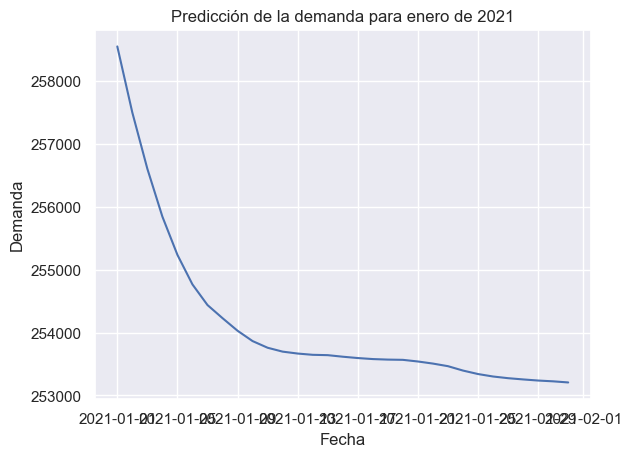

In [ ]:
fechas = [datetime.date(2021, 1, i+1) for i in range(len(pred_values))]
plt.plot(fechas, pred_values)
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Predicción de la demanda para enero de 2021')
plt.show()

In [1]:
def demanda_segun_mes(mes,look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data  = data1_19_20.copy()
    train_data = train_data.drop('Produccion', axis=1)
    train_data
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data  = data1_21.copy()
    val_data  = val_data .drop('Produccion', axis=1)
    val_data 
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    X, y = [], []
    for i in range(len(train_data_scaled)-timesteps-1):
        X.append(train_data_scaled[i:(i+timesteps), 0])
        y.append(train_data_scaled[(i+timesteps), 0])
    X_train = np.array(X)
    y_train = np.array(y)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(timesteps, 1), return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)
    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(look_back):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(fechas, val_data, label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()


    return pred_values

In [2]:
demanda_segun_mes(2,28)

NameError: name 'dataPredMes' is not defined

In [ ]:

def demanda_segun_mes2(mes, look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data = data1_19_20.drop('Produccion', axis=1)
    
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data = data1_21.drop('Produccion', axis=1)
    
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    
    X_train, y_train = [], []
    for i in range(len(train_data_scaled) - look_back - 1):
        X_train.append(train_data_scaled[i:(i + look_back), 0])
        y_train.append(train_data_scaled[(i + look_back), 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    layers = 1
    units = 128
    return_sequence = False
    recurrent_dropout = 0
    dense_dropout = 0.2
    dense_layers = [32, 64, 128]

    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in range(layers - 1):
        model.add(LSTM(units, return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in dense_layers:
        model.add(Dense(i, activation='relu'))
        model.add(Dropout(dense_dropout))
    model.add(Dense(1))

    optimizer = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    batch_size = 64
    epochs = 200
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(len(val_data)):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(val_data.index, val_data['Demanda'], label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()

    return pred_values


Epoch 1/200
1/1 - 3s - loss: 0.3570 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 0.3339 - 34ms/epoch - 34ms/step
Epoch 3/200
1/1 - 0s - loss: 0.2953 - 38ms/epoch - 38ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2564 - 37ms/epoch - 37ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2290 - 35ms/epoch - 35ms/step
Epoch 6/200
1/1 - 0s - loss: 0.1873 - 34ms/epoch - 34ms/step
Epoch 7/200
1/1 - 0s - loss: 0.1458 - 36ms/epoch - 36ms/step
Epoch 8/200
1/1 - 0s - loss: 0.1373 - 34ms/epoch - 34ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0997 - 37ms/epoch - 37ms/step
Epoch 10/200
1/1 - 0s - loss: 0.1103 - 37ms/epoch - 37ms/step
Epoch 11/200
1/1 - 0s - loss: 0.1543 - 35ms/epoch - 35ms/step
Epoch 12/200
1/1 - 0s - loss: 0.1455 - 43ms/epoch - 43ms/step
Epoch 13/200
1/1 - 0s - loss: 0.1022 - 32ms/epoch - 32ms/step
Epoch 14/200
1/1 - 0s - loss: 0.1076 - 30ms/epoch - 30ms/step
Epoch 15/200
1/1 - 0s - loss: 0.0927 - 31ms/epoch - 31ms/step
Epoch 16/200
1/1 - 0s - loss: 0.1012 - 38ms/epoch - 38ms/step
Epoch 17/200
1/1 - 0s

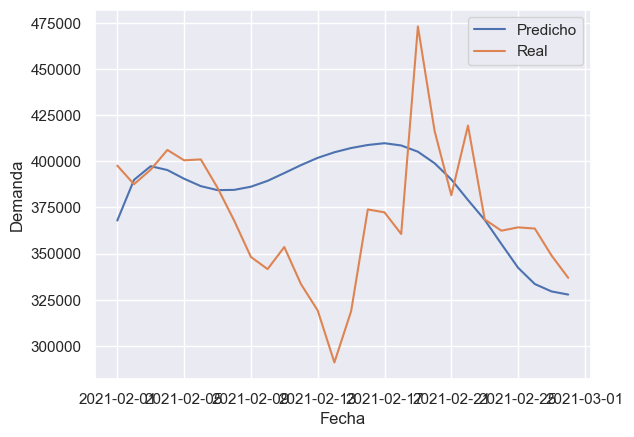

array([[367924.47],
       [389946.7 ],
       [397349.03],
       [395276.38],
       [390564.6 ],
       [386556.2 ],
       [384395.1 ],
       [384531.62],
       [386243.72],
       [389421.7 ],
       [393630.4 ],
       [397942.25],
       [401870.72],
       [404898.1 ],
       [407188.2 ],
       [408839.5 ],
       [409799.8 ],
       [408577.  ],
       [405196.12],
       [398946.5 ],
       [390177.5 ],
       [379021.66],
       [368295.53],
       [355223.12],
       [342360.8 ],
       [333547.38],
       [329540.66],
       [327840.78]], dtype=float32)

In [ ]:
demanda_segun_mes2(2, 28)